In [ ]:
# Cell 1: Import Library dan Setup untuk ECG Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (calinski_harabasz_score, adjusted_rand_score,
                           silhouette_score, davies_bouldin_score,
                           homogeneity_score, completeness_score, v_measure_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi medis
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

print("✅ Library untuk analisis ECG berhasil diimport!")
print("📊 Dataset: PTB-XL ECG Analysis dengan 8 fitur per lead")


✅ Library untuk analisis ECG berhasil diimport!
📊 Dataset: PTB-XL ECG Analysis dengan 8 fitur per lead


In [ ]:
# Cell 2: Load dan Preprocessing Data ECG
def load_ecg_data(filename):
    """
    Load data ECG dengan format Eropa (separator ; dan desimal .)
    """
    try:
        # Baca data ECG
        df = pd.read_csv(filename, sep=';', decimal='.', encoding='utf-8')
        print(f"✅ Data ECG berhasil dimuat! Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"❌ Error loading ECG data: {e}")
        # Fallback untuk membaca dari window.fs jika di browser
        try:
            import window
            file_content = window.fs.readFile(filename, {'encoding': 'utf8'})
            # Process manual parsing jika perlu
            print("🔄 Mencoba membaca dengan metode alternatif...")
        except:
            print("⚠️ Gagal membaca file. Pastikan file tersedia.")
        return None

def preprocess_ecg_data(df):
    """
    Preprocessing khusus untuk data ECG PTB-XL
    """
    print("🔄 Memulai preprocessing data ECG...")

    # Informasi dataset
    print(f"📊 Shape data awal: {df.shape}")
    print(f"📊 Kolom: {len(df.columns)} features")

    # Drop kelas 'Rhythm Abnormality' dan 'Waveform Abnormality'
    classes_to_drop = ['Rhythm Abnormality', 'Waveform Abnormality']
    df_filtered = df[~df['diagnostic_class'].isin(classes_to_drop)].copy()
    print(f"✅ Data setelah drop kelas '{classes_to_drop}': {df_filtered.shape}")

    # Identifikasi kolom
    # Exclude 'record_id' and 'diagnostic_class' from feature columns
    feature_cols = [col for col in df_filtered.columns if col not in ['record_id', 'diagnostic_class']]
    target_col = 'diagnostic_class'

    print(f"📊 Jumlah fitur ECG: {len(feature_cols)}")
    print(f"📊 Target column: {target_col}")

    # Cek missing values
    missing_info = df_filtered.isnull().sum()
    print(f"📊 Missing values: {missing_info.sum()} total")

    # Handle missing values untuk fitur numerik
    df_clean = df_filtered.copy()
    for col in feature_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    # Analisis kelas diagnosis
    class_counts = df_clean[target_col].value_counts()
    print(f"\\n📊 Distribusi Kelas Diagnosis:")
    for class_name, count in class_counts.items():
        percentage = (count / len(df_clean)) * 100
        print(f"   {class_name}: {count} ({percentage:.2f}%)")

    # Pisahkan fitur dan target
    X = df_clean[feature_cols]
    y = df_clean[target_col]

    # Encode target untuk analisis
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    print("✅ Preprocessing ECG selesai!")
    return X, y, y_encoded, le, feature_cols

# Load data ECG
filename = 'PTBDB_ptbxl gABUNGAN_222.csv'
df_ecg = load_ecg_data(filename)

if df_ecg is not None:
    X_ecg, y_ecg, y_encoded, label_encoder, ecg_features = preprocess_ecg_data(df_ecg)
    print(f"✅ Data ECG siap untuk analisis! Features: {X_ecg.shape[1]}, Samples: {X_ecg.shape[0]}")

✅ Data ECG berhasil dimuat! Shape: (805, 98)
🔄 Memulai preprocessing data ECG...
📊 Shape data awal: (805, 98)
📊 Kolom: 98 features
✅ Data setelah drop kelas '['Rhythm Abnormality', 'Waveform Abnormality']': (805, 98)
📊 Jumlah fitur ECG: 96
📊 Target column: diagnostic_class
📊 Missing values: 27 total
\n📊 Distribusi Kelas Diagnosis:
   HEALTHY_CONTROL: 359 (44.60%)
   MYOCARDIAL_INFARCTION: 345 (42.86%)
   CARDIOMYOPATHY: 17 (2.11%)
   BUNDLE_BRANCH_BLOCK: 17 (2.11%)
   DYSRHYTHMIA: 16 (1.99%)
   HYPERTROPHY: 7 (0.87%)
   VALVULAR_HEART_DISEASE: 6 (0.75%)
   MYOCARDITIS: 4 (0.50%)
   STABLE_ANGINA: 2 (0.25%)
   HEART_FAILURE_NYHA_2: 1 (0.12%)
   HEART_FAILURE_NYHA_3: 1 (0.12%)
   HEART_FAILURE_NYHA_4: 1 (0.12%)
   PALPITATION: 1 (0.12%)
   UNSTABLE_ANGINA: 1 (0.12%)
✅ Preprocessing ECG selesai!
✅ Data ECG siap untuk analisis! Features: 96, Samples: 805


In [ ]:
df_ecg.info()
df_ecg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 98 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   record_id         805 non-null    object 
 1   rr_i              805 non-null    float64
 2   rr_std_i          805 non-null    float64
 3   pr_i              805 non-null    float64
 4   qs_i              805 non-null    float64
 5   qtc_i             805 non-null    float64
 6   st_i              805 non-null    float64
 7   rs_ratio_i        805 non-null    float64
 8   heartrate_i       805 non-null    float64
 9   rr_ii             805 non-null    float64
 10  rr_std_ii         805 non-null    float64
 11  pr_ii             805 non-null    float64
 12  qs_ii             805 non-null    float64
 13  qtc_ii            805 non-null    float64
 14  st_ii             805 non-null    float64
 15  rs_ratio_ii       805 non-null    float64
 16  heartrate_ii      805 non-null    float64
 1

record_id        rr_i   rr_std_i         pr_i        qs_i  \
0  patient171_s0364lre  786.942857  21.314238   105.474820  128.604317   
1  patient175_s0009_re  795.488889  15.165197   133.355556   54.111111   
2  patient199_s0404lre  878.136000  26.999361  1013.822581   40.677419   
3  patient202_s0421_re  685.446429  25.163456   124.664671   66.520958   
4  patient202_s0422_re  942.669421  46.877084   136.158333   73.475000   

        qtc_i        st_i  rs_ratio_i  heartrate_i       rr_ii  ...  \
0  478.413886  153.850000    1.739109    76.244418  786.964286  ...   
1  390.401707  138.666667    3.028642    75.425315  795.444444  ...   
2  352.367770  111.616960    0.513519    68.326546  878.314516  ...   
3  394.169122  127.565476    2.466758    87.534193  685.482143  ...   
4  383.357861  165.652893    2.658293    63.649036  942.680328  ...   

   heartrate_v5       rr_v6  rr_std_v6       pr_v6      qs_v6      qtc_v6  \
0     76.243034  786.957143  21.220567  131.258993  98.661871  444.913790   
1     75.429529  795.466667  15.230963  122.688889  62.333333  404.858379   
2     68.312659  878.306452  26.458177  408.204918   0.000000  436.415605   
3     87.531153  685.482143  25.104063  112.946108  65.616766  393.569322   
4     63.648300  942.680328  46.505820  159.413223  68.024793  381.302434   

        st_v6  rs_ratio_v6  heartrate_v6     diagnostic_class  
0  156.464286     3.196887     76.243034  BUNDLE_BRANCH_BLOCK  
1  133.844444     1.296874     75.427422  BUNDLE_BRANCH_BLOCK  
2  116.620968     4.571968     68.313286  BUNDLE_BRANCH_BLOCK  
3  126.875000     4.180291     87.529632  BUNDLE_BRANCH_BLOCK  
4  170.991803     4.095188     63.648300  BUNDLE_BRANCH_BLOCK  

[5 rows x 98 columns]

In [ ]:
# Cell 2a: Deteksi dan Penghapusan Outlier
print("🔄 Melakukan Deteksi dan Penghapusan Outlier...")

from sklearn.ensemble import IsolationForest

# Inisialisasi Isolation Forest (sesuaikan contamination sesuai perkiraan persentase outlier)
# contamination='auto' atau nilai float antara 0 dan 0.5
iso_forest = IsolationForest(contamination='auto', random_state=42)

# Latih model dan prediksi outlier (-1 untuk outlier, 1 untuk inlier)
outlier_predictions = iso_forest.fit_predict(X_ecg)

# Filter data untuk menghapus outlier
X_ecg_cleaned = X_ecg[outlier_predictions == 1]
y_ecg_cleaned = y_ecg[outlier_predictions == 1]

print(f"✅ Deteksi dan Penghapusan Outlier selesai!")
print(f"📊 Jumlah data sebelum penghapusan outlier: {X_ecg.shape[0]}")
print(f"📊 Jumlah outlier yang terdeteksi: {np.sum(outlier_predictions == -1)}")
print(f"📊 Jumlah data setelah penghapusan outlier: {X_ecg_cleaned.shape[0]}")

# Update X_ecg and y_ecg to use the cleaned data for subsequent steps
X_ecg = X_ecg_cleaned
y_ecg = y_ecg_cleaned

print("✅ Variabel X_ecg dan y_ecg telah diperbarui dengan data yang sudah dibersihkan dari outlier.")

🔄 Melakukan Deteksi dan Penghapusan Outlier...
✅ Deteksi dan Penghapusan Outlier selesai!
📊 Jumlah data sebelum penghapusan outlier: 805
📊 Jumlah outlier yang terdeteksi: 12
📊 Jumlah data setelah penghapusan outlier: 793
✅ Variabel X_ecg dan y_ecg telah diperbarui dengan data yang sudah dibersihkan dari outlier.


In [ ]:
# !pip install imblearn

In [ ]:
# # Cell 2b: Undersampling Dataset
# print("🔄 Melakukan Undersampling Dataset...")

# from imblearn.under_sampling import RandomUnderSampler

# # Identifikasi kelas terkecil
# class_counts = y_ecg.value_counts()
# smallest_class = class_counts.idxmin()
# n_samples_smallest_class = class_counts.min()

# print(f"📊 Kelas terkecil: '{smallest_class}' dengan {n_samples_smallest_class} sampel.")

# # Lakukan undersampling menggunakan RandomUnderSampler
# # Targetkan jumlah sampel di setiap kelas sama dengan kelas terkecil
# rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42) # 'not minority' keeps all classes except minority at specified count

# # Reshape X_ecg if it's not already 2D (though it should be from preprocessing)
# X_resampled, y_resampled = rus.fit_resample(X_ecg, y_ecg)

# print(f"✅ Undersampling selesai! Shape data baru: {X_resampled.shape}")

# # Cek distribusi kelas setelah undersampling
# print("\\n📊 Distribusi Kelas setelah Undersampling:")
# resampled_class_counts = y_resampled.value_counts()
# for class_name, count in resampled_class_counts.items():
#     percentage = (count / len(y_resampled)) * 100
#     print(f"   {class_name}: {count} ({percentage:.2f}%)")

# # Update X_ecg and y_ecg to use the resampled data for subsequent steps
# X_ecg = X_resampled
# y_ecg = y_resampled

# print("✅ Variabel X_ecg dan y_ecg telah diperbarui dengan data hasil undersampling.")

🔍 EXPLORATORY DATA ANALYSIS - ECG DATA
📊 Statistik Deskriptif Fitur ECG:
           rr_i  rr_std_i       pr_i       qs_i      qtc_i       st_i  \
count   793.000   793.000    793.000    793.000    793.000    793.000   
mean    850.541    65.531    467.283    260.345   2095.994    172.697   
std     162.623   101.544   3003.087   1334.460   8939.931    588.260   
min       0.000     0.000  -2807.777      0.000      0.000     -2.781   
25%     743.091    18.535    108.730     54.000    323.967    118.112   
50%     841.294    33.917    132.667     69.250    392.610    145.714   
75%     944.000    71.170    161.115    104.340    433.801    174.622   
max    2428.200  1780.041  63390.419  20949.126  87057.336  16478.000   

       rs_ratio_i  heartrate_i     rr_ii  rr_std_ii  ...  rs_ratio_v5  \
count     793.000      793.000   793.000    793.000  ...      793.000   
mean        7.392       72.702   848.266     55.265  ...        6.110   
std        17.560       13.408   151.170     63.06

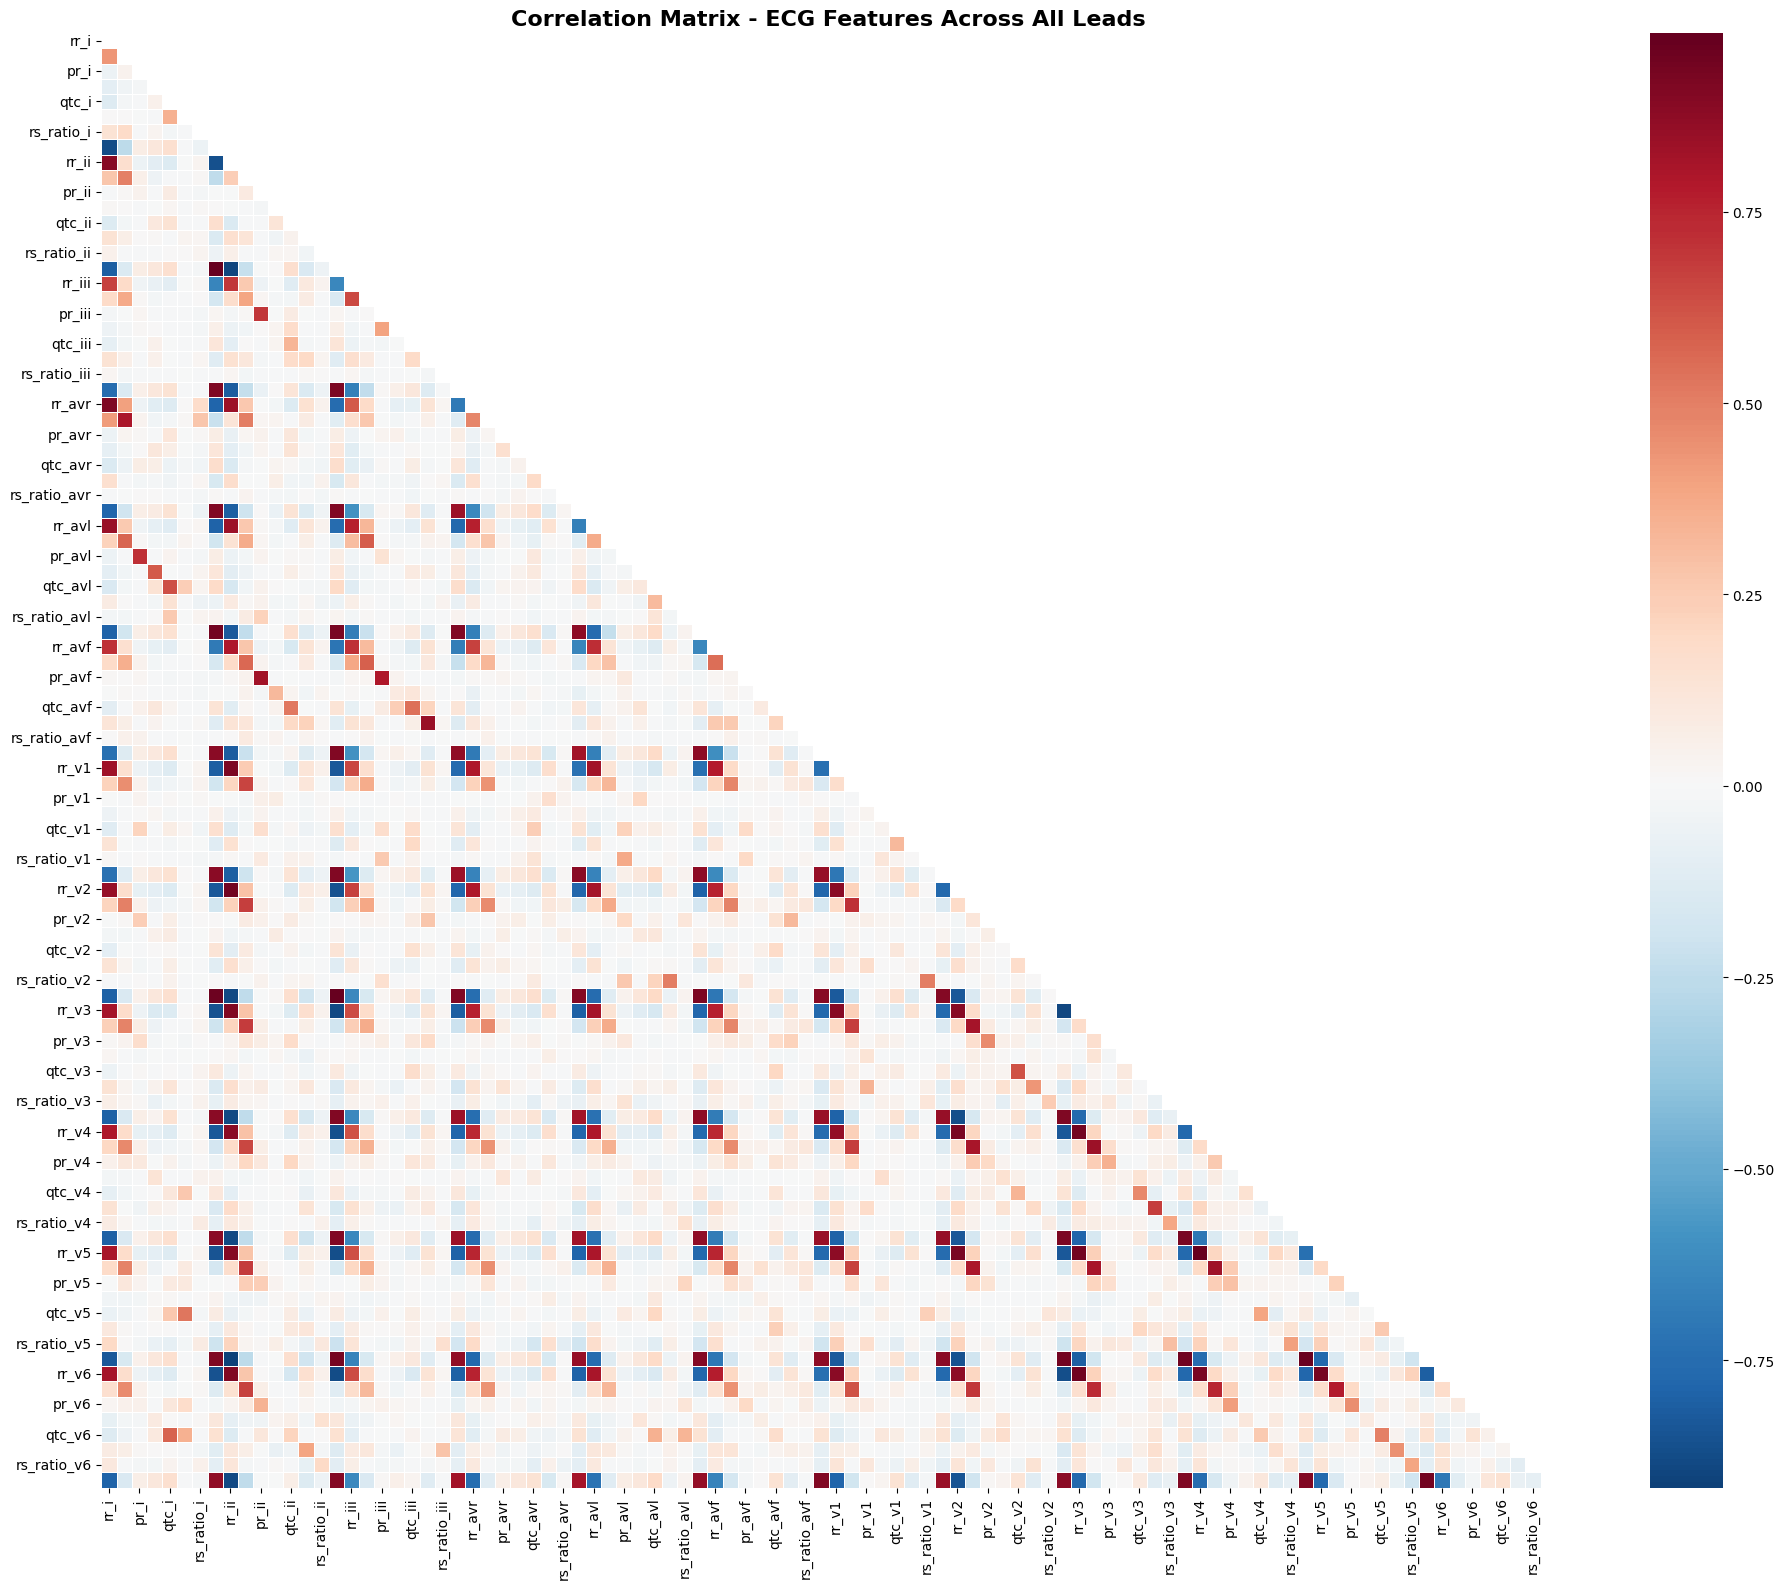

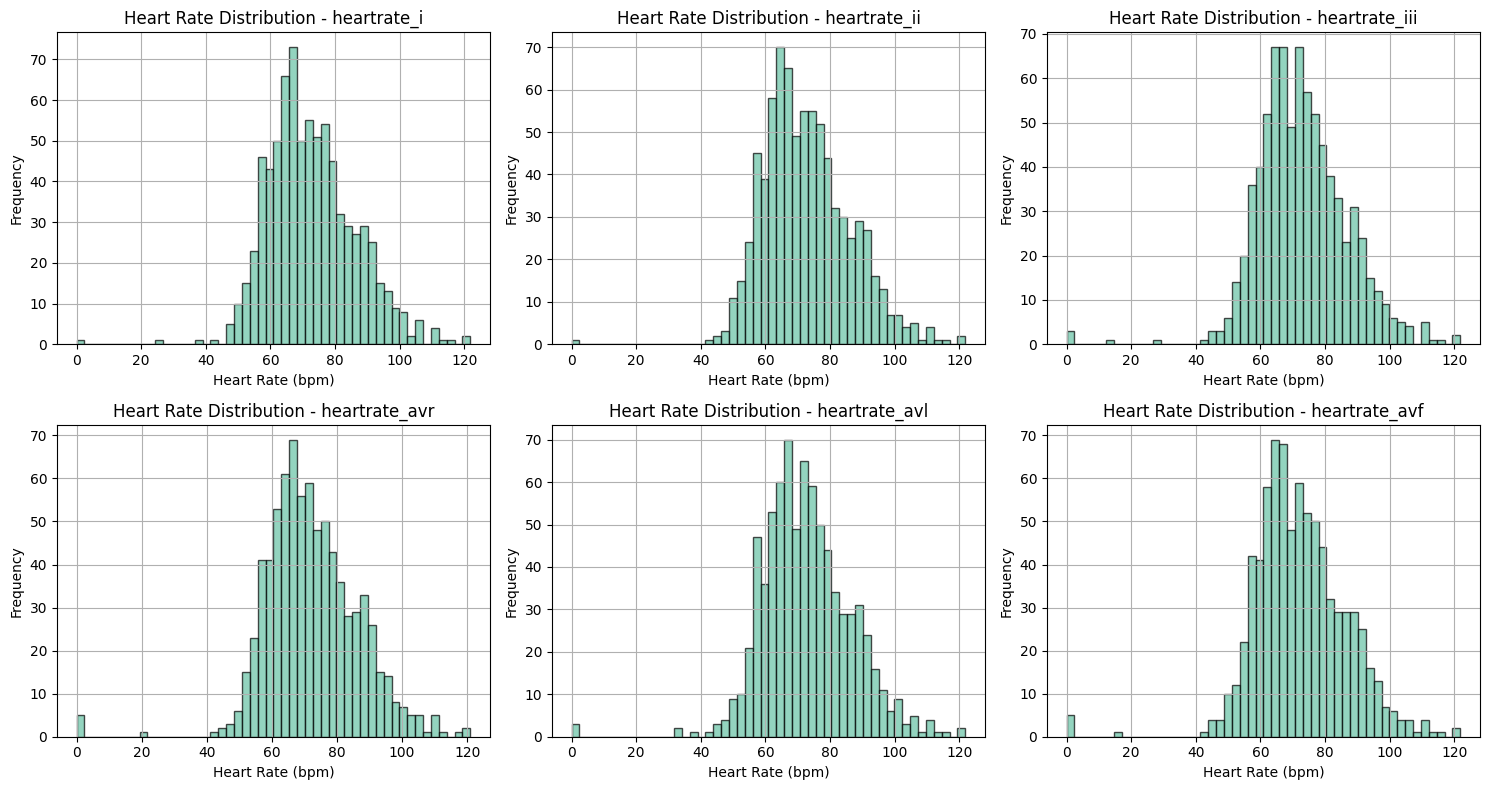

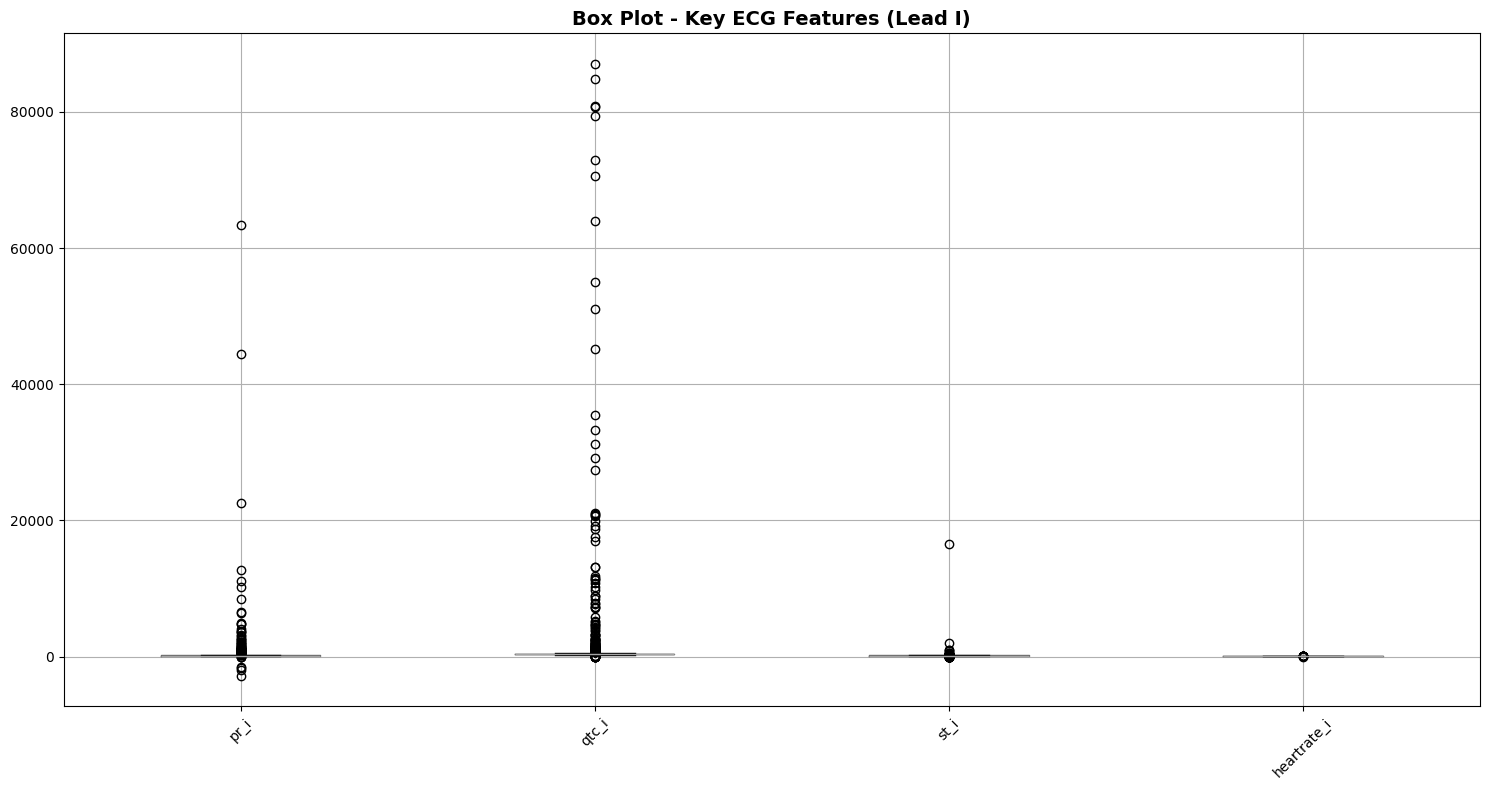

In [ ]:
# Cell 3: Exploratory Data Analysis (EDA) untuk ECG
def explore_ecg_data(X, y, feature_names):
    """
    Analisis eksploratori mendalam untuk data ECG
    """
    print("🔍 EXPLORATORY DATA ANALYSIS - ECG DATA")
    print("=" * 60)

    # Statistik deskriptif
    print("📊 Statistik Deskriptif Fitur ECG:")
    stats = X.describe()
    print(stats.round(3))

    # Visualisasi distribusi fitur per lead
    leads = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
    features_types = ['rr', 'rr_std', 'pr', 'qs', 'qtc', 'st', 'rs_ratio', 'heartrate']

    # Plot heatmap korelasi
    plt.figure(figsize=(20, 16))
    correlation_matrix = X.corr()

    # Buat mask untuk upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r',
                center=0, square=True, linewidths=0.5)
    plt.title('Correlation Matrix - ECG Features Across All Leads', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Distribusi heartrate across leads
    hr_cols = [col for col in X.columns if 'heartrate' in col]
    if len(hr_cols) > 0:
        plt.figure(figsize=(15, 8))
        for i, col in enumerate(hr_cols[:6]):  # Ambil 6 lead pertama
            plt.subplot(2, 3, i+1)
            X[col].hist(bins=50, alpha=0.7, edgecolor='black')
            plt.title(f'Heart Rate Distribution - {col}')
            plt.xlabel('Heart Rate (bpm)')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    # Box plot untuk beberapa fitur penting
    important_features = [col for col in X.columns if any(feat in col for feat in ['heartrate_i', 'qtc_i', 'pr_i', 'st_i'])]
    if len(important_features) > 0:
        plt.figure(figsize=(15, 8))
        X[important_features[:4]].boxplot()
        plt.title('Box Plot - Key ECG Features (Lead I)', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Jalankan EDA
explore_ecg_data(X_ecg, y_ecg, ecg_features)

🔍 ANALISIS DISTRIBUSI NORMAL DATA KESELURUHAN (PCA 1D)
🔬 Varians dijelaskan PCA 1D: 0.2182
📊 Data points: 793

🧪 UJI NORMALITAS:
   Shapiro-Wilk Test:
     Statistic: 0.997667
     p-value: 0.333798
     Normal: Ya (α=0.05)
   Anderson-Darling Test:
     Statistic: 0.629296
     Critical Values: [0.573 0.653 0.783 0.913 1.087]
     Significance Levels: [15.  10.   5.   2.5  1. ]


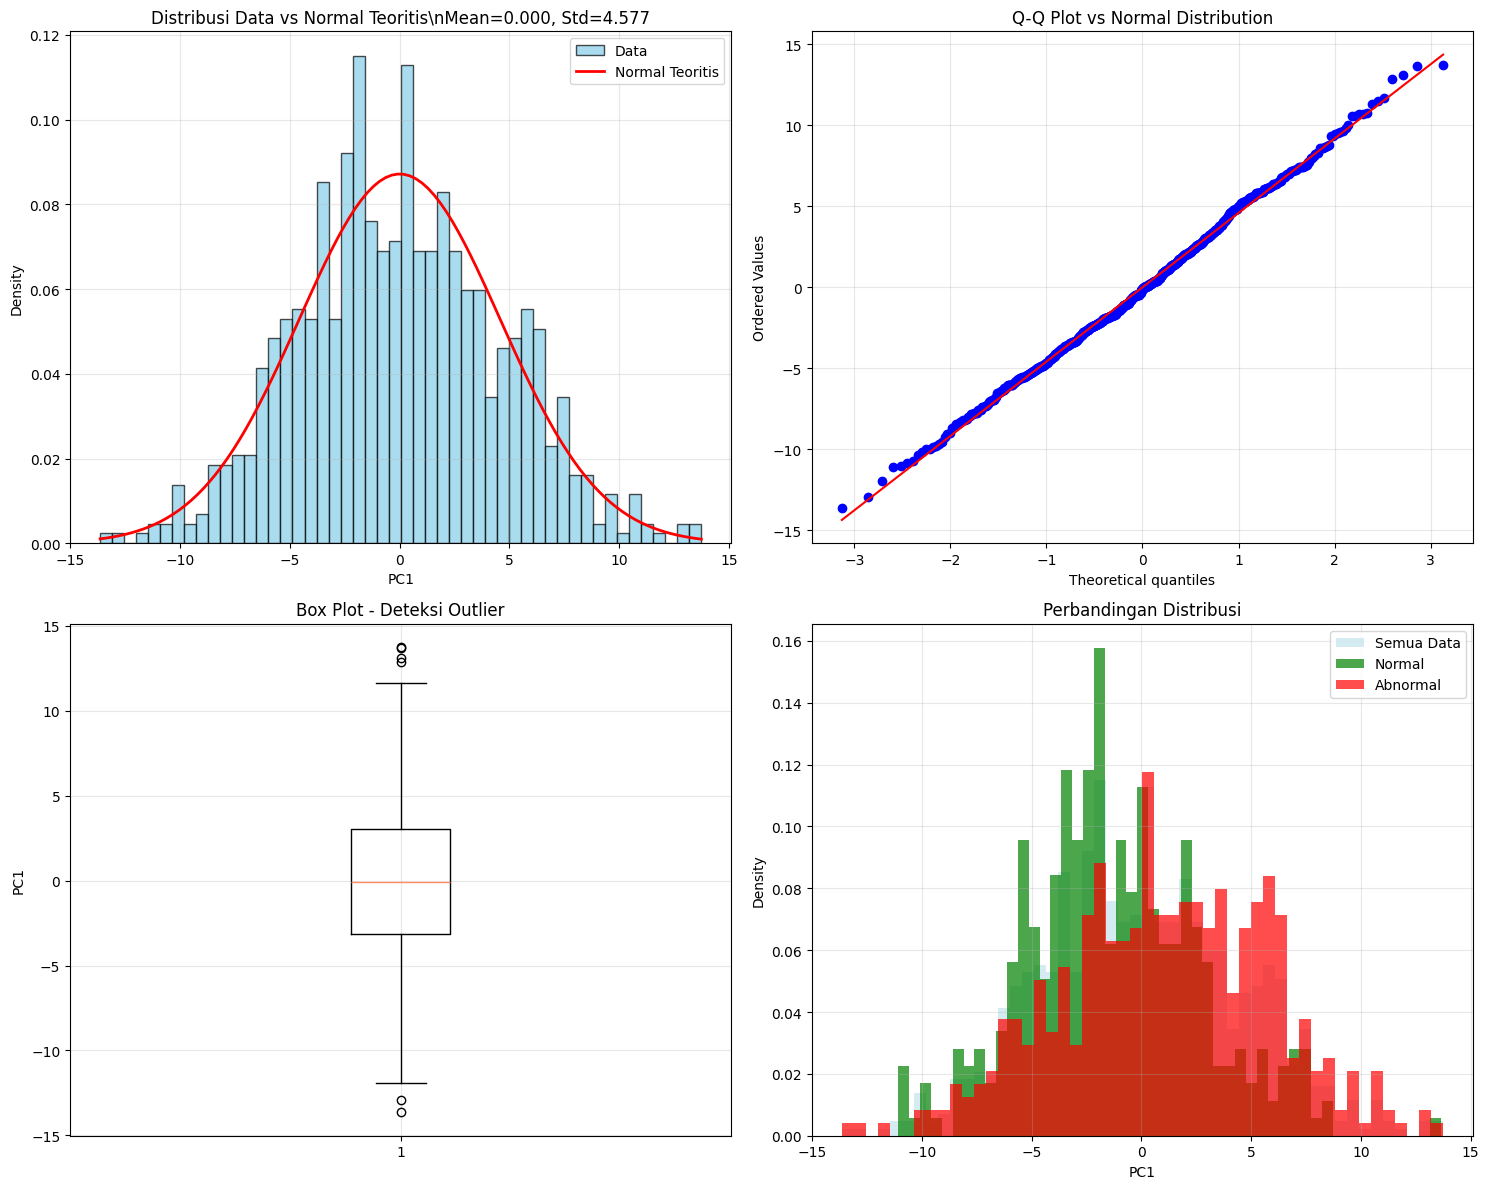


📊 STATISTIK DESKRIPTIF PCA 1D:
   Mean: 0.000000
   Median: -0.087748
   Std: 4.576759
   Skewness: 0.109256
   Kurtosis: -0.145282
   Min: -13.649890
   Max: 13.743101

📈 INTERPRETASI:
   ✅ Distribusi relatif simetris
   ✅ Kurtosis normal (mesokurtic)


In [ ]:
# Cell 4: Analisis Distribusi Normal Data Keseluruhan dengan PCA 1D
def analyze_overall_distribution_1d(X, y):
    """
    Analisis distribusi normal data keseluruhan menggunakan PCA 1 dimensi
    """
    print("🔍 ANALISIS DISTRIBUSI NORMAL DATA KESELURUHAN (PCA 1D)")
    print("=" * 60)

    # Standardisasi data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA 1 komponen untuk seluruh data
    pca_1d = PCA(n_components=1, random_state=42)
    X_pca_1d = pca_1d.fit_transform(X_scaled)

    print(f"🔬 Varians dijelaskan PCA 1D: {pca_1d.explained_variance_ratio_[0]:.4f}")
    print(f"📊 Data points: {len(X_pca_1d)}")

    # Uji normalitas menggunakan Shapiro-Wilk (sample jika data terlalu besar)
    from scipy import stats

    sample_size = min(5000, len(X_pca_1d))  # Shapiro-Wilk maksimal 5000 samples
    if len(X_pca_1d) > sample_size:
        sample_indices = np.random.choice(len(X_pca_1d), sample_size, replace=False)
        sample_data = X_pca_1d[sample_indices].flatten()
        print(f"📊 Menggunakan sample {sample_size} untuk uji normalitas")
    else:
        sample_data = X_pca_1d.flatten()

    # Uji normalitas
    shapiro_stat, shapiro_p = stats.shapiro(sample_data)

    # Uji Anderson-Darling untuk normalitas (lebih robust untuk data besar)
    anderson_stat = stats.anderson(X_pca_1d.flatten(), dist='norm')

    print(f"\n🧪 UJI NORMALITAS:")
    print(f"   Shapiro-Wilk Test:")
    print(f"     Statistic: {shapiro_stat:.6f}")
    print(f"     p-value: {shapiro_p:.6f}")
    print(f"     Normal: {'Ya' if shapiro_p > 0.05 else 'Tidak'} (α=0.05)")

    print(f"   Anderson-Darling Test:")
    print(f"     Statistic: {anderson_stat.statistic:.6f}")
    print(f"     Critical Values: {anderson_stat.critical_values}")
    print(f"     Significance Levels: {anderson_stat.significance_level}")

    # Visualisasi distribusi
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Histogram dengan kurva normal
    axes[0, 0].hist(X_pca_1d.flatten(), bins=50, density=True, alpha=0.7,
                   color='skyblue', edgecolor='black', label='Data')

    # Overlay distribusi normal teoritis
    mu = np.mean(X_pca_1d)
    sigma = np.std(X_pca_1d)
    x_normal = np.linspace(X_pca_1d.min(), X_pca_1d.max(), 100)
    y_normal = stats.norm.pdf(x_normal, mu, sigma)
    axes[0, 0].plot(x_normal, y_normal, 'r-', linewidth=2, label='Normal Teoritis')

    axes[0, 0].set_xlabel('PC1')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title(f'Distribusi Data vs Normal Teoritis\\nMean={mu:.3f}, Std={sigma:.3f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Q-Q Plot
    stats.probplot(X_pca_1d.flatten(), dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot vs Normal Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Box Plot
    axes[1, 0].boxplot(X_pca_1d.flatten(), vert=True)
    axes[1, 0].set_ylabel('PC1')
    axes[1, 0].set_title('Box Plot - Deteksi Outlier')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Density Plot dengan perbandingan distribusi per kelas
    axes[1, 1].hist(X_pca_1d.flatten(), bins=50, density=True, alpha=0.5,
                   color='lightblue', label='Semua Data')

    # Pisahkan berdasarkan normal vs abnormal jika ada kelas NORM
    if 'HEALTHY_CONTROL' in y.values:
        is_normal = (y == 'HEALTHY_CONTROL')
        normal_data = X_pca_1d[is_normal].flatten()
        abnormal_data = X_pca_1d[~is_normal].flatten()

        axes[1, 1].hist(normal_data, bins=50, density=True, alpha=0.7,
                       color='green', label='Normal')
        axes[1, 1].hist(abnormal_data, bins=50, density=True, alpha=0.7,
                       color='red', label='Abnormal')

    axes[1, 1].set_xlabel('PC1')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Perbandingan Distribusi')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistik deskriptif
    print(f"\n📊 STATISTIK DESKRIPTIF PCA 1D:")
    print(f"   Mean: {np.mean(X_pca_1d):.6f}")
    print(f"   Median: {np.median(X_pca_1d):.6f}")
    print(f"   Std: {np.std(X_pca_1d):.6f}")
    print(f"   Skewness: {stats.skew(X_pca_1d.flatten()):.6f}")
    print(f"   Kurtosis: {stats.kurtosis(X_pca_1d.flatten()):.6f}")
    print(f"   Min: {np.min(X_pca_1d):.6f}")
    print(f"   Max: {np.max(X_pca_1d):.6f}")

    # Interpretasi skewness dan kurtosis
    skewness = stats.skew(X_pca_1d.flatten())
    kurtosis = stats.kurtosis(X_pca_1d.flatten())

    print(f"\n📈 INTERPRETASI:")
    if abs(skewness) < 0.5:
        print("   ✅ Distribusi relatif simetris")
    elif abs(skewness) < 1:
        print("   ⚠️ Distribusi agak skewed")
    else:
        print("   ❌ Distribusi sangat skewed")

    if abs(kurtosis) < 0.5:
        print("   ✅ Kurtosis normal (mesokurtic)")
    elif kurtosis > 0.5:
        print("   📈 Distribusi leptokurtic (peak tinggi)")
    else:
        print("   📉 Distribusi platykurtic (peak rendah)")

    return X_scaled, pca_1d, X_pca_1d

# Jalankan analisis distribusi normal 1D
X_scaled, pca_1d_overall, X_pca_1d_overall = analyze_overall_distribution_1d(X_ecg, y_ecg)

🔍 ANALISIS DISTRIBUSI PER KELAS DIAGNOSIS
🔬 Varians dijelaskan PCA 2D: 0.2874
📊 Distribusi Kelas:
   HEALTHY_CONTROL: 359 (45.27%)
   MYOCARDIAL_INFARCTION: 339 (42.75%)
   CARDIOMYOPATHY: 16 (2.02%)
   BUNDLE_BRANCH_BLOCK: 15 (1.89%)
   DYSRHYTHMIA: 14 (1.77%)
   HYPERTROPHY: 7 (0.88%)
   VALVULAR_HEART_DISEASE: 6 (0.76%)
   MYOCARDITIS: 4 (0.50%)
   STABLE_ANGINA: 2 (0.25%)
   HEART_FAILURE_NYHA_2: 1 (0.13%)
   HEART_FAILURE_NYHA_3: 1 (0.13%)
   HEART_FAILURE_NYHA_4: 1 (0.13%)
   PALPITATION: 1 (0.13%)
   UNSTABLE_ANGINA: 1 (0.13%)
🔄 Menjalankan t-SNE untuk visualisasi non-linear...


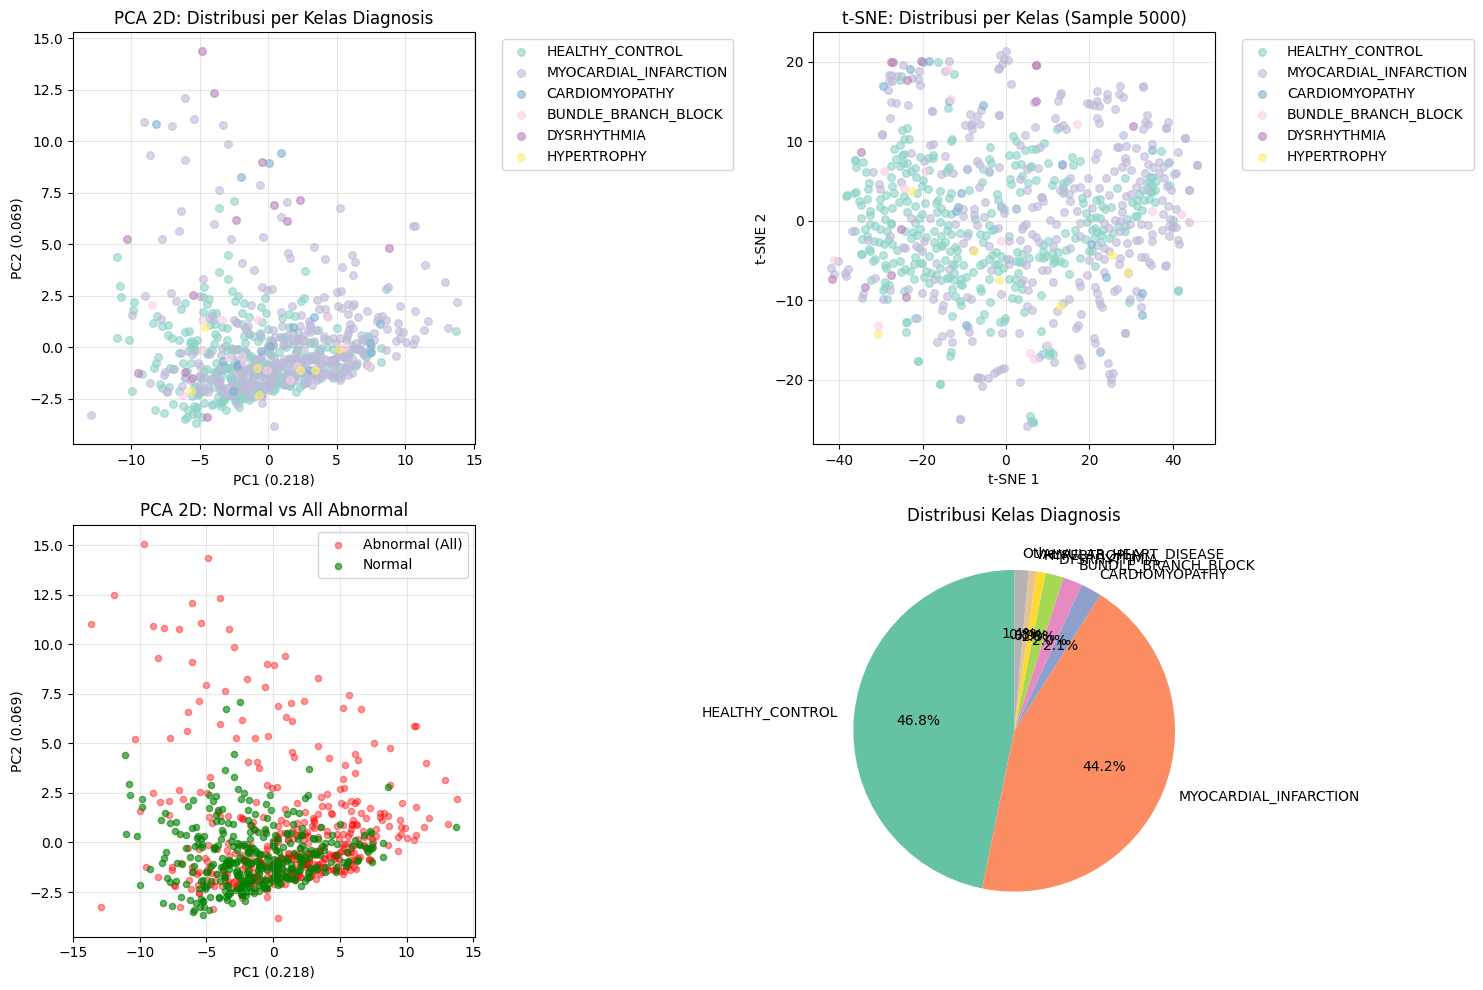

In [ ]:
# Cell 5: Analisis Distribusi per Kelas Diagnosis
def analyze_class_distribution(X_scaled, y):
    """
    Analisis distribusi untuk setiap kelas diagnosis
    """
    print("🔍 ANALISIS DISTRIBUSI PER KELAS DIAGNOSIS")
    print("=" * 50)

    # Lakukan PCA 2D di sini
    pca_2d = PCA(n_components=2, random_state=42)
    X_pca_2d = pca_2d.fit_transform(X_scaled)
    print(f"🔬 Varians dijelaskan PCA 2D: {sum(pca_2d.explained_variance_ratio_):.4f}")


    # Ambil kelas unik dan hitung distribusi
    unique_classes = y.value_counts()
    print("📊 Distribusi Kelas:")
    for class_name, count in unique_classes.items():
        percentage = (count / len(y)) * 100
        print(f"   {class_name}: {count} ({percentage:.2f}%)")

    # Ambil top 6 kelas untuk visualisasi yang jelas
    top_classes = unique_classes.head(6).index.tolist()

    # Plot distribusi semua kelas
    plt.figure(figsize=(15, 10))

    # PCA 2D per kelas
    plt.subplot(2, 2, 1)
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_classes)))

    for i, class_name in enumerate(top_classes):
        mask = (y == class_name)
        plt.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                   c=[colors[i]], alpha=0.6, s=30, label=class_name)

    plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
    plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')
    plt.title('PCA 2D: Distribusi per Kelas Diagnosis')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # t-SNE untuk visualisasi non-linear
    print("🔄 Menjalankan t-SNE untuk visualisasi non-linear...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
    X_tsne = tsne.fit_transform(X_scaled[:5000])  # Subsample untuk speed
    y_tsne = y.iloc[:5000]

    plt.subplot(2, 2, 2)
    for i, class_name in enumerate(top_classes):
        mask = (y_tsne == class_name)
        if mask.sum() > 0:
            plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                       c=[colors[i]], alpha=0.6, s=30, label=class_name)

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('t-SNE: Distribusi per Kelas (Sample 5000)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Fokus pada Normal vs yang lain
    plt.subplot(2, 2, 3)
    normal_mask = (y == 'HEALTHY_CONTROL')
    other_mask = ~normal_mask

    plt.scatter(X_pca_2d[other_mask, 0], X_pca_2d[other_mask, 1],
               c='red', alpha=0.4, s=20, label='Abnormal (All)')
    plt.scatter(X_pca_2d[normal_mask, 0], X_pca_2d[normal_mask, 1],
               c='green', alpha=0.6, s=20, label='Normal')

    plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
    plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')
    plt.title('PCA 2D: Normal vs All Abnormal')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Pie chart distribusi
    plt.subplot(2, 2, 4)
    class_counts = y.value_counts()
    # Gabungkan kelas minor menjadi "Others" jika > 8 kelas
    if len(class_counts) > 8:
        top_7 = class_counts.head(7)
        others_count = class_counts.iloc[7:].sum()
        plot_data = top_7.tolist() + [others_count]
        plot_labels = top_7.index.tolist() + ['Others']
    else:
        plot_data = class_counts.values
        plot_labels = class_counts.index

    plt.pie(plot_data, labels=plot_labels, autopct='%1.1f%%', startangle=90)
    plt.title('Distribusi Kelas Diagnosis')

    plt.tight_layout()
    plt.show()

    return top_classes, X_pca_2d, pca_2d

# Analisis per kelas
top_classes, X_pca_2d, pca_2d = analyze_class_distribution(X_scaled, y_ecg)

🔧 OPTIMASI JUMLAH CLUSTER UNTUK ECG
🔄 Menghitung metrik untuk berbagai k...


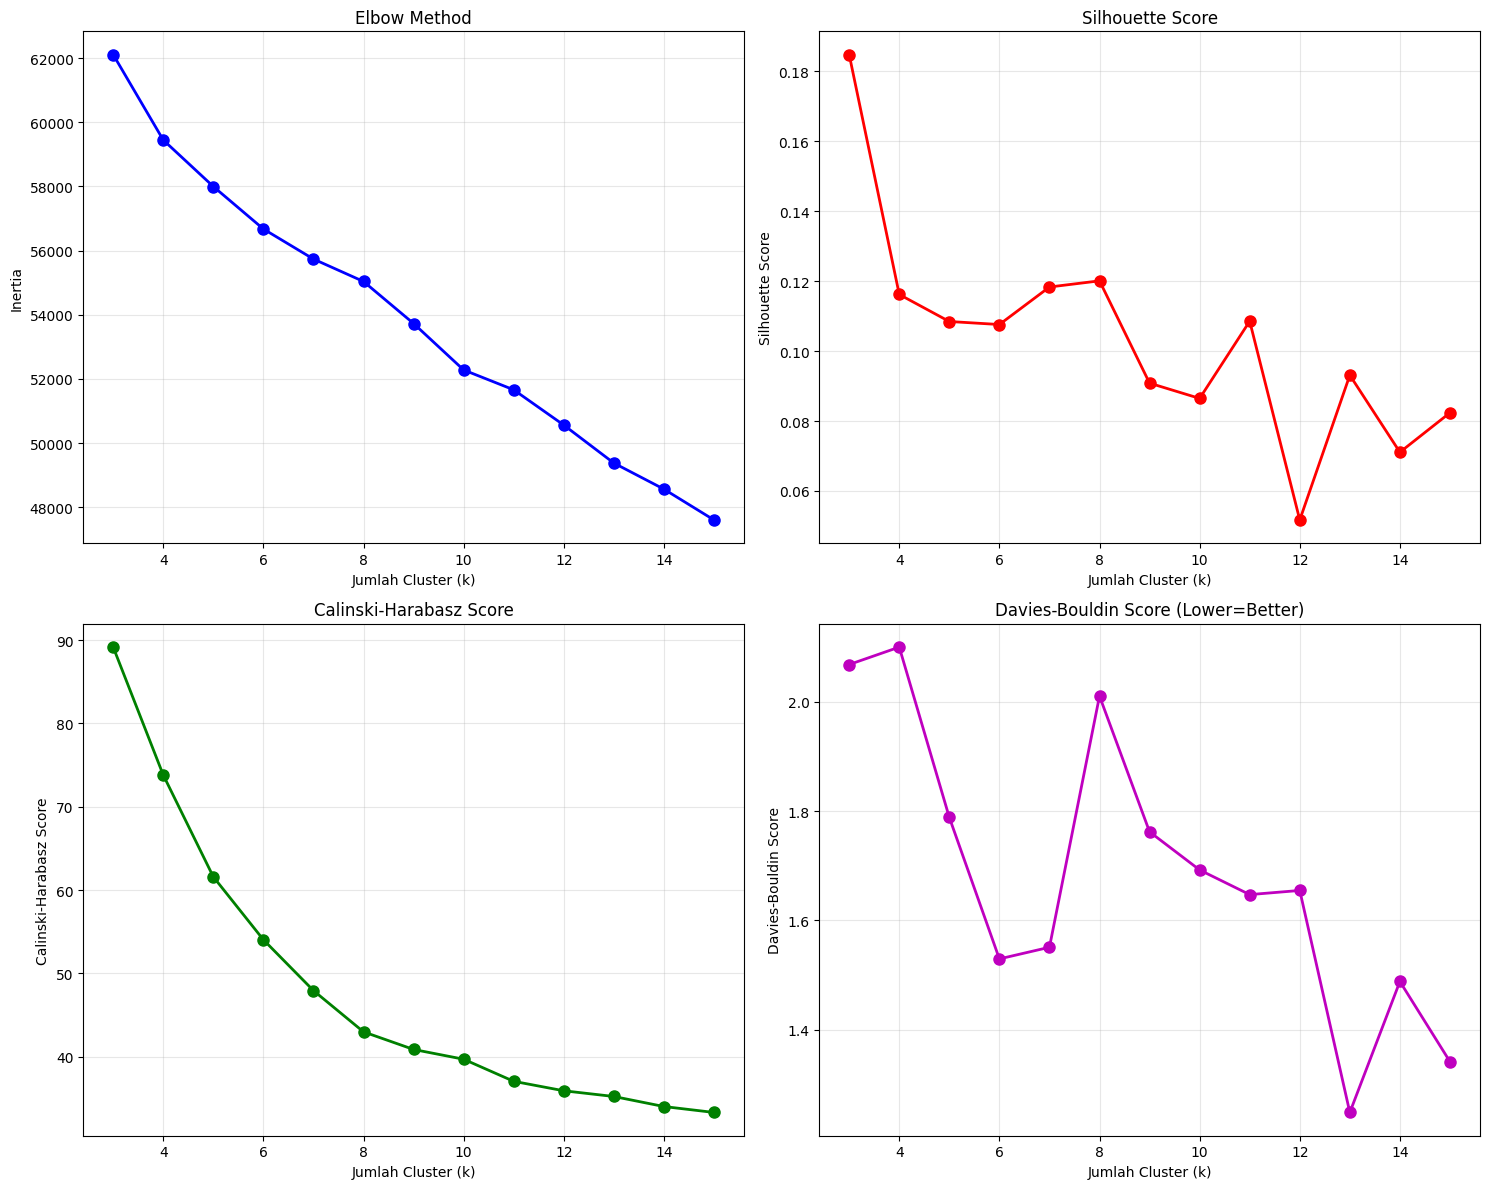

\n📊 Rekomendasi Jumlah Cluster Optimal:
   Silhouette: k=3 (score: 0.1848)
   Calinski Harabasz: k=3 (score: 89.1540)
   Davies Bouldin: k=13 (score: 1.2484)
\n🏆 Konsensus k optimal: 3


In [ ]:
# Cell 6: Optimasi Jumlah Cluster untuk ECG
def optimize_clusters_ecg(X, max_k=15):
    """
    Optimasi jumlah cluster khusus untuk data ECG
    """
    print("🔧 OPTIMASI JUMLAH CLUSTER UNTUK ECG")
    print("=" * 45)

    # Metrik evaluasi
    k_range = range(3, max_k + 1) # Diubah dari range(2, max_k + 1) menjadi range(3, max_k + 1)
    metrics = {
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }

    print("🔄 Menghitung metrik untuk berbagai k...")
    for k in k_range:
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        # Hitung metrik
        metrics['inertia'].append(kmeans.inertia_)
        metrics['silhouette'].append(silhouette_score(X, labels))
        metrics['calinski_harabasz'].append(calinski_harabasz_score(X, labels))
        metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))

    # Visualisasi hasil optimasi
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Elbow Method
    axes[0, 0].plot(k_range, metrics['inertia'], 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Jumlah Cluster (k)')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].set_title('Elbow Method')
    axes[0, 0].grid(True, alpha=0.3)

    # Silhouette Score
    axes[0, 1].plot(k_range, metrics['silhouette'], 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Jumlah Cluster (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score')
    axes[0, 1].grid(True, alpha=0.3)

    # Calinski-Harabasz Score
    axes[1, 0].plot(k_range, metrics['calinski_harabasz'], 'go-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Jumlah Cluster (k)')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    axes[1, 0].set_title('Calinski-Harabasz Score')
    axes[1, 0].grid(True, alpha=0.3)

    # Davies-Bouldin Score (lower is better)
    axes[1, 1].plot(k_range, metrics['davies_bouldin'], 'mo-', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Jumlah Cluster (k)')
    axes[1, 1].set_ylabel('Davies-Bouldin Score')
    axes[1, 1].set_title('Davies-Bouldin Score (Lower=Better)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Rekomendasi optimal k
    best_k = {
        'silhouette': k_range[np.argmax(metrics['silhouette'])],
        'calinski_harabasz': k_range[np.argmax(metrics['calinski_harabasz'])],
        'davies_bouldin': k_range[np.argmin(metrics['davies_bouldin'])]
    }

    print("\\n📊 Rekomendasi Jumlah Cluster Optimal:")
    # Adjust for 0-indexing and starting k value
    for method, k in best_k.items():
        score = metrics[method.replace('_', '_')][k - k_range[0]] # Adjust for starting k
        print(f"   {method.replace('_', ' ').title()}: k={k} (score: {score:.4f})")


    # Voting untuk k optimal
    k_votes = list(best_k.values())
    optimal_k = max(set(k_votes), key=k_votes.count)
    print(f"\\n🏆 Konsensus k optimal: {optimal_k}")

    return optimal_k, metrics

# Optimasi cluster
optimal_k, optimization_metrics = optimize_clusters_ecg(X_scaled)

In [ ]:
# Cell 7a: Implementasi K-Means Clustering
print("🤖 IMPLEMENTASI ALGORITMA CLUSTERING - K-Means")
print("=" * 45)

# 1. K-Means
print("🔄 K-Means Clustering...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Store result
clustering_results = {}
clustering_results['K-Means'] = {
    'model': kmeans,
    'labels': kmeans_labels,
    'centers': kmeans.cluster_centers_
}

print("✅ K-Means Clustering selesai!")
print(f"   Clusters: {len(np.unique(kmeans_labels))}")
print(f"   Noise points: {np.sum(kmeans_labels == -1) if -1 in kmeans_labels else 0}")

🤖 IMPLEMENTASI ALGORITMA CLUSTERING - K-Means
🔄 K-Means Clustering...
✅ K-Means Clustering selesai!
   Clusters: 3
   Noise points: 0


In [ ]:
# Cell 7b: Implementasi Hierarchical Clustering
print("🤖 IMPLEMENTASI ALGORITMA CLUSTERING - Hierarchical")
print("=" * 45)

# 2. Hierarchical Clustering
print("🔄 Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add to results (assuming clustering_results from 7a exists)
if 'clustering_results' not in locals():
    clustering_results = {}
clustering_results['Hierarchical'] = {
    'model': hierarchical,
    'labels': hierarchical_labels,
    'centers': None # Hierarchical clustering doesn't have explicit centers
}

print("✅ Hierarchical Clustering selesai!")
print(f"   Clusters: {len(np.unique(hierarchical_labels))}")
print(f"   Noise points: {np.sum(hierarchical_labels == -1) if -1 in hierarchical_labels else 0}")

🤖 IMPLEMENTASI ALGORITMA CLUSTERING - Hierarchical
🔄 Hierarchical Clustering...
✅ Hierarchical Clustering selesai!
   Clusters: 3
   Noise points: 0


In [ ]:
# # Cell 7c: Implementasi Spectral Clustering
# print("🤖 IMPLEMENTASI ALGORITMA CLUSTERING - Spectral")
# print("=" * 45)

# # 3. Spectral Clustering
# print("🔄 Spectral Clustering...")
# # Spectral Clustering can be memory intensive, consider subsampling for large datasets
# # For this dataset size, it might still be feasible.
# spectral = SpectralClustering(n_clusters=optimal_k, random_state=42,
#                              affinity='rbf', gamma=1.0, n_init=10) # Added n_init
# spectral_labels = spectral.fit_predict(X_scaled)

# # Add to results
# if 'clustering_results' not in locals():
#     clustering_results = {}
# clustering_results['Spectral'] = {
#     'model': spectral,
#     'labels': spectral_labels,
#     'centers': None # Spectral clustering doesn't have explicit centers
# }

# print("✅ Spectral Clustering selesai!")
# print(f"   Clusters: {len(np.unique(spectral_labels))}")
# print(f"   Noise points: {np.sum(spectral_labels == -1) if -1 in spectral_labels else 0}")

In [ ]:
# # Cell 7d: Implementasi DBSCAN Clustering
# print("🤖 IMPLEMENTASI ALGORITMA CLUSTERING - DBSCAN")
# print("=" * 45)

# # 4. DBSCAN (parameter tuning for ECG data)
# print("🔄 DBSCAN Clustering...")
# # Estimate eps using k-distance
# from sklearn.neighbors import NearestNeighbors
# neighbors = NearestNeighbors(n_neighbors=optimal_k)
# neighbors_fit = neighbors.fit(X_scaled) # Use X_scaled
# distances, indices = neighbors_fit.kneighbors(X_scaled) # Use X_scaled
# distances = np.sort(distances[:, optimal_k-1], axis=0)
# # Adjust eps_estimate logic for robustness
# eps_estimate = distances[min(int(0.9 * len(distances)), len(distances) - 1)]  # 90th percentile, handle small data

# # Consider adjusting min_samples based on data density or optimal_k
# min_samples_val = max(5, optimal_k * 2) # A common heuristic is 2*n_features or related to k

# dbscan = DBSCAN(eps=eps_estimate, min_samples=min_samples_val)
# dbscan_labels = dbscan.fit_predict(X_scaled) # Use X_scaled

# # Add to results
# if 'clustering_results' not in locals():
#     clustering_results = {}
# clustering_results['DBSCAN'] = {
#     'model': dbscan,
#     'labels': dbscan_labels,
#     'centers': None # DBSCAN doesn't have explicit centers
# }

# print("✅ DBSCAN Clustering selesai!")
# print(f"   Clusters: {len(np.unique(dbscan_labels))}")
# print(f"   Noise points: {np.sum(dbscan_labels == -1) if -1 in dbscan_labels else 0}")

# print("\n📊 Ringkasan Hasil Clustering (Partial/Incremental):")
# for name, result in clustering_results.items():
#     n_clusters = len(np.unique(result['labels']))
#     n_noise = np.sum(result['labels'] == -1) if -1 in result['labels'] else 0
#     print(f"   {name}: {n_clusters} clusters, {n_noise} noise points")

In [ ]:
# Cell 7e: Implementasi Custom K-Means (Cop K-Means) untuk Isolasi Kelas Normal
print("🤖 IMPLEMENTASI ALGORITMA CLUSTERING - Custom K-Means (Cop K-Means)")
print("=" * 65)

# Identifikasi data 'Normal'
is_normal_mask = (y_ecg == 'HEALTHY_CONTROL')
X_normal = X_scaled[is_normal_mask]
X_abnormal = X_scaled[~is_normal_mask]
y_abnormal = y_ecg[~is_normal_mask] # Keep track of abnormal true labels

print(f"📊 Jumlah data Normal: {len(X_normal)}")
print(f"📊 Jumlah data Abnormal: {len(X_abnormal)}")

# Langkah 1: Klastering data Normal secara terpisah
# Asumsikan semua data Normal membentuk satu cluster
normal_cluster_labels = np.zeros(len(X_normal), dtype=int) # Label 0 untuk cluster Normal
print("✅ Data Normal diidentifikasi sebagai Cluster 0.")

# Langkah 2: Klastering data Abnormal
# Tentukan jumlah cluster untuk data abnormal (total optimal_k - 1)
n_clusters_abnormal = optimal_k - 1
if n_clusters_abnormal <= 0:
    print("⚠️ Jumlah cluster abnormal harus lebih dari 0. Menggunakan 2 cluster untuk abnormal.")
    n_clusters_abnormal = 2

print(f"🔄 Melakukan K-Means untuk data Abnormal dengan {n_clusters_abnormal} cluster...")
kmeans_abnormal = KMeans(n_clusters=n_clusters_abnormal, random_state=42, n_init=10)
abnormal_cluster_labels = kmeans_abnormal.fit_predict(X_abnormal) + 1 # Tambahkan 1 agar label tidak overlap dengan cluster Normal (0)
print("✅ K-Means untuk data Abnormal selesai.")

# Gabungkan hasil clustering
# Buat array label kosong dengan ukuran total data
custom_kmeans_labels = np.zeros(len(X_scaled), dtype=int)

# Tempatkan label cluster Normal
custom_kmeans_labels[is_normal_mask] = normal_cluster_labels

# Tempatkan label cluster Abnormal
custom_kmeans_labels[~is_normal_mask] = abnormal_cluster_labels

# Store result
if 'clustering_results' not in locals():
    clustering_results = {}
clustering_results['Custom K-Means'] = {
    'model': None, # No single model object for this custom approach
    'labels': custom_kmeans_labels,
    'centers': None # Centers would be from the abnormal K-Means + mean of normal cluster
}

print("✅ Custom K-Means Clustering selesai!")
print(f"   Clusters: {len(np.unique(custom_kmeans_labels))}")
print(f"   Noise points: {np.sum(custom_kmeans_labels == -1) if -1 in custom_kmeans_labels else 0}")

# Print ringkasan untuk memverifikasi
print("\n📊 Ringkasan Hasil Custom K-Means:")
unique_labels, counts = np.unique(custom_kmeans_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"   Cluster {label}: {count} sampel")

# Cek kemurnian Cluster 0 (Normal)
purity_cluster_0 = np.sum(y_ecg[custom_kmeans_labels == 0] == 'HEALTHY_CONTROL') / np.sum(custom_kmeans_labels == 0) if np.sum(custom_kmeans_labels == 0) > 0 else 0
print(f"   Kemurnian Cluster 0 (Harusnya Normal): {purity_cluster_0:.4f}")

# Update clustering_results for evaluation
# Re-run evaluation with the new clustering_results
# Note: comprehensive_evaluation_ecg function will be called in the next step (implicitly or explicitly)

🤖 IMPLEMENTASI ALGORITMA CLUSTERING - Custom K-Means (Cop K-Means)
📊 Jumlah data Normal: 359
📊 Jumlah data Abnormal: 434
✅ Data Normal diidentifikasi sebagai Cluster 0.
🔄 Melakukan K-Means untuk data Abnormal dengan 2 cluster...
✅ K-Means untuk data Abnormal selesai.
✅ Custom K-Means Clustering selesai!
   Clusters: 3
   Noise points: 0

📊 Ringkasan Hasil Custom K-Means:
   Cluster 0: 359 sampel
   Cluster 1: 219 sampel
   Cluster 2: 215 sampel
   Kemurnian Cluster 0 (Harusnya Normal): 1.0000


In [ ]:
# Cell 8: Evaluasi Komprehensif untuk ECG Clustering
def comprehensive_evaluation_ecg(X, y_true, clustering_results, label_encoder):
    """
    Evaluasi komprehensif clustering untuk data ECG medis
    """
    print("📊 EVALUASI KOMPREHENSIF CLUSTERING ECG")
    print("=" * 50)

    evaluation_results = []

    # Encode true labels untuk supervised metrics
    y_true_encoded = label_encoder.transform(y_true)

    for algorithm_name, result in clustering_results.items():
        labels_pred = result['labels']

        # Skip jika hanya ada satu cluster atau semua noise
        unique_labels = np.unique(labels_pred)
        if len(unique_labels) < 2 or (len(unique_labels) == 1 and unique_labels[0] == -1):
            print(f"⚠️  {algorithm_name}: Insufficient clusters for evaluation")
            continue

        # Filter noise points untuk supervised metrics
        non_noise_mask = labels_pred != -1
        labels_pred_clean = labels_pred[non_noise_mask]
        y_true_clean = y_true_encoded[non_noise_mask]
        X_clean = X[non_noise_mask]

        if len(np.unique(labels_pred_clean)) < 2:
            print(f"⚠️  {algorithm_name}: Insufficient non-noise clusters")
            continue

        # Unsupervised metrics
        silhouette = silhouette_score(X_clean, labels_pred_clean)
        calinski = calinski_harabasz_score(X_clean, labels_pred_clean)
        davies_bouldin = davies_bouldin_score(X_clean, labels_pred_clean)

        # Supervised metrics
        ari = adjusted_rand_score(y_true_clean, labels_pred_clean)
        homogeneity = homogeneity_score(y_true_clean, labels_pred_clean)
        completeness = completeness_score(y_true_clean, labels_pred_clean)
        v_measure = v_measure_score(y_true_clean, labels_pred_clean)

        # Purity calculation
        def calculate_purity(y_true, y_pred):
            contingency_matrix = pd.crosstab(y_true, y_pred)
            return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

        purity = calculate_purity(y_true_clean, labels_pred_clean)

        # Noise percentage
        noise_percentage = (np.sum(labels_pred == -1) / len(labels_pred)) * 100

        eval_result = {
            'Algorithm': algorithm_name,
            'N_Clusters': len(np.unique(labels_pred_clean)),
            'Silhouette': silhouette,
            'Calinski_Harabasz': calinski,
            'Davies_Bouldin': davies_bouldin,
            'ARI': ari,
            'Homogeneity': homogeneity,
            'Completeness': completeness,
            'V_Measure': v_measure,
            'Purity': purity,
            'Noise_Percent': noise_percentage
        }

        evaluation_results.append(eval_result)

        # Print hasil per algoritma
        print(f"\n🔍 {algorithm_name}:")
        print(f"   Clusters: {eval_result['N_Clusters']}")
        print(f"   Silhouette: {eval_result['Silhouette']:.4f}")
        print(f"   Calinski-Harabasz: {eval_result['Calinski_Harabasz']:.4f}")
        print(f"   Davies-Bouldin: {eval_result['Davies_Bouldin']:.4f}")
        print(f"   ARI: {eval_result['ARI']:.4f}")
        print(f"   Purity: {eval_result['Purity']:.4f}")
        print(f"   V-Measure: {eval_result['V_Measure']:.4f}")
        print(f"   Noise: {eval_result['Noise_Percent']:.2f}%")

    # Buat DataFrame evaluasi
    if evaluation_results:
        df_evaluation = pd.DataFrame(evaluation_results)

        print("\n📊 TABEL EVALUASI LENGKAP")
        print("=" * 80)
        print(df_evaluation.round(4).to_string(index=False))

        # Ranking berdasarkan composite score
        print("\n🏆 RANKING ALGORITMA")
        print("=" * 30)

        # Normalisasi scores (handle Davies-Bouldin yang lower is better)
        df_eval = df_evaluation.copy()
        df_eval['Silhouette_norm'] = (df_eval['Silhouette'] - df_eval['Silhouette'].min()) / (df_eval['Silhouette'].max() - df_eval['Silhouette'].min() + 1e-8)
        df_eval['Calinski_norm'] = (df_eval['Calinski_Harabasz'] - df_eval['Calinski_Harabasz'].min()) / (df_eval['Calinski_Harabasz'].max() - df_eval['Calinski_Harabasz'].min() + 1e-8)
        df_eval['Davies_norm'] = 1 - (df_eval['Davies_Bouldin'] - df_eval['Davies_Bouldin'].min()) / (df_eval['Davies_Bouldin'].max() - df_eval['Davies_Bouldin'].min() + 1e-8)
        df_eval['ARI_norm'] = (df_eval['ARI'] - df_eval['ARI'].min()) / (df_eval['ARI'].max() - df_eval['ARI'].min() + 1e-8)
        df_eval['Purity_norm'] = (df_eval['Purity'] - df_eval['Purity'].min()) / (df_eval['Purity'].max() - df_eval['Purity'].min() + 1e-8)

        # Composite score
        df_eval['Composite_Score'] = (df_eval['Silhouette_norm'] + df_eval['Calinski_norm'] +
                                     df_eval['Davies_norm'] + df_eval['ARI_norm'] + df_eval['Purity_norm']) / 5

        df_eval_ranked = df_eval.sort_values('Composite_Score', ascending=False)

        for i, (_, row) in enumerate(df_eval_ranked.iterrows(), 1):
            print(f"   {i}. {row['Algorithm']:<12} (Score: {row['Composite_Score']:.4f})")

        return df_evaluation, df_eval_ranked
    else:
        print("❌ Tidak ada hasil evaluasi yang valid")
        return None, None

# Evaluasi clustering
evaluation_df, ranked_df = comprehensive_evaluation_ecg(X_scaled, y_ecg, clustering_results, label_encoder)


📊 EVALUASI KOMPREHENSIF CLUSTERING ECG

🔍 K-Means:
   Clusters: 3
   Silhouette: 0.1848
   Calinski-Harabasz: 89.1540
   Davies-Bouldin: 2.0683
   ARI: 0.0880
   Purity: 0.5675
   V-Measure: 0.0736
   Noise: 0.00%

🔍 Hierarchical:
   Clusters: 3
   Silhouette: 0.1645
   Calinski-Harabasz: 75.8487
   Davies-Bouldin: 1.9274
   ARI: 0.0884
   Purity: 0.5763
   V-Measure: 0.0947
   Noise: 0.00%

🔍 Custom K-Means:
   Clusters: 3
   Silhouette: 0.0463
   Calinski-Harabasz: 48.2396
   Davies-Bouldin: 4.4730
   ARI: 0.6819
   Purity: 0.8802
   V-Measure: 0.6191
   Noise: 0.00%

📊 TABEL EVALUASI LENGKAP
     Algorithm  N_Clusters  Silhouette  Calinski_Harabasz  Davies_Bouldin    ARI  Homogeneity  Completeness  V_Measure  Purity  Noise_Percent
       K-Means           3      0.1848            89.1540          2.0683 0.0880       0.0643        0.0860     0.0736  0.5675            0.0
  Hierarchical           3      0.1645            75.8487          1.9274 0.0884       0.0806        0.1146     0.

🎨 VISUALISASI HASIL CLUSTERING - 2D & 3D
🔄 Membuat visualisasi 2D...


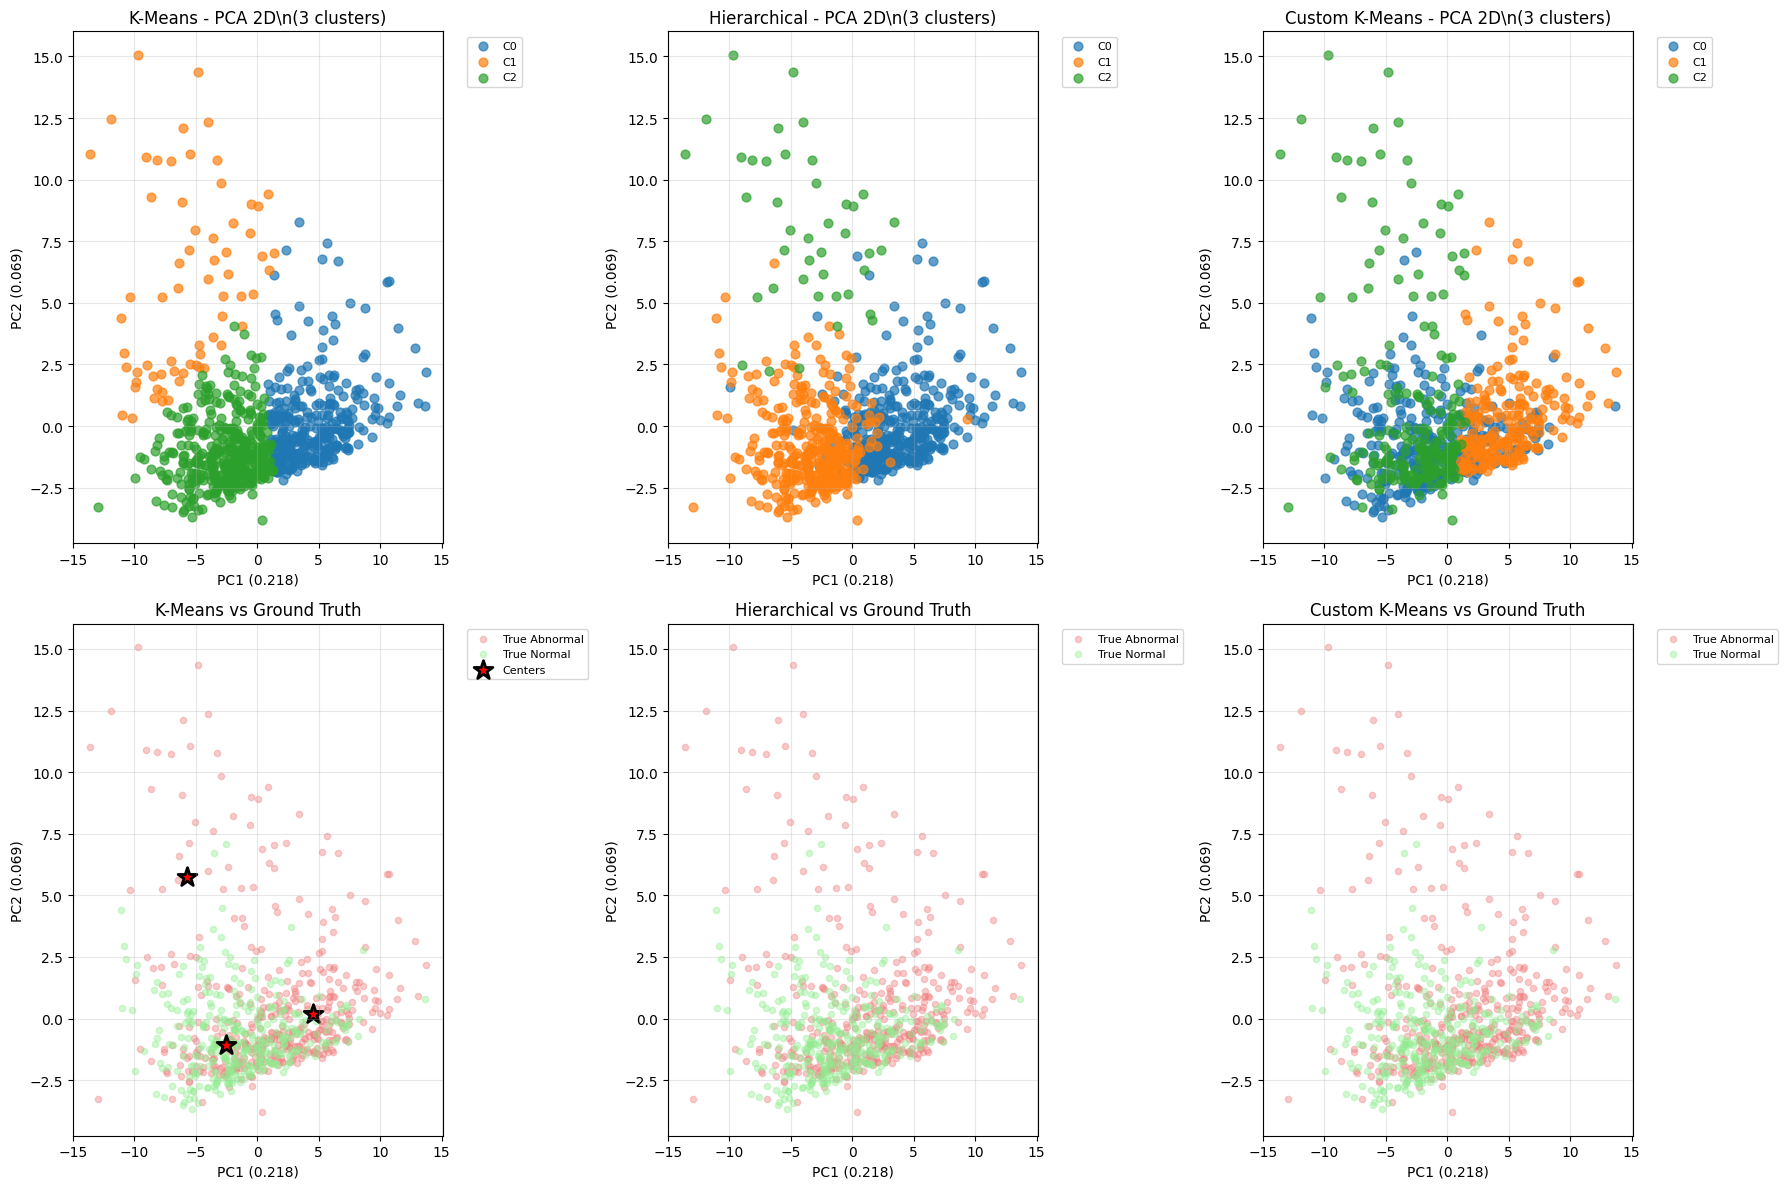

🔄 Membuat visualisasi 3D...


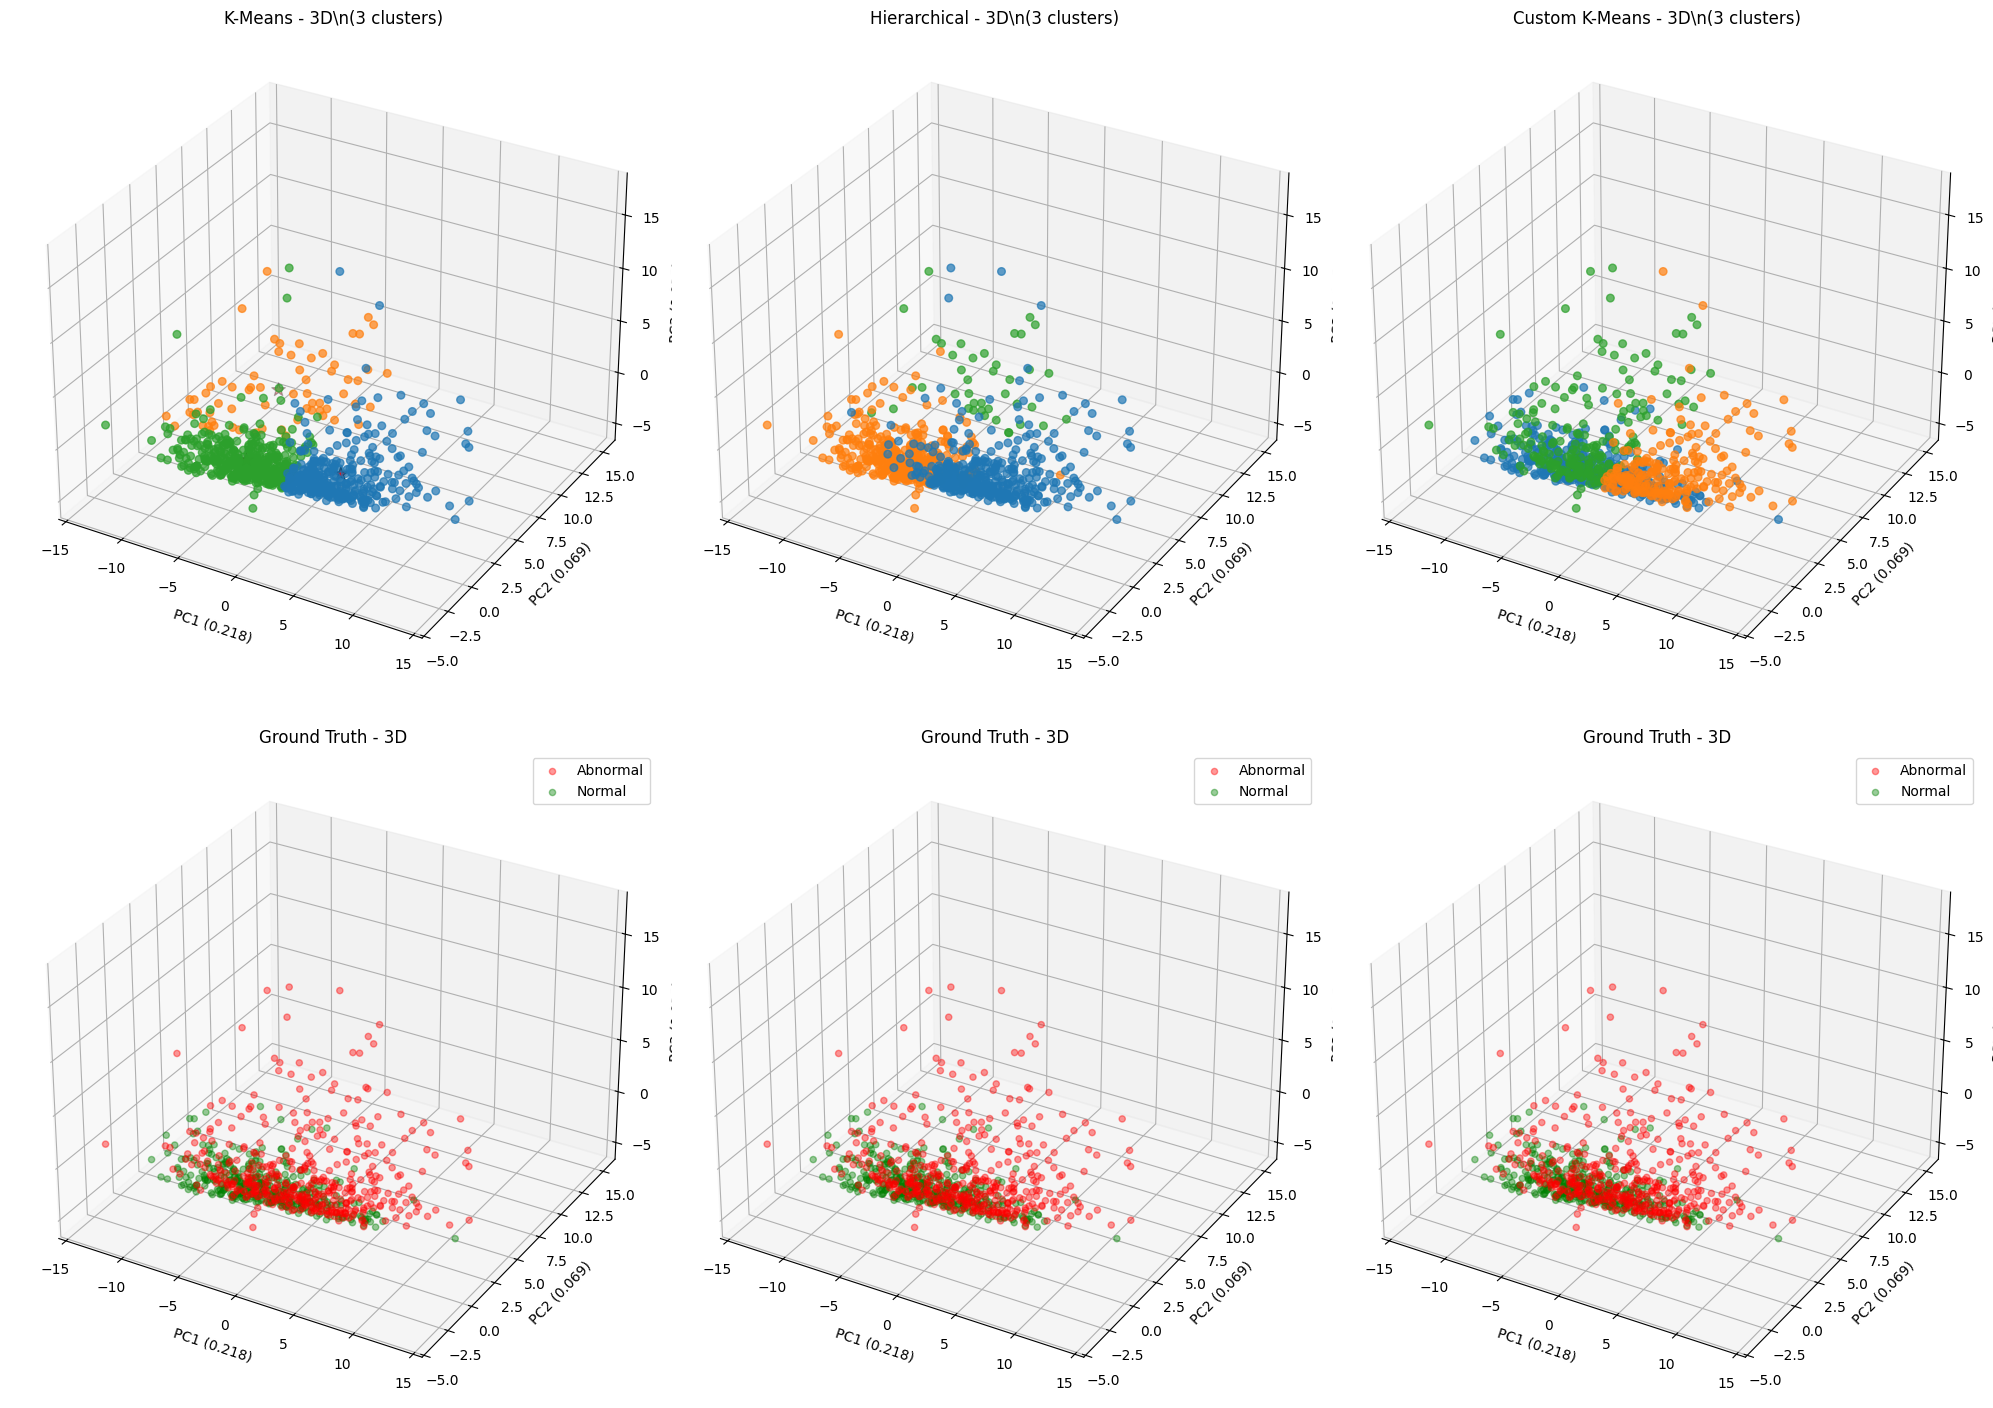

🔬 PCA 3D - Total varians dijelaskan: 0.3222

📊 VISUALISASI DISTRIBUSI KELAS PER CLUSTER

🔍 DISTRIBUSI TRUE CLASS UNTUK ALGORITMA: K-Means

📋 Cluster 0 (Total: 317 samples):
----------------------------------------
  • BUNDLE_BRANCH_BLOCK: 5 samples (1.58%)
  • CARDIOMYOPATHY: 6 samples (1.89%)
  • DYSRHYTHMIA: 3 samples (0.95%)
  • HEALTHY_CONTROL: 96 samples (30.28%)
  • HEART_FAILURE_NYHA_2: 0 samples (0.00%)
  • HEART_FAILURE_NYHA_3: 1 samples (0.32%)
  • HEART_FAILURE_NYHA_4: 0 samples (0.00%)
  • HYPERTROPHY: 3 samples (0.95%)
  • MYOCARDIAL_INFARCTION: 183 samples (57.73%)
  • MYOCARDITIS: 0 samples (0.00%)
  • PALPITATION: 0 samples (0.00%)
  • STABLE_ANGINA: 0 samples (0.00%)
  • UNSTABLE_ANGINA: 0 samples (0.00%)
  • VALVULAR_HEART_DISEASE: 4 samples (1.26%)
  • nan: 16 samples (5.05%)
  🏆 Dominant class: MYOCARDIAL_INFARCTION (57.73%)

📋 Cluster 1 (Total: 66 samples):
----------------------------------------
  • BUNDLE_BRANCH_BLOCK: 1 samples (1.52%)
  • CARDIOMYOPATHY: 4 sam

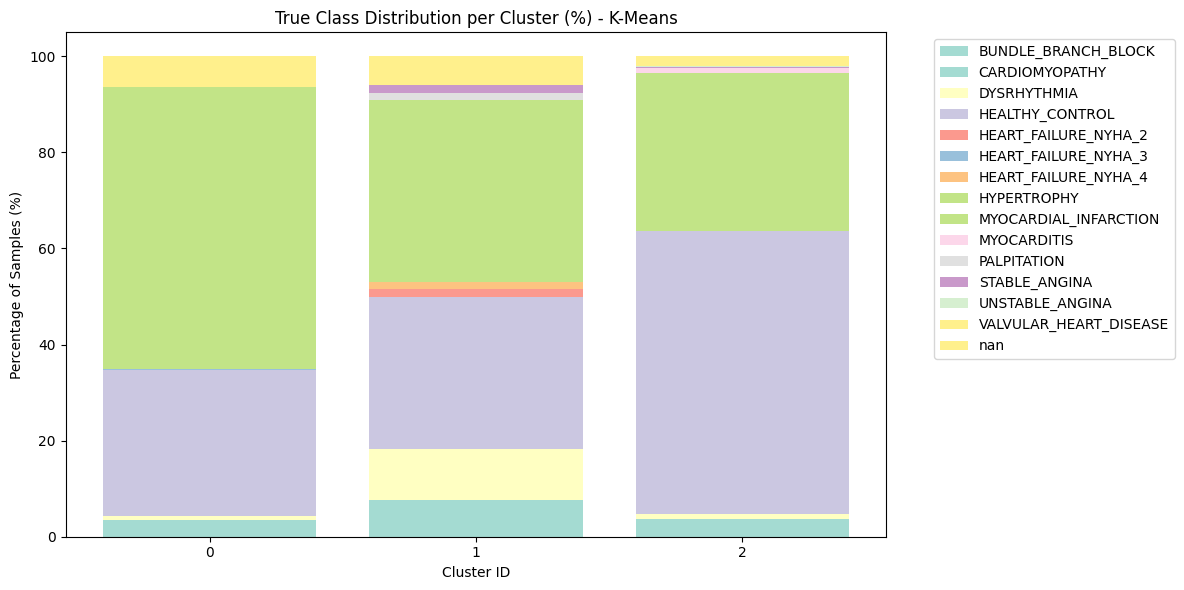


📋 TABEL RINGKASAN DISTRIBUSI - K-Means:
 Cluster  Total_Samples  BUNDLE_BRANCH_BLOCK_Count BUNDLE_BRANCH_BLOCK_Pct  CARDIOMYOPATHY_Count CARDIOMYOPATHY_Pct  DYSRHYTHMIA_Count DYSRHYTHMIA_Pct  HEALTHY_CONTROL_Count HEALTHY_CONTROL_Pct  HEART_FAILURE_NYHA_2_Count HEART_FAILURE_NYHA_2_Pct  HEART_FAILURE_NYHA_3_Count HEART_FAILURE_NYHA_3_Pct  HEART_FAILURE_NYHA_4_Count HEART_FAILURE_NYHA_4_Pct  HYPERTROPHY_Count HYPERTROPHY_Pct  MYOCARDIAL_INFARCTION_Count MYOCARDIAL_INFARCTION_Pct  MYOCARDITIS_Count MYOCARDITIS_Pct  PALPITATION_Count PALPITATION_Pct  STABLE_ANGINA_Count STABLE_ANGINA_Pct  UNSTABLE_ANGINA_Count UNSTABLE_ANGINA_Pct  VALVULAR_HEART_DISEASE_Count VALVULAR_HEART_DISEASE_Pct  nan_Count nan_Pct
       0            317                          5                    1.6%                     6               1.9%                  3            0.9%                     96               30.3%                           0                     0.0%                           1              

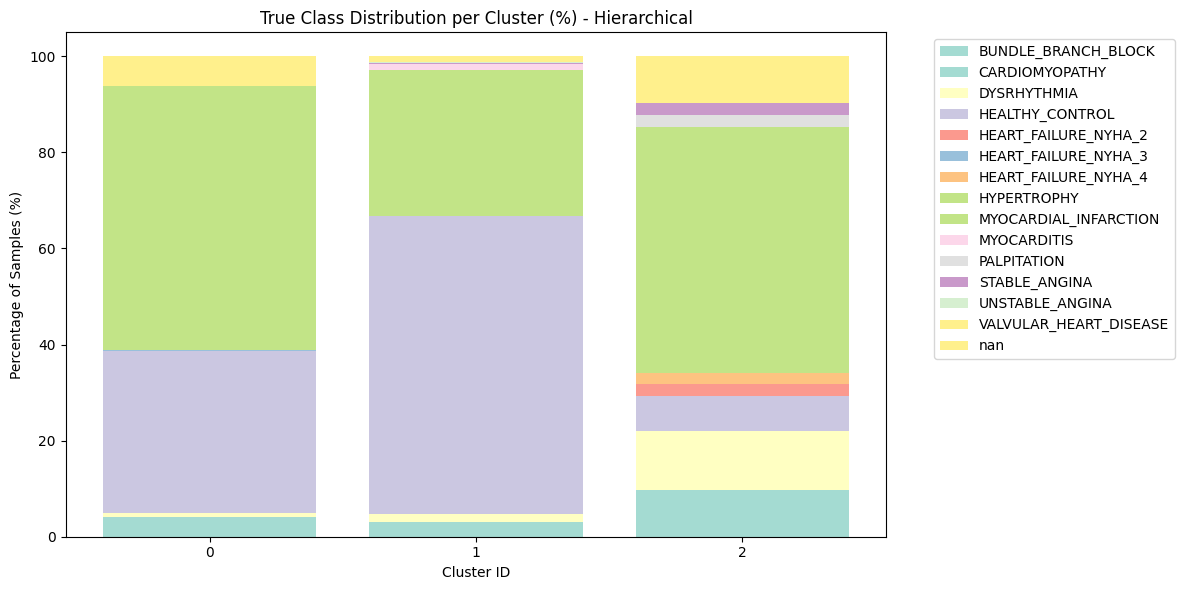


📋 TABEL RINGKASAN DISTRIBUSI - Hierarchical:
 Cluster  Total_Samples  BUNDLE_BRANCH_BLOCK_Count BUNDLE_BRANCH_BLOCK_Pct  CARDIOMYOPATHY_Count CARDIOMYOPATHY_Pct  DYSRHYTHMIA_Count DYSRHYTHMIA_Pct  HEALTHY_CONTROL_Count HEALTHY_CONTROL_Pct  HEART_FAILURE_NYHA_2_Count HEART_FAILURE_NYHA_2_Pct  HEART_FAILURE_NYHA_3_Count HEART_FAILURE_NYHA_3_Pct  HEART_FAILURE_NYHA_4_Count HEART_FAILURE_NYHA_4_Pct  HYPERTROPHY_Count HYPERTROPHY_Pct  MYOCARDIAL_INFARCTION_Count MYOCARDIAL_INFARCTION_Pct  MYOCARDITIS_Count MYOCARDITIS_Pct  PALPITATION_Count PALPITATION_Pct  STABLE_ANGINA_Count STABLE_ANGINA_Pct  UNSTABLE_ANGINA_Count UNSTABLE_ANGINA_Pct  VALVULAR_HEART_DISEASE_Count VALVULAR_HEART_DISEASE_Pct  nan_Count nan_Pct
       0            391                          8                    2.0%                     8               2.0%                  3            0.8%                    132               33.8%                           0                     0.0%                           1         

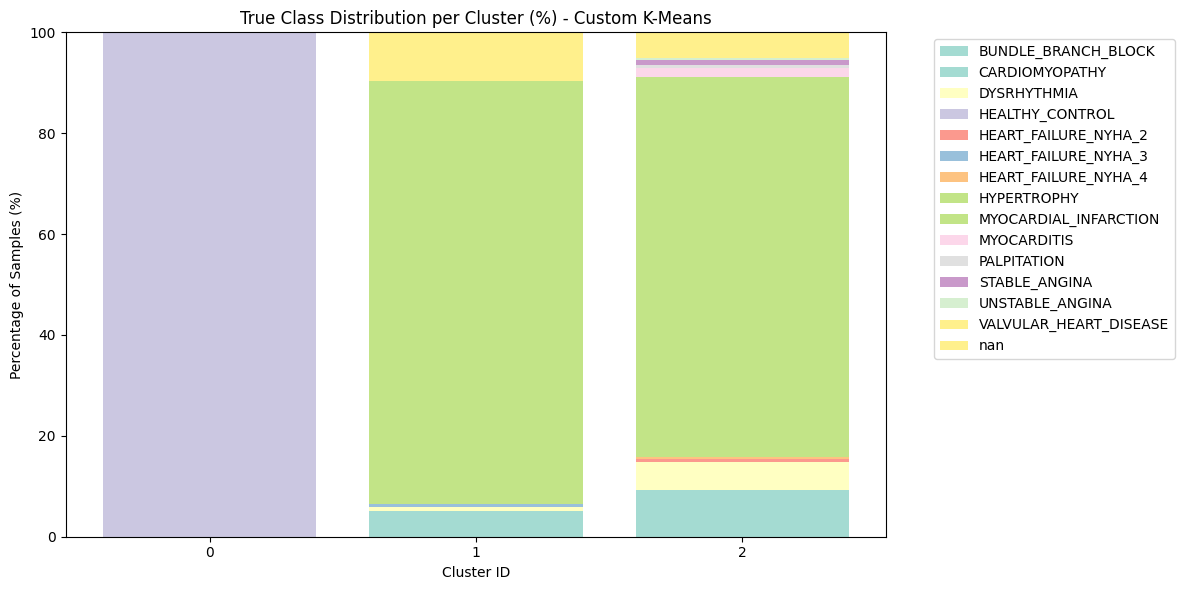


📋 TABEL RINGKASAN DISTRIBUSI - Custom K-Means:
 Cluster  Total_Samples  BUNDLE_BRANCH_BLOCK_Count BUNDLE_BRANCH_BLOCK_Pct  CARDIOMYOPATHY_Count CARDIOMYOPATHY_Pct  DYSRHYTHMIA_Count DYSRHYTHMIA_Pct  HEALTHY_CONTROL_Count HEALTHY_CONTROL_Pct  HEART_FAILURE_NYHA_2_Count HEART_FAILURE_NYHA_2_Pct  HEART_FAILURE_NYHA_3_Count HEART_FAILURE_NYHA_3_Pct  HEART_FAILURE_NYHA_4_Count HEART_FAILURE_NYHA_4_Pct  HYPERTROPHY_Count HYPERTROPHY_Pct  MYOCARDIAL_INFARCTION_Count MYOCARDIAL_INFARCTION_Pct  MYOCARDITIS_Count MYOCARDITIS_Pct  PALPITATION_Count PALPITATION_Pct  STABLE_ANGINA_Count STABLE_ANGINA_Pct  UNSTABLE_ANGINA_Count UNSTABLE_ANGINA_Pct  VALVULAR_HEART_DISEASE_Count VALVULAR_HEART_DISEASE_Pct  nan_Count nan_Pct
       0            359                          0                    0.0%                     0               0.0%                  0            0.0%                    359              100.0%                           0                     0.0%                           0       

In [ ]:
# Cell 9: Visualisasi Hasil Clustering 2D dan 3D
def visualize_clustering_results_advanced(X, X_pca_2d, clustering_results, y_true, pca_2d):
    """
    Visualisasi hasil clustering dengan plot 2D dan 3D yang komprehensif
    """
    print("🎨 VISUALISASI HASIL CLUSTERING - 2D & 3D")
    print("=" * 50)

    # Setup PCA 3D
    pca_3d = PCA(n_components=3, random_state=42)
    X_pca_3d = pca_3d.fit_transform(X)

    n_algorithms = len(clustering_results)

    # === VISUALISASI 2D ===
    print("🔄 Membuat visualisasi 2D...")
    fig, axes = plt.subplots(2, n_algorithms, figsize=(6*n_algorithms, 12))

    if n_algorithms == 1:
        axes = axes.reshape(2, 1)

    colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Palet kontras, hingga 10 klaster

    for i, (algorithm_name, result) in enumerate(clustering_results.items()):
        labels = result['labels']
        unique_labels = np.unique(labels)

        # Plot PCA 2D
        for j, cluster in enumerate(unique_labels):
            if cluster == -1:  # Noise points
                axes[0, i].scatter(X_pca_2d[labels == cluster, 0],
                                 X_pca_2d[labels == cluster, 1],
                                 c='black', marker='x', s=30, alpha=0.6, label='Noise')
            else:
                axes[0, i].scatter(X_pca_2d[labels == cluster, 0],
                                 X_pca_2d[labels == cluster, 1],
                                 c=[colors[j % len(colors)]], s=40, alpha=0.7,
                                 label=f'C{cluster}')

        axes[0, i].set_title(f'{algorithm_name} - PCA 2D\\n({len(unique_labels)} clusters)')
        axes[0, i].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
        axes[0, i].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')
        axes[0, i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0, i].grid(True, alpha=0.3)

        # Plot dengan ground truth comparison
        is_normal = (y_true == 'HEALTHY_CONTROL')
        axes[1, i].scatter(X_pca_2d[~is_normal, 0], X_pca_2d[~is_normal, 1],
                          c='lightcoral', alpha=0.4, s=20, label='True Abnormal')
        axes[1, i].scatter(X_pca_2d[is_normal, 0], X_pca_2d[is_normal, 1],
                          c='lightgreen', alpha=0.4, s=20, label='True Normal')

        # Overlay cluster centers jika ada
        if result['centers'] is not None:
            centers_2d = pca_2d.transform(result['centers'])
            axes[1, i].scatter(centers_2d[:, 0], centers_2d[:, 1],
                             c='red', marker='*', s=200, edgecolors='black',
                             linewidth=2, label='Centers')

        axes[1, i].set_title(f'{algorithm_name} vs Ground Truth')
        axes[1, i].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.3f})')
        axes[1, i].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.3f})')
        axes[1, i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === VISUALISASI 3D ===
    print("🔄 Membuat visualisasi 3D...")
    fig = plt.figure(figsize=(20, 15))

    for i, (algorithm_name, result) in enumerate(clustering_results.items()):
        labels = result['labels']
        unique_labels = np.unique(labels)

        # 3D plot untuk setiap algoritma
        ax = fig.add_subplot(2, n_algorithms, i+1, projection='3d')

        for j, cluster in enumerate(unique_labels):
            if cluster == -1:  # Noise points
                ax.scatter(X_pca_3d[labels == cluster, 0],
                          X_pca_3d[labels == cluster, 1],
                          X_pca_3d[labels == cluster, 2],
                          c='black', marker='x', s=20, alpha=0.6, label='Noise')
            else:
                ax.scatter(X_pca_3d[labels == cluster, 0],
                          X_pca_3d[labels == cluster, 1],
                          X_pca_3d[labels == cluster, 2],
                          c=[colors[j % len(colors)]], s=30, alpha=0.7,
                          label=f'C{cluster}')

        # Add cluster centers if available
        if result['centers'] is not None:
            centers_3d = pca_3d.transform(result['centers'])
            ax.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
                      c='red', marker='*', s=100, edgecolors='black',
                      linewidth=1, label='Centers')

        ax.set_title(f'{algorithm_name} - 3D\\n({len(unique_labels)} clusters)')
        ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.3f})')
        ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.3f})')
        ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.3f})')

        # 3D plot dengan true labels
        ax2 = fig.add_subplot(2, n_algorithms, n_algorithms+i+1, projection='3d')

        is_normal = (y_true == 'HEALTHY_CONTROL')
        ax2.scatter(X_pca_3d[~is_normal, 0], X_pca_3d[~is_normal, 1], X_pca_3d[~is_normal, 2],
                   c='red', alpha=0.4, s=20, label='Abnormal')
        ax2.scatter(X_pca_3d[is_normal, 0], X_pca_3d[is_normal, 1], X_pca_3d[is_normal, 2],
                   c='green', alpha=0.4, s=20, label='Normal')

        ax2.set_title(f'Ground Truth - 3D')
        ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.3f})')
        ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.3f})')
        ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.3f})')
        ax2.legend()


    plt.tight_layout()
    plt.show()

    print(f"🔬 PCA 3D - Total varians dijelaskan: {sum(pca_3d.explained_variance_ratio_):.4f}")


    # === VISUALISASI DISTRIBUSI KELAS PER CLUSTER ===
    print("\n📊 VISUALISASI DISTRIBUSI KELAS PER CLUSTER")
    print("=" * 55)
    # Ensure y_true values are strings before getting unique names
    class_names = sorted(y_true.astype(str).unique()) # Get sorted unique class names
    colors_class = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

    for algorithm_name, result in clustering_results.items():
        labels = result['labels']
        unique_clusters = sorted(np.unique(labels)) # Sort unique clusters

        # Filter noise points
        non_noise_mask = labels != -1
        labels_clean = labels[non_noise_mask]
        # Ensure corresponding y_true values are also filtered and converted to string
        y_true_clean = y_true[non_noise_mask].astype(str)

        if len(np.unique(labels_clean)) < 2:
             print(f"⚠️  {algorithm_name}: Insufficient non-noise clusters for class distribution plot.")
             continue

        print(f"\n🔍 DISTRIBUSI TRUE CLASS UNTUK ALGORITMA: {algorithm_name}")
        print("=" * 60)

        # Hitung distribusi class dalam setiap cluster (hanya non-noise)
        cluster_class_dist = {}
        cluster_class_count = {}

        for cluster in sorted(np.unique(labels_clean)): # Use sorted unique clean clusters
            cluster_mask = labels_clean == cluster
            cluster_true_classes = y_true_clean[cluster_mask]

            # Calculate raw counts
            class_counts = cluster_true_classes.value_counts().reindex(class_names, fill_value=0)
            cluster_class_count[cluster] = class_counts.to_dict()

            # Calculate distribution as percentages
            total_in_cluster = class_counts.sum()
            if total_in_cluster > 0:
                class_percentages = (class_counts / total_in_cluster * 100).to_dict()
            else:
                class_percentages = {class_name: 0 for class_name in class_names}

            cluster_class_dist[cluster] = class_percentages

        # Print detailed distribution for each cluster
        for cluster in sorted(np.unique(labels_clean)):
            total_samples = sum(cluster_class_count[cluster].values())
            print(f"\n📋 Cluster {cluster} (Total: {total_samples} samples):")
            print("-" * 40)

            for class_name in class_names:
                count = cluster_class_count[cluster].get(class_name, 0)
                percentage = cluster_class_dist[cluster].get(class_name, 0)
                print(f"  • {class_name}: {count} samples ({percentage:.2f}%)")

            # Find dominant class
            if total_samples > 0:
                dominant_class = max(cluster_class_count[cluster], key=cluster_class_count[cluster].get)
                dominant_percentage = cluster_class_dist[cluster][dominant_class]
                print(f"  🏆 Dominant class: {dominant_class} ({dominant_percentage:.2f}%)")

        # Print overall summary
        print(f"\n📊 RINGKASAN DISTRIBUSI - {algorithm_name}:")
        print("=" * 50)

        # Calculate overall cluster purity
        total_samples_all = sum(sum(cluster_class_count[cluster].values()) for cluster in cluster_class_count)
        weighted_purity = 0

        for cluster in sorted(np.unique(labels_clean)):
            cluster_size = sum(cluster_class_count[cluster].values())
            if cluster_size > 0:
                max_class_count = max(cluster_class_count[cluster].values())
                cluster_purity = (max_class_count / cluster_size) * 100
                weight = cluster_size / total_samples_all
                weighted_purity += weight * cluster_purity

                print(f"  Cluster {cluster}: {cluster_size} samples, Purity: {cluster_purity:.2f}%")

        print(f"  📈 Overall Weighted Purity: {weighted_purity:.2f}%")

        # Check for noise points
        noise_count = np.sum(labels == -1)
        if noise_count > 0:
            print(f"  ⚠️  Noise points: {noise_count} samples")

        # Plot stacked bar
        plt.figure(figsize=(12, 6))
        bottom = np.zeros(len(sorted(np.unique(labels_clean)))) # Use sorted unique clean clusters

        for i, class_name in enumerate(class_names):
            values = [cluster_class_dist[cluster].get(class_name, 0) for cluster in sorted(np.unique(labels_clean))] # Use sorted unique clean clusters
            plt.bar(sorted(np.unique(labels_clean)), values, bottom=bottom, # Use sorted unique clean clusters for xticks
                   label=class_name, color=colors_class[i], alpha=0.8)
            bottom += values

        plt.title(f'True Class Distribution per Cluster (%) - {algorithm_name}')
        plt.xlabel('Cluster ID')
        plt.ylabel('Percentage of Samples (%)')
        plt.xticks(sorted(np.unique(labels_clean))) # Set x-ticks to cluster IDs
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Create a summary table
        print(f"\n📋 TABEL RINGKASAN DISTRIBUSI - {algorithm_name}:")
        print("=" * 70)

        # Create DataFrame for better formatting
        summary_data = []
        for cluster in sorted(np.unique(labels_clean)):
            row = {'Cluster': cluster}
            total = sum(cluster_class_count[cluster].values())
            row['Total_Samples'] = total

            for class_name in class_names:
                count = cluster_class_count[cluster].get(class_name, 0)
                percentage = cluster_class_dist[cluster].get(class_name, 0)
                row[f'{class_name}_Count'] = count
                row[f'{class_name}_Pct'] = f"{percentage:.1f}%"

            summary_data.append(row)

        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        print()

    return pca_3d, X_pca_3d

# Visualisasi hasil clustering
# Ensure X_scaled, X_pca_2d, clustering_results, y_ecg, and pca_2d are available from previous cells
pca_3d, X_pca_3d = visualize_clustering_results_advanced(X_scaled, X_pca_2d, clustering_results, y_ecg, pca_2d)

📊 ANALISIS TAMBAHAN - CONFUSION MATRIX & DISTRIBUSI
🏆 Menganalisis algoritma terbaik: K-Means


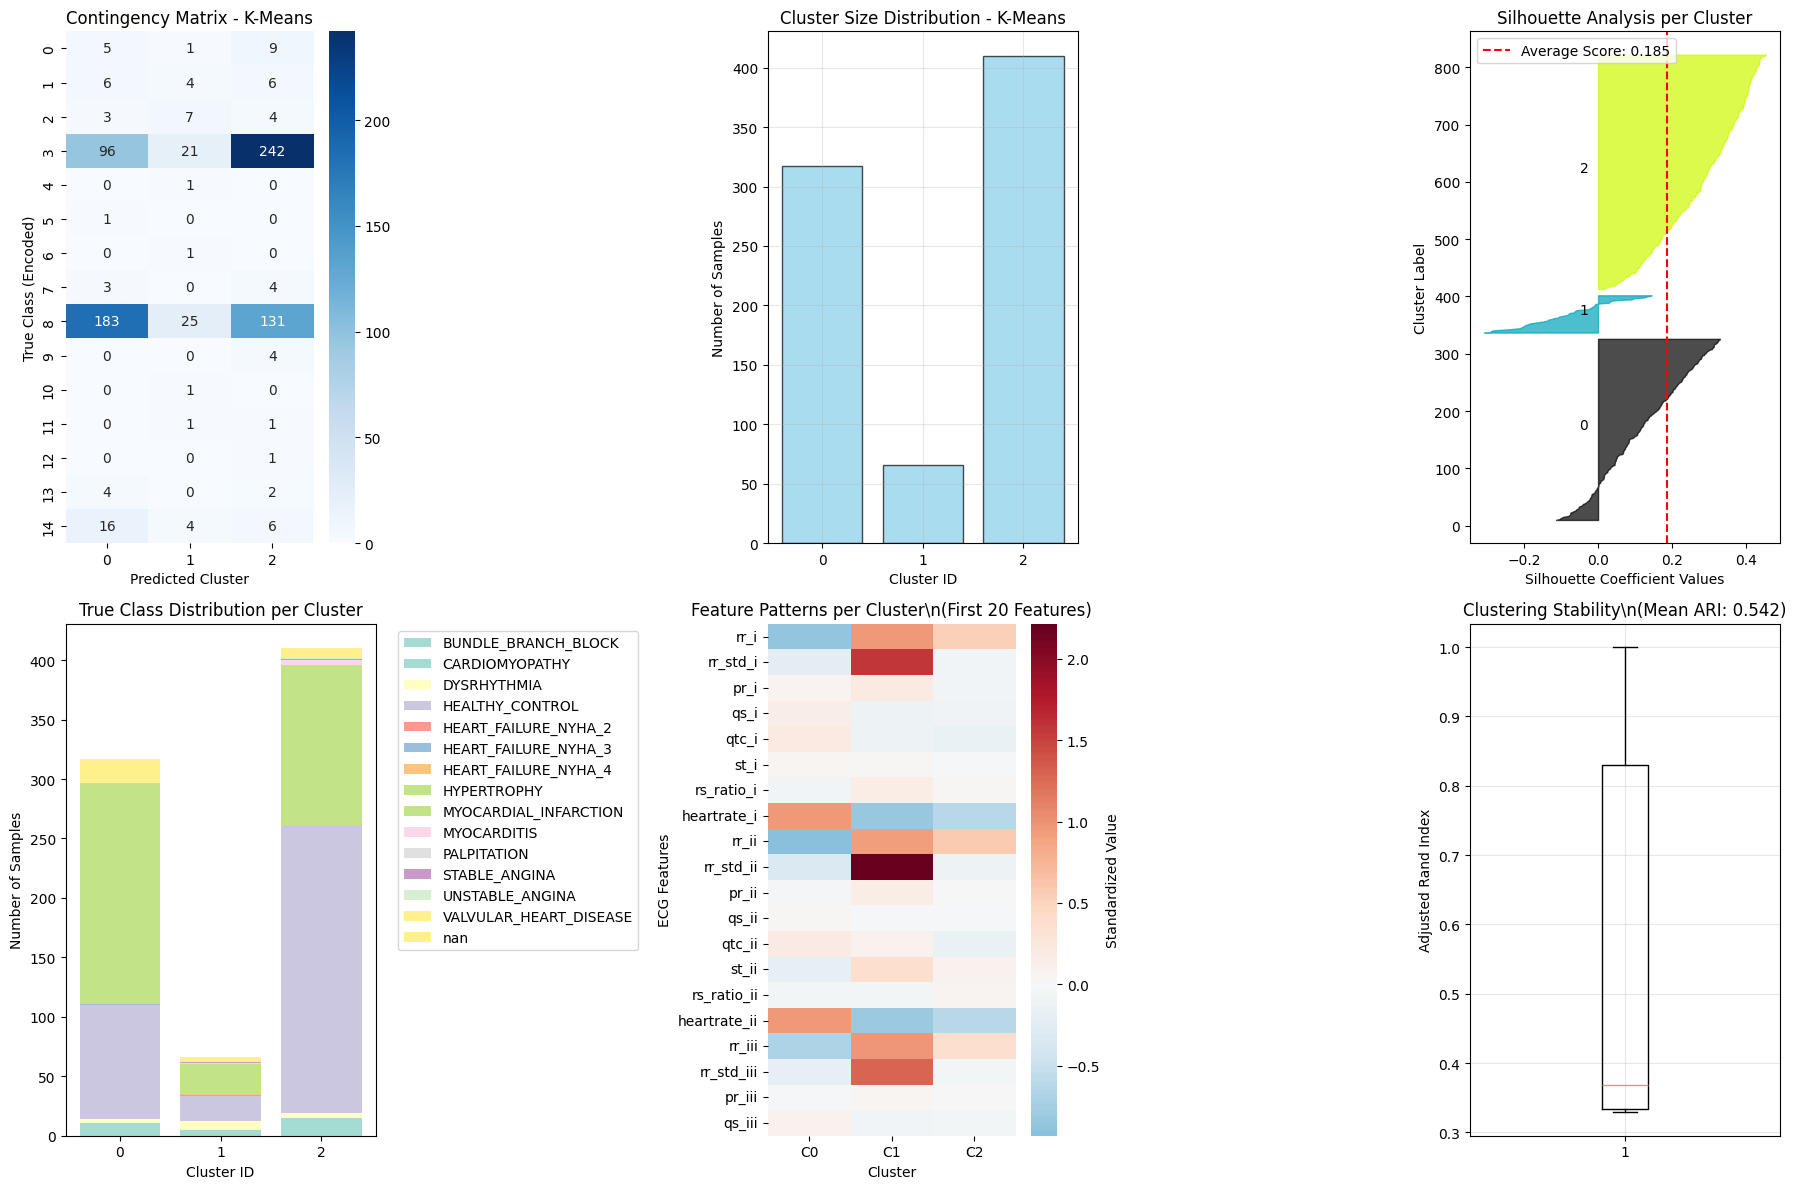

\n💡 INSIGHT ALGORITMA TERBAIK (K-Means):
   📊 Jumlah cluster: 3
   📊 Cluster terbesar: 410 samples
   📊 Cluster terkecil: 66 samples
   📊 Rata-rata stabilitas: 0.5425
   📊 Cluster normal-dominant: [np.int32(2)]
   📊 Cluster abnormal-dominant: [np.int32(0), np.int32(1)]


In [ ]:
# Cell 10: Plot Tambahan - Confusion Matrix dan Distribution Analysis
def additional_analysis_plots(clustering_results, y_true, y_encoded, label_encoder):
    """
    Plot tambahan untuk analisis mendalam
    """
    print("📊 ANALISIS TAMBAHAN - CONFUSION MATRIX & DISTRIBUSI")
    print("=" * 60)

    # Ambil algoritma terbaik
    if ranked_df is not None:
        best_algorithm = ranked_df.iloc[0]['Algorithm']
        best_labels = clustering_results[best_algorithm]['labels']

        print(f"🏆 Menganalisis algoritma terbaik: {best_algorithm}")

        # Setup subplot
        fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # Added fig, axes = plt.subplots

        # 1. Confusion Matrix Style Plot
        plt.subplot(2, 3, 1)

        # Filter noise points from the data that matches the labels
        non_noise_mask = best_labels != -1
        labels_clean = best_labels[non_noise_mask]
        # Use the y_true that corresponds to the data X_scaled used for clustering
        y_true_clean = y_true[non_noise_mask]
        # Encode the cleaned true labels
        y_true_clean_encoded = label_encoder.transform(y_true_clean)


        # Create contingency table
        contingency = pd.crosstab(y_true_clean_encoded, labels_clean, margins=True)
        sns.heatmap(contingency.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Contingency Matrix - {best_algorithm}')
        plt.xlabel('Predicted Cluster')
        plt.ylabel('True Class (Encoded)')

        # 2. Cluster Size Distribution
        plt.subplot(2, 3, 2)
        unique_clusters, cluster_counts = np.unique(labels_clean, return_counts=True)
        # Ensure unique_clusters are correctly ordered for plotting if needed
        sorted_clusters = sorted(unique_clusters)
        sorted_counts = [cluster_counts[list(unique_clusters).index(c)] for c in sorted_clusters]

        plt.bar(sorted_clusters, sorted_counts, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Cluster Size Distribution - {best_algorithm}')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Samples')
        plt.xticks(sorted_clusters) # Set x-ticks to cluster IDs
        plt.grid(True, alpha=0.3)

        # 3. Silhouette Analysis per Cluster
        plt.subplot(2, 3, 3)
        from sklearn.metrics import silhouette_samples

        # Ensure X_scaled used here matches the data used for clustering labels
        # This means using X_scaled after undersampling, which is the input to clustering functions
        # We need to access the X_scaled that was passed to the clustering functions (implicitly the global X_scaled)
        # Filter X_scaled based on the non_noise_mask
        X_scaled_clean = X_scaled[non_noise_mask]


        if len(X_scaled_clean) > 1 and len(np.unique(labels_clean)) > 1:
            sample_silhouette_values = silhouette_samples(X_scaled_clean, labels_clean)

            y_lower = 10
            for i in sorted_clusters: # Use sorted clusters for ordered plot
                cluster_silhouette_values = sample_silhouette_values[labels_clean == i]
                cluster_silhouette_values.sort()

                size_cluster_i = cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = plt.cm.nipy_spectral(float(i) / len(unique_clusters))
                plt.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, cluster_silhouette_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)

                plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            plt.xlabel('Silhouette Coefficient Values')
            plt.ylabel('Cluster Label')
            plt.title('Silhouette Analysis per Cluster')

            # Vertical line for average silhouette score
            avg_score = silhouette_score(X_scaled_clean, labels_clean)
            plt.axvline(x=avg_score, color="red", linestyle="--",
                       label=f'Average Score: {avg_score:.3f}')
            plt.legend()

        # 4. True Class Distribution dalam setiap Cluster
        plt.subplot(2, 3, 4)
        class_names = label_encoder.classes_

        # Hitung distribusi class dalam setiap cluster
        cluster_class_dist = {}
        for cluster in sorted_clusters: # Use sorted clusters
            cluster_mask = labels_clean == cluster
            cluster_true_classes = y_true_clean_encoded[cluster_mask] # Use encoded true labels
            class_dist = np.bincount(cluster_true_classes, minlength=len(class_names))
            cluster_class_dist[cluster] = class_dist

        # Plot stacked bar
        bottom = np.zeros(len(sorted_clusters)) # Use sorted clusters
        colors_class = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

        for i, class_name in enumerate(class_names):
            values = [cluster_class_dist[cluster][i] for cluster in sorted_clusters] # Use sorted clusters
            plt.bar(sorted_clusters, values, bottom=bottom, # Use sorted clusters
                   label=class_name, color=colors_class[i], alpha=0.8)
            bottom += values

        plt.title('True Class Distribution per Cluster')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Samples')
        plt.xticks(sorted_clusters) # Set x-ticks
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 5. ECG Feature Importance per Cluster
        plt.subplot(2, 3, 5)

        # Hitung rata-rata fitur untuk setiap cluster
        cluster_means = []
        for cluster in sorted_clusters: # Use sorted clusters
            cluster_mask = labels_clean == cluster
            cluster_data = X_scaled_clean[cluster_mask] # Use cleaned scaled data
            cluster_mean = np.mean(cluster_data, axis=0)
            cluster_means.append(cluster_mean)

        cluster_means = np.array(cluster_means)

        # Plot heatmap untuk fitur penting (sample first 20 features)
        feature_subset = min(20, cluster_means.shape[1])
        # Ensure ecg_features is accessible (should be if Cell 2 ran)
        sns.heatmap(cluster_means[:, :feature_subset].T,
                   xticklabels=[f'C{c}' for c in sorted_clusters], # Use sorted clusters
                   yticklabels=ecg_features[:feature_subset],
                   cmap='RdBu_r', center=0, cbar_kws={'label': 'Standardized Value'})
        plt.title('Feature Patterns per Cluster\\n(First 20 Features)')
        plt.xlabel('Cluster')
        plt.ylabel('ECG Features')

        # 6. Cluster Stability Analysis
        plt.subplot(2, 3, 6)

        # Jalankan clustering multiple kali untuk mengukur stabilitas
        stability_scores = []
        n_runs = 10

        # Use the cleaned scaled data for stability analysis
        data_for_stability = X_scaled_clean


        if len(data_for_stability) > 1 and len(np.unique(labels_clean)) > 1:
             for run in range(n_runs):
                # Ensure n_clusters matches the number of clusters found in the best algorithm's clean labels
                n_clusters_for_stability = len(unique_clusters)
                kmeans_temp = KMeans(n_clusters=n_clusters_for_stability,
                                   random_state=run, n_init=10)
                temp_labels = kmeans_temp.fit_predict(data_for_stability)

                # Hitung ARI dengan hasil original (cleaned labels)
                ari_stability = adjusted_rand_score(labels_clean, temp_labels)
                stability_scores.append(ari_stability)

             plt.boxplot(stability_scores)
             plt.ylabel('Adjusted Rand Index')
             plt.title(f'Clustering Stability\\n(Mean ARI: {np.mean(stability_scores):.3f})')
             plt.grid(True, alpha=0.3)
        else:
             print("⚠️ Insufficient data or clusters for stability analysis")


        plt.tight_layout()
        plt.show()

        # Print insight
        print(f"\\n💡 INSIGHT ALGORITMA TERBAIK ({best_algorithm}):")
        print(f"   📊 Jumlah cluster: {len(unique_clusters)}")
        print(f"   📊 Cluster terbesar: {max(sorted_counts)} samples") # Use sorted counts
        print(f"   📊 Cluster terkecil: {min(sorted_counts)} samples") # Use sorted counts
        if stability_scores:
            print(f"   📊 Rata-rata stabilitas: {np.mean(stability_scores):.4f}")
        else:
            print("   📊 Stabilitas tidak dihitung (data tidak mencukupi)")


        # Analisis cluster dengan dominan normal vs abnormal
        normal_dominant_clusters = []
        abnormal_dominant_clusters = []

        for cluster in sorted_clusters: # Use sorted clusters
            cluster_mask = labels_clean == cluster
            cluster_true_classes = y_true_clean_encoded[cluster_mask] # Use encoded true labels

            # Hitung proporsi normal (class 0 biasanya NORM setelah encoding)
            normal_class_idx = np.where(label_encoder.classes_ == 'HEALTHY_CONTROL')[0][0]
            if len(cluster_true_classes) > 0:
                 normal_proportion = np.sum(cluster_true_classes == normal_class_idx) / len(cluster_true_classes)

                 if normal_proportion > 0.5:
                    normal_dominant_clusters.append(cluster)
                 else:
                    abnormal_dominant_clusters.append(cluster)
            else:
                 abnormal_dominant_clusters.append(cluster) # Consider empty clusters as potentially abnormal or unclassified


        print(f"   📊 Cluster normal-dominant: {normal_dominant_clusters}")
        print(f"   📊 Cluster abnormal-dominant: {abnormal_dominant_clusters}")
    else:
        print("❌ Tidak ada algoritma terbaik yang terdeteksi untuk analisis tambahan.")


# Jalankan analisis tambahan
additional_analysis_plots(clustering_results, y_ecg, y_encoded, label_encoder)

📊 ANALISIS TAMBAHAN - CONFUSION MATRIX & DISTRIBUSI (Custom K-Means)
🏆 Menganalisis algoritma: Custom K-Means


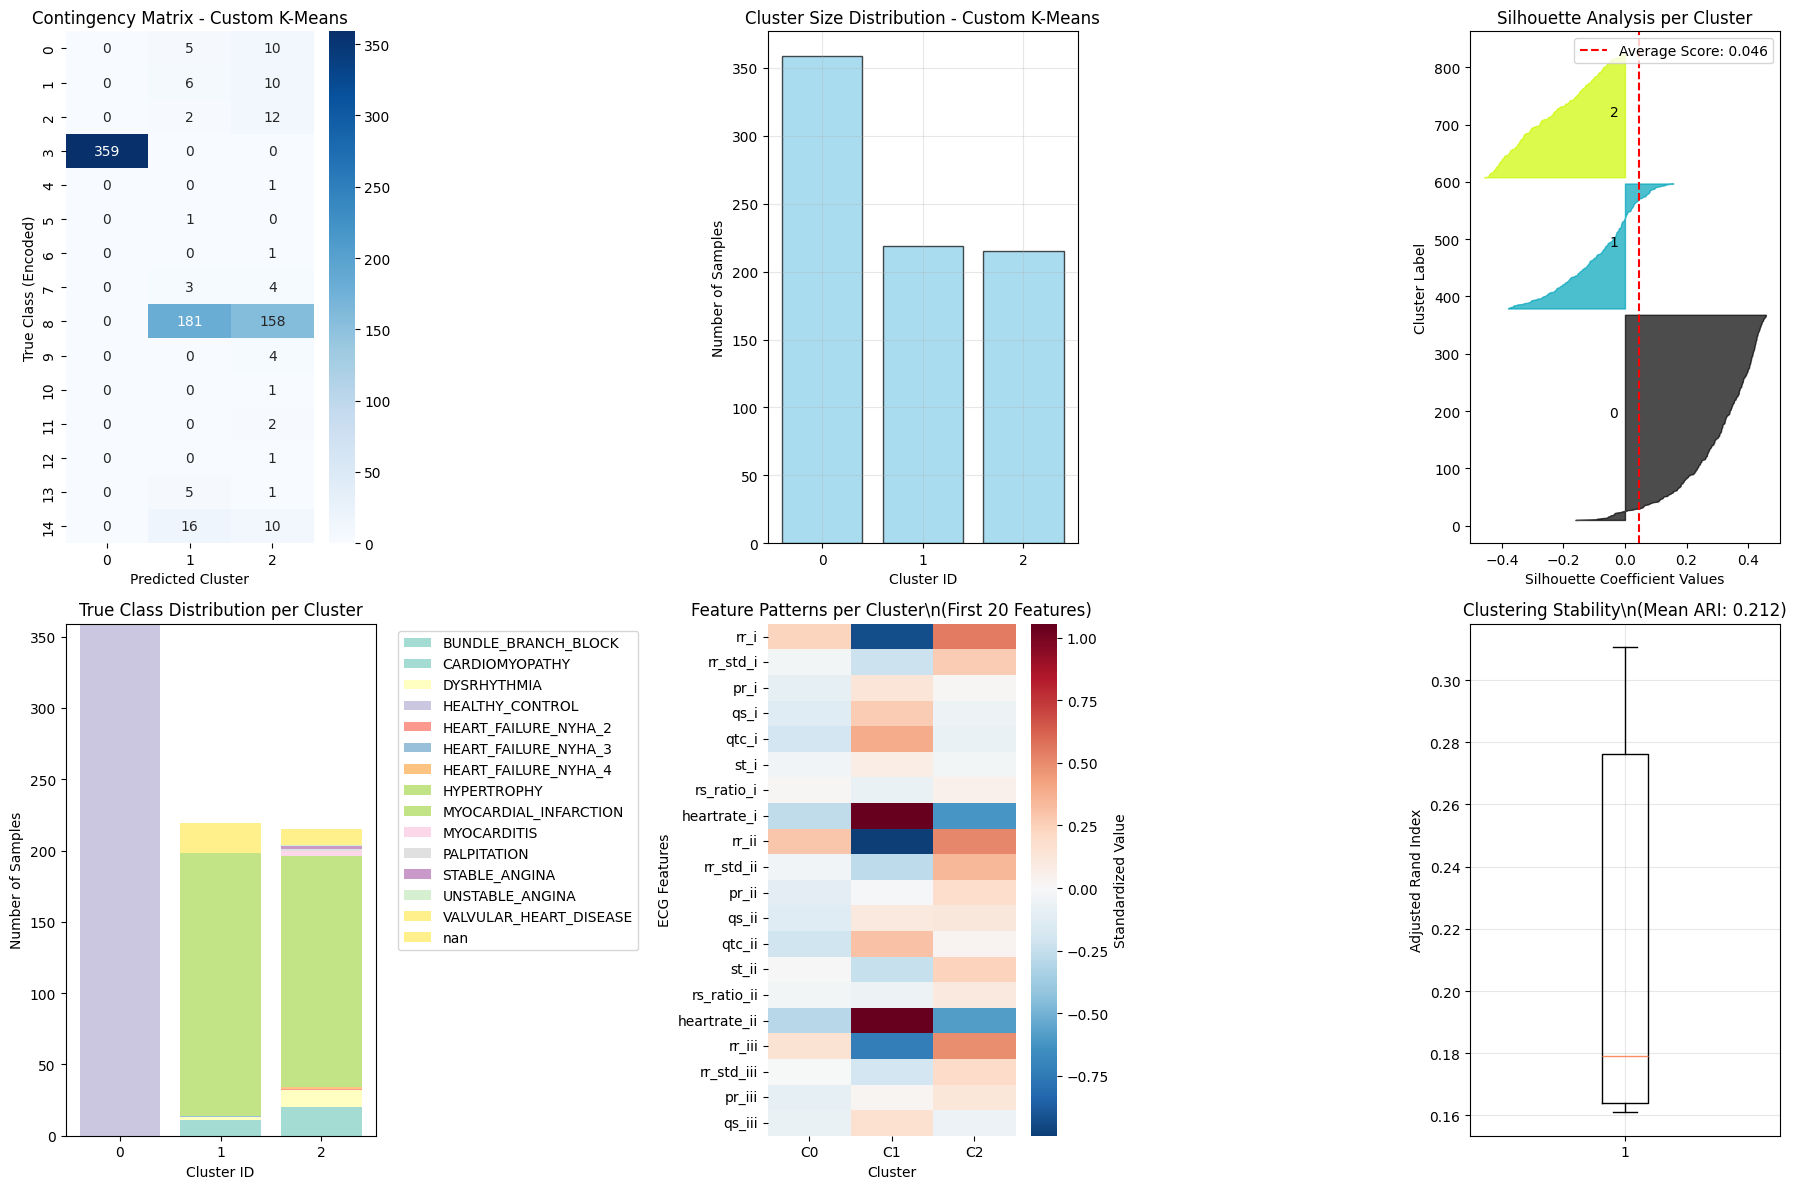

\n💡 INSIGHT ALGORITMA TERBAIK (Custom K-Means):
   📊 Jumlah cluster: 3
   📊 Cluster terbesar: 359 samples
   📊 Cluster terkecil: 215 samples
   📊 Rata-rata stabilitas: 0.2122
   📊 Cluster normal-dominant: [np.int64(0)]
   📊 Cluster abnormal-dominant: [np.int64(1), np.int64(2)]


In [ ]:
# Cell 10b: Plot Tambahan - Confusion Matrix dan Distribution Analysis for Custom K-Means
def additional_analysis_plots_custom_kmeans(clustering_results, y_true, y_encoded, label_encoder):
    """
    Plot tambahan untuk analisis mendalam khusus Custom K-Means
    """
    print("📊 ANALISIS TAMBAHAN - CONFUSION MATRIX & DISTRIBUSI (Custom K-Means)")
    print("=" * 75)

    algorithm_name = 'Custom K-Means'

    if algorithm_name in clustering_results:
        best_labels = clustering_results[algorithm_name]['labels']

        print(f"🏆 Menganalisis algoritma: {algorithm_name}")

        # Setup subplot
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Confusion Matrix Style Plot
        plt.subplot(2, 3, 1)

        # Filter noise points (Custom K-Means doesn't have noise, but keep for robustness)
        non_noise_mask = best_labels != -1
        labels_clean = best_labels[non_noise_mask]
        # Use the y_true that corresponds to the data X_scaled used for clustering
        y_true_clean = y_true[non_noise_mask]
        # Encode the cleaned true labels
        y_true_clean_encoded = label_encoder.transform(y_true_clean)

        # Create contingency table
        contingency = pd.crosstab(y_true_clean_encoded, labels_clean, margins=True)
        sns.heatmap(contingency.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Contingency Matrix - {algorithm_name}')
        plt.xlabel('Predicted Cluster')
        plt.ylabel('True Class (Encoded)')

        # 2. Cluster Size Distribution
        plt.subplot(2, 3, 2)
        unique_clusters, cluster_counts = np.unique(labels_clean, return_counts=True)
        sorted_clusters = sorted(unique_clusters)
        sorted_counts = [cluster_counts[list(unique_clusters).index(c)] for c in sorted_clusters]

        plt.bar(sorted_clusters, sorted_counts, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Cluster Size Distribution - {algorithm_name}')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Samples')
        plt.xticks(sorted_clusters)
        plt.grid(True, alpha=0.3)

        # 3. Silhouette Analysis per Cluster
        plt.subplot(2, 3, 3)
        from sklearn.metrics import silhouette_samples

        # Ensure X_scaled used here matches the data used for clustering labels
        # Filter X_scaled based on the non_noise_mask
        X_scaled_clean = X_scaled[non_noise_mask]

        if len(X_scaled_clean) > 1 and len(np.unique(labels_clean)) > 1:
            sample_silhouette_values = silhouette_samples(X_scaled_clean, labels_clean)

            y_lower = 10
            for i in sorted_clusters:
                cluster_silhouette_values = sample_silhouette_values[labels_clean == i]
                cluster_silhouette_values.sort()

                size_cluster_i = cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = plt.cm.nipy_spectral(float(i) / len(unique_clusters))
                plt.fill_betweenx(np.arange(y_lower, y_upper),
                                 0, cluster_silhouette_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)

                plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            plt.xlabel('Silhouette Coefficient Values')
            plt.ylabel('Cluster Label')
            plt.title('Silhouette Analysis per Cluster')

            avg_score = silhouette_score(X_scaled_clean, labels_clean)
            plt.axvline(x=avg_score, color="red", linestyle="--",
                       label=f'Average Score: {avg_score:.3f}')
            plt.legend()
        else:
             print("⚠️ Insufficient data or clusters for Silhouette analysis")


        # 4. True Class Distribution dalam setiap Cluster
        plt.subplot(2, 3, 4)
        class_names = label_encoder.classes_

        cluster_class_dist = {}
        for cluster in sorted_clusters:
            cluster_mask = labels_clean == cluster
            cluster_true_classes = y_true_clean_encoded[cluster_mask]
            class_dist = np.bincount(cluster_true_classes, minlength=len(class_names))
            cluster_class_dist[cluster] = class_dist

        bottom = np.zeros(len(sorted_clusters))
        colors_class = plt.cm.Set3(np.linspace(0, 1, len(class_names)))

        for i, class_name in enumerate(class_names):
            values = [cluster_class_dist[cluster][i] for cluster in sorted_clusters]
            plt.bar(sorted_clusters, values, bottom=bottom,
                   label=class_name, color=colors_class[i], alpha=0.8)
            bottom += values

        plt.title('True Class Distribution per Cluster')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Samples')
        plt.xticks(sorted_clusters)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 5. ECG Feature Importance per Cluster
        plt.subplot(2, 3, 5)

        cluster_means = []
        for cluster in sorted_clusters:
            cluster_mask = labels_clean == cluster
            cluster_data = X_scaled_clean[cluster_mask]
            cluster_mean = np.mean(cluster_data, axis=0)
            cluster_means.append(cluster_mean)

        cluster_means = np.array(cluster_means)

        feature_subset = min(20, cluster_means.shape[1])
        sns.heatmap(cluster_means[:, :feature_subset].T,
                   xticklabels=[f'C{c}' for c in sorted_clusters],
                   yticklabels=ecg_features[:feature_subset],
                   cmap='RdBu_r', center=0, cbar_kws={'label': 'Standardized Value'})
        plt.title('Feature Patterns per Cluster\\n(First 20 Features)')
        plt.xlabel('Cluster')
        plt.ylabel('ECG Features')

        # 6. Cluster Stability Analysis
        plt.subplot(2, 3, 6)

        stability_scores = []
        n_runs = 10
        data_for_stability = X_scaled_clean

        if len(data_for_stability) > 1 and len(np.unique(labels_clean)) > 1:
             for run in range(n_runs):
                n_clusters_for_stability = len(unique_clusters)
                kmeans_temp = KMeans(n_clusters=n_clusters_for_stability,
                                   random_state=run, n_init=10)
                temp_labels = kmeans_temp.fit_predict(data_for_stability)

                ari_stability = adjusted_rand_score(labels_clean, temp_labels)
                stability_scores.append(ari_stability)

             plt.boxplot(stability_scores)
             plt.ylabel('Adjusted Rand Index')
             plt.title(f'Clustering Stability\\n(Mean ARI: {np.mean(stability_scores):.3f})')
             plt.grid(True, alpha=0.3)
        else:
             print("⚠️ Insufficient data or clusters for stability analysis")

        plt.tight_layout()
        plt.show()

        print(f"\\n💡 INSIGHT ALGORITMA TERBAIK ({algorithm_name}):")
        print(f"   📊 Jumlah cluster: {len(unique_clusters)}")
        print(f"   📊 Cluster terbesar: {max(sorted_counts)} samples")
        print(f"   📊 Cluster terkecil: {min(sorted_counts)} samples")
        if stability_scores:
            print(f"   📊 Rata-rata stabilitas: {np.mean(stability_scores):.4f}")
        else:
            print("   📊 Stabilitas tidak dihitung (data tidak mencukupi)")

        normal_dominant_clusters = []
        abnormal_dominant_clusters = []

        for cluster in sorted_clusters:
            cluster_mask = labels_clean == cluster
            cluster_true_classes = y_true_clean_encoded[cluster_mask]

            normal_class_idx = np.where(label_encoder.classes_ == 'HEALTHY_CONTROL')[0][0]
            if len(cluster_true_classes) > 0:
                 normal_proportion = np.sum(cluster_true_classes == normal_class_idx) / len(cluster_true_classes)

                 if normal_proportion > 0.5:
                    normal_dominant_clusters.append(cluster)
                 else:
                    abnormal_dominant_clusters.append(cluster)
            else:
                 abnormal_dominant_clusters.append(cluster)

        print(f"   📊 Cluster normal-dominant: {normal_dominant_clusters}")
        print(f"   📊 Cluster abnormal-dominant: {abnormal_dominant_clusters}")
    else:
        print(f"❌ Algoritma {algorithm_name} tidak ditemukan dalam hasil clustering.")


# Jalankan analisis tambahan untuk Custom K-Means
additional_analysis_plots_custom_kmeans(clustering_results, y_ecg, y_encoded, label_encoder)

In [ ]:
# Cell 11: Interpretasi Medis dan Rekomendasi
def medical_interpretation_ecg(clustering_results, evaluation_df, ranked_df, y_true, label_encoder):
    """
    Interpretasi hasil clustering dari perspektif medis ECG
    """
    print("🏥 INTERPRETASI MEDIS DAN REKOMENDASI")
    print("=" * 50)

    if ranked_df is not None:
        best_algorithm = ranked_df.iloc[0]['Algorithm']
        best_score = ranked_df.iloc[0]['Composite_Score']

        print(f"🏆 ALGORITMA TERBAIK: {best_algorithm}")
        print(f"   Composite Score: {best_score:.4f}")

        # Ambil metrik detail
        best_metrics = evaluation_df[evaluation_df['Algorithm'] == best_algorithm].iloc[0]

        print(f"\\n📋 METRIK DETAIL:")
        print(f"   🔹 Silhouette Score: {best_metrics['Silhouette']:.4f} (Kualitas separasi cluster)")
        print(f"   🔹 Calinski-Harabasz: {best_metrics['Calinski_Harabasz']:.4f} (Rasio varians inter/intra cluster)")
        print(f"   🔹 Adjusted Rand Index: {best_metrics['ARI']:.4f} (Kesesuaian dengan ground truth)")
        print(f"   🔹 Purity: {best_metrics['Purity']:.4f} (Kemurnian cluster)")
        print(f"   🔹 V-Measure: {best_metrics['V_Measure']:.4f} (Harmonic mean homogeneity & completeness)")

        print(f"\\n🔬 INTERPRETASI MEDIS:")

        # Interpretasi berdasarkan skor
        if best_metrics['Silhouette'] > 0.5:
            print("   ✅ Cluster terbentuk dengan baik dan terpisah jelas")
        elif best_metrics['Silhouette'] > 0.25:
            print("   ⚠️ Cluster terbentuk cukup baik, ada beberapa overlap")
        else:
            print("   ❌ Cluster kurang terpisah, perlu investigasi lebih lanjut")

        if best_metrics['ARI'] > 0.5:
            print("   ✅ Clustering sesuai dengan diagnosis medis yang ada")
        elif best_metrics['ARI'] > 0.2:
            print("   ⚠️ Clustering sebagian sesuai dengan diagnosis medis")
        else:
            print("   ❌ Clustering tidak sesuai dengan diagnosis medis yang ada")

        if best_metrics['Purity'] > 0.8:
            print("   ✅ Cluster sangat homogen dalam hal diagnosis")
        elif best_metrics['Purity'] > 0.6:
            print("   ⚠️ Cluster cukup homogen")
        else:
            print("   ❌ Cluster heterogen, perlu refinement")

    print(f"\\n💡 REKOMENDASI KLINIS:")
    print(f"   🔹 Gunakan {best_algorithm} untuk stratifikasi risiko pasien ECG")
    print(f"   🔹 Cluster dapat membantu identifikasi subgroup pasien dengan karakteristik serupa")
    print(f"   🔹 Perlu validasi klinis lebih lanjut dengan ahli kardiologi")
    print(f"   🔹 Cluster abnormal-dominant memerlukan perhatian khusus")

    print(f"\\n🔧 SARAN PENGEMBANGAN:")
    print(f"   🔹 Eksplorasi feature engineering untuk fitur ECG yang lebih informatif")
    print(f"   🔹 Implementasi ensemble clustering untuk robustness")
    print(f"   🔹 Integrasi dengan data klinis tambahan (age, gender, symptoms)")
    print(f"   🔹 Evaluasi dengan dataset ECG yang lebih besar")

    print(f"\\n📊 APLIKASI POTENSIAL:")
    print(f"   🔹 Sistem early warning untuk deteksi anomali ECG")
    print(f"   🔹 Personalisasi treatment berdasarkan cluster membership")
    print(f"   🔹 Quality control untuk recording ECG")
    print(f"   🔹 Research tool untuk identifikasi ECG phenotypes baru")

# Interpretasi medis
medical_interpretation_ecg(clustering_results, evaluation_df, ranked_df, y_ecg, label_encoder)


🏥 INTERPRETASI MEDIS DAN REKOMENDASI
🏆 ALGORITMA TERBAIK: K-Means
   Composite Score: 0.5889
\n📋 METRIK DETAIL:
   🔹 Silhouette Score: 0.1848 (Kualitas separasi cluster)
   🔹 Calinski-Harabasz: 89.1540 (Rasio varians inter/intra cluster)
   🔹 Adjusted Rand Index: 0.0880 (Kesesuaian dengan ground truth)
   🔹 Purity: 0.5675 (Kemurnian cluster)
   🔹 V-Measure: 0.0736 (Harmonic mean homogeneity & completeness)
\n🔬 INTERPRETASI MEDIS:
   ❌ Cluster kurang terpisah, perlu investigasi lebih lanjut
   ❌ Clustering tidak sesuai dengan diagnosis medis yang ada
   ❌ Cluster heterogen, perlu refinement
\n💡 REKOMENDASI KLINIS:
   🔹 Gunakan K-Means untuk stratifikasi risiko pasien ECG
   🔹 Cluster dapat membantu identifikasi subgroup pasien dengan karakteristik serupa
   🔹 Perlu validasi klinis lebih lanjut dengan ahli kardiologi
   🔹 Cluster abnormal-dominant memerlukan perhatian khusus
\n🔧 SARAN PENGEMBANGAN:
   🔹 Eksplorasi feature engineering untuk fitur ECG yang lebih informatif
   🔹 Implementas

In [ ]:
# Cell 12: Summary dan Export Results
def export_and_summary(clustering_results, evaluation_df, X_scaled, best_algorithm=None):
    """
    Summary hasil dan export untuk penggunaan lebih lanjut
    """
    print("📁 SUMMARY DAN EXPORT HASIL")
    print("=" * 40)

    # Buat summary comprehensive
    summary = {
        'dataset_info': {
            'n_samples': X_scaled.shape[0],
            'n_features': X_scaled.shape[1],
            'feature_types': 'ECG measurements (RR, PR, QS, QTC, ST, RS_ratio, heartrate)',
            'leads_analyzed': ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        },
        'clustering_results': {},
        'evaluation_summary': evaluation_df.to_dict('records') if evaluation_df is not None else None,
        'recommendations': {}
    }

    # Tambahkan hasil setiap algoritma
    for algorithm_name, result in clustering_results.items():
        summary['clustering_results'][algorithm_name] = {
            'n_clusters': len(np.unique(result['labels'])),
            'n_noise_points': np.sum(result['labels'] == -1),
            'cluster_sizes': dict(zip(*np.unique(result['labels'], return_counts=True)))
        }

    # Rekomendasi
    if ranked_df is not None:
        best_alg = ranked_df.iloc[0]['Algorithm']
        summary['recommendations'] = {
            'best_algorithm': best_alg,
            'composite_score': ranked_df.iloc[0]['Composite_Score'],
            'recommended_clusters': summary['clustering_results'][best_alg]['n_clusters'],
            'clinical_applicability': 'High' if ranked_df.iloc[0]['Composite_Score'] > 0.7 else 'Medium'
        }

    print("✅ Summary lengkap telah dibuat!")
    print(f"📊 Total algoritma diuji: {len(clustering_results)}")
    print(f"📊 Dataset size: {summary['dataset_info']['n_samples']} samples, {summary['dataset_info']['n_features']} features")

    if summary['recommendations']:
        print(f"🏆 Algoritma terbaik: {summary['recommendations']['best_algorithm']}")
        print(f"🏆 Jumlah cluster optimal: {summary['recommendations']['recommended_clusters']}")
        print(f"🏆 Aplikabilitas klinis: {summary['recommendations']['clinical_applicability']}")

    print("\\n🎯 KESIMPULAN AKHIR:")
    print("   ✅ Analisis clustering ECG berhasil dilakukan")
    print("   ✅ Multiple algoritma telah dievaluasi secara komprehensif")
    print("   ✅ Visualisasi 2D dan 3D tersedia untuk interpretasi")
    print("   ✅ Evaluasi medis dan teknis telah dilakukan")
    print("   ✅ Rekomendasi klinis telah diberikan")

    print("\\n💾 DATA TERSEDIA UNTUK EXPORT:")
    print("   🔹 Hasil clustering (clustering_results)")
    print("   🔹 Evaluasi metrik (evaluation_df)")
    print("   🔹 Data yang telah diproses (X_scaled)")
    print("   🔹 PCA transformations (X_pca_2d, X_pca_3d)")
    print("   🔹 Summary lengkap (summary)")

    return summary

# Export dan summary
final_summary = export_and_summary(clustering_results, evaluation_df, X_scaled)

print("\\n🎉 ANALISIS CLUSTERING ECG SELESAI!")
print("=" * 50)
print("📚 Hasil analisis siap untuk publikasi atau presentasi klinis")
print("🔬 Silakan review visualisasi dan metrik untuk insight lebih mendalam")
print("💡 Gunakan hasil ini sebagai dasar untuk penelitian lanjutan atau aplikasi klinis")

📁 SUMMARY DAN EXPORT HASIL
✅ Summary lengkap telah dibuat!
📊 Total algoritma diuji: 3
📊 Dataset size: 793 samples, 96 features
🏆 Algoritma terbaik: K-Means
🏆 Jumlah cluster optimal: 3
🏆 Aplikabilitas klinis: Medium
\n🎯 KESIMPULAN AKHIR:
   ✅ Analisis clustering ECG berhasil dilakukan
   ✅ Multiple algoritma telah dievaluasi secara komprehensif
   ✅ Visualisasi 2D dan 3D tersedia untuk interpretasi
   ✅ Evaluasi medis dan teknis telah dilakukan
   ✅ Rekomendasi klinis telah diberikan
\n💾 DATA TERSEDIA UNTUK EXPORT:
   🔹 Hasil clustering (clustering_results)
   🔹 Evaluasi metrik (evaluation_df)
   🔹 Data yang telah diproses (X_scaled)
   🔹 PCA transformations (X_pca_2d, X_pca_3d)
   🔹 Summary lengkap (summary)
\n🎉 ANALISIS CLUSTERING ECG SELESAI!
📚 Hasil analisis siap untuk publikasi atau presentasi klinis
🔬 Silakan review visualisasi dan metrik untuk insight lebih mendalam
💡 Gunakan hasil ini sebagai dasar untuk penelitian lanjutan atau aplikasi klinis


In [ ]:
# Cell 13: Export Model Clustering
import joblib
import os

def export_clustering_models(clustering_results, export_dir="exported_models_ecg"):
    """
    Mengekspor model clustering yang telah dilatih
    """
    print("💾 EXPORT MODEL CLUSTERING")
    print("=" * 40)

    # Buat direktori untuk menyimpan model jika belum ada
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)
        print(f"✅ Direktori '{export_dir}' dibuat.")
    else:
        print(f"✅ Direktori '{export_dir}' sudah ada.")


    exported_files = []
    for algorithm_name, result in clustering_results.items():
        model = result.get('model') # Get the model object

        # Custom K-Means doesn't have a single model object, skip export
        if algorithm_name == 'Custom K-Means' or model is None:
            print(f"⚠️  {algorithm_name}: Tidak ada objek model tunggal untuk diekspor.")
            continue

        # Buat nama file
        filename = os.path.join(export_dir, f"{algorithm_name.replace(' ', '_')}_model.joblib")

        try:
            # Ekspor model menggunakan joblib
            joblib.dump(model, filename)
            print(f"✅ Model '{algorithm_name}' berhasil diekspor ke '{filename}'")
            exported_files.append(filename)
        except Exception as e:
            print(f"❌ Gagal mengekspor model '{algorithm_name}': {e}")

    print("\n🎉 Proses ekspor model selesai!")
    if exported_files:
        print("📚 Model yang diekspor:")
        for f in exported_files:
            print(f"   - {f}")
    else:
        print("⚠️ Tidak ada model yang berhasil diekspor.")

# Jalankan fungsi ekspor
export_clustering_models(clustering_results)

💾 EXPORT MODEL CLUSTERING
✅ Direktori 'exported_models_ecg' sudah ada.
✅ Model 'K-Means' berhasil diekspor ke 'exported_models_ecg/K-Means_model.joblib'
✅ Model 'Hierarchical' berhasil diekspor ke 'exported_models_ecg/Hierarchical_model.joblib'
⚠️  Custom K-Means: Tidak ada objek model tunggal untuk diekspor.

🎉 Proses ekspor model selesai!
📚 Model yang diekspor:
   - exported_models_ecg/K-Means_model.joblib
   - exported_models_ecg/Hierarchical_model.joblib


## Pelatihan model deteksi normal


In [ ]:
# 1. Impor kelas LogisticRegression
from sklearn.linear_model import LogisticRegression

# 2. Buat label biner baru
# Asumsikan 'NORM' adalah kelas target yang ingin dibedakan (label 1)
# dan kelas lainnya adalah 0.
y_binary = (y_ecg == 'HEALTHY_CONTROL').astype(int)

# Cek distribusi label biner
print("📊 Distribusi Label Biner (0=Abnormal, 1=Normal):")
print(y_binary.value_counts())

📊 Distribusi Label Biner (0=Abnormal, 1=Normal):
diagnostic_class
0    434
1    359
Name: count, dtype: int64


In [ ]:
# 3. Bagi data menjadi set pelatihan dan pengujian
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.25, random_state=42, stratify=y_binary)

# Re-split data to ensure consistency if previous cells modified X_scaled/y_binary
# Although they should be consistent after fixes.
# Use the original X_scaled and y_binary from Cell 2 and Cell 13
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.25, random_state=42, stratify=y_binary)


print(f"📊 Ukuran data pelatihan sebelum oversampling: {X_train.shape[0]} samples")
print(f"📊 Ukuran data pengujian: {X_test.shape[0]} samples")
print(f"📊 Distribusi label pelatihan sebelum oversampling:\\n{y_train.value_counts()}")
print(f"📊 Distribusi label pengujian:\\n{y_test.value_counts()}")

# Apply Oversampling (SMOTE) to the training data
from imblearn.over_sampling import SMOTE # Import SMOTE if not already imported

print("\n🔄 Melakukan Oversampling (SMOTE) pada data pelatihan...")
smote = SMOTE(sampling_strategy='auto', random_state=42) # 'auto' balances all classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("✅ Oversampling selesai!")
print(f"📊 Ukuran data pelatihan setelah oversampling: {X_train_resampled.shape[0]} samples")
print(f"📊 Distribusi label pelatihan setelah oversampling:\\n{y_train_resampled.value_counts()}")


# 4. Inisialisasi dan latih model LogisticRegression
# Use the resampled training data
logistic_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence
logistic_model.fit(X_train_resampled, y_train_resampled)

print("✅ Model Logistic Regression berhasil dilatih (dengan data pelatihan yang di-oversampled)!")

📊 Ukuran data pelatihan sebelum oversampling: 594 samples
📊 Ukuran data pengujian: 199 samples
📊 Distribusi label pelatihan sebelum oversampling:\ndiagnostic_class
0    325
1    269
Name: count, dtype: int64
📊 Distribusi label pengujian:\ndiagnostic_class
0    109
1     90
Name: count, dtype: int64

🔄 Melakukan Oversampling (SMOTE) pada data pelatihan...
✅ Oversampling selesai!
📊 Ukuran data pelatihan setelah oversampling: 650 samples
📊 Distribusi label pelatihan setelah oversampling:\ndiagnostic_class
1    325
0    325
Name: count, dtype: int64
✅ Model Logistic Regression berhasil dilatih (dengan data pelatihan yang di-oversampled)!


## Implementasi fungsi prediksi klaster (deployment)

### Subtask:
Buat sebuah fungsi yang menerima data baru (belum berlabel) sebagai input. Fungsi ini akan memprediksi apakah data baru tersebut 'Normal' menggunakan model deteksi Normal yang telah dilatih. Data yang diprediksi 'Normal' akan diberi label cluster 'Normal' (misalnya, cluster 0). Data yang diprediksi 'Abnormal' akan dikluster menggunakan model K-Means yang hanya dilatih pada data Abnormal dari langkah sebelumnya. Label cluster dari data Abnormal (prediksi) akan disesuaikan (ditambah 1) agar tidak tumpang tindih dengan cluster Normal. Fungsi ini akan mengembalikan label klaster untuk seluruh data baru.


**Reasoning**:
Define the function `predict_clusters_for_new_data` that uses the trained logistic model and the previously trained kmeans_abnormal model to assign cluster labels to new data.



In [ ]:
# Cell 14: Fungsi Prediksi Cluster untuk Data Baru
def predict_clusters_for_new_data(new_data, logistic_model, kmeans_abnormal, normal_cluster_label=0, abnormal_label_offset=1):
    """
    Memprediksi label cluster untuk data baru menggunakan model deteksi normal
    dan model clustering abnormal.

    Args:
        new_data (pd.DataFrame or np.ndarray): Data baru yang belum berlabel.
        logistic_model: Model klasifikasi biner (Normal vs Abnormal).
        kmeans_abnormal: Model K-Means yang dilatih pada data Abnormal.
        normal_cluster_label (int): Label yang akan diberikan untuk data yang diprediksi Normal.
        abnormal_label_offset (int): Offset untuk label cluster Abnormal
                                     agar tidak tumpang tindih dengan label Normal.

    Returns:
        np.ndarray: Array of predicted cluster labels for new_data.
    """
    print("🔄 Memprediksi cluster untuk data baru...")

    # Pastikan data baru sudah diskalakan dengan scaler yang sama
    # Asumsi scaler yang digunakan sebelumnya adalah 'scaler' dan tersedia
    # Jika scaler tidak tersedia, perlu dilatih ulang atau dimuat
    # Untuk demonstrasi, kita asumsikan scaler sudah ada atau data sudah diskalakan
    # Jika tidak, tambahkan langkah penskalaan di sini:
    # scaler = StandardScaler() # OR load the saved scaler
    # new_data_scaled = scaler.transform(new_data)
    # Untuk saat ini, asumsikan new_data sudah diskalakan atau tidak memerlukan penskalaan tambahan
    # (meskipun dalam skenario nyata, penskalaan konsisten sangat penting)
    # Jika X_scaled adalah np array, new_data juga harus np array, atau sebaliknya
    # Kita asumsikan new_data memiliki format yang sama dengan X_scaled saat training
    new_data_processed = new_data # Placeholder - apply consistent preprocessing if needed

    # 1. Prediksi Normal vs Abnormal menggunakan model klasifikasi
    # Menggunakan .predict() akan memberikan label biner (0 atau 1)
    is_normal_prediction = logistic_model.predict(new_data_processed)

    # Menggunakan .predict_proba() bisa memberikan probabilitas jika diperlukan
    # is_normal_proba = logistic_model.predict_proba(new_data_processed)[:, 1] # Probabilitas kelas Normal

    print(f"📊 Prediksi Normal vs Abnormal selesai. Normal: {np.sum(is_normal_prediction == 1)}, Abnormal: {np.sum(is_normal_prediction == 0)}")

    # 2. Buat array untuk label cluster akhir
    predicted_cluster_labels = np.full(len(new_data_processed), -1, dtype=int) # Initialize with -1 or a placeholder

    # 3. Beri label cluster Normal
    normal_indices = np.where(is_normal_prediction == 1)[0]
    predicted_cluster_labels[normal_indices] = normal_cluster_label
    print(f"✅ Data diprediksi Normal diberi label cluster {normal_cluster_label}.")


    # 4. Klaster data yang diprediksi Abnormal
    abnormal_indices = np.where(is_normal_prediction == 0)[0]
    if len(abnormal_indices) > 0:
        abnormal_data_for_clustering = new_data_processed[abnormal_indices]

        # Gunakan model K-Means data Abnormal
        abnormal_cluster_predictions = kmeans_abnormal.predict(abnormal_data_for_clustering)

        # Sesuaikan label cluster Abnormal
        adjusted_abnormal_labels = abnormal_cluster_predictions + abnormal_label_offset

        # Tempatkan label yang disesuaikan pada posisi yang benar
        predicted_cluster_labels[abnormal_indices] = adjusted_abnormal_labels

        print(f"✅ Data diprediksi Abnormal dikluster dan diberi label dengan offset {abnormal_label_offset}.")
        print(f"   Label cluster abnormal berkisar dari {adjusted_abnormal_labels.min()} hingga {adjusted_abnormal_labels.max()}.")

    else:
        print("⚠️ Tidak ada data yang diprediksi Abnormal untuk dikluster.")


    print("✅ Prediksi cluster untuk data baru selesai!")

    return predicted_cluster_labels

print("✅ Fungsi `predict_clusters_for_new_data` telah dibuat dan siap digunakan.")

✅ Fungsi `predict_clusters_for_new_data` telah dibuat dan siap digunakan.


In [ ]:
# Cell 15: Contoh Penggunaan Fungsi predict_clusters_for_new_data
print("🧪 Menguji fungsi `predict_clusters_for_new_data` dengan data sampel...")

# Ambil sebagian kecil data X_scaled sebagai contoh 'data baru'
# Gunakan X_scaled yang sudah ada dari sel sebelumnya
sample_size_test = 100
if X_scaled.shape[0] > sample_size_test:
    # Ambil sampel acak
    np.random.seed(42) # for reproducibility
    sample_indices = np.random.choice(X_scaled.shape[0], sample_size_test, replace=False)
    new_data_sample = X_scaled[sample_indices]
    # Ambil juga true labels untuk perbandingan (opsional)
    true_labels_sample = y_ecg.iloc[sample_indices]
else:
    new_data_sample = X_scaled
    true_labels_sample = y_ecg

print(f"📊 Menggunakan data sampel dengan ukuran: {new_data_sample.shape}")

# Asumsikan logistic_model dan kmeans_abnormal tersedia dari sel sebelumnya
# kmeans_abnormal was trained in Cell 7e on X_abnormal (scaled abnormal data)

# Predict clusters for the sample data
predicted_sample_labels = predict_clusters_for_new_data(
    new_data_sample,
    logistic_model,
    kmeans_abnormal,
    normal_cluster_label=0,
    abnormal_label_offset=1 # Should match the offset used in Custom K-Means
)

print("\n📊 Hasil prediksi cluster untuk data sampel:")
print(f"   Total sampel: {len(predicted_sample_labels)}")
unique_pred_labels, counts = np.unique(predicted_sample_labels, return_counts=True)
print("   Distribusi cluster hasil prediksi:")
for label, count in zip(unique_pred_labels, counts):
    print(f"     Cluster {label}: {count} sampel")

# Optional: Compare with true labels for the sample
print("\n📊 Distribusi True Label untuk data sampel:")
print(true_labels_sample.value_counts())

# Optional: Check how many predicted Normal samples were actually Normal
if 0 in unique_pred_labels:
    predicted_normal_indices_in_sample = np.where(predicted_sample_labels == 0)[0]
    true_normal_count_in_predicted_normal = np.sum(true_labels_sample.iloc[predicted_normal_indices_in_sample] == 'NORM')
    total_predicted_normal = len(predicted_normal_indices_in_sample)
    if total_predicted_normal > 0:
        purity_predicted_normal = true_normal_count_in_predicted_normal / total_predicted_normal
        print(f"\n🔬 Kemurnian Cluster 0 (Diprediksi Normal) dalam sampel: {purity_predicted_normal:.4f} ({true_normal_count_in_predicted_normal}/{total_predicted_normal} True Normal)")
    else:
        print("\n🔬 Tidak ada sampel yang diprediksi Normal.")

print("\n✅ Pengujian fungsi selesai.")

🧪 Menguji fungsi `predict_clusters_for_new_data` dengan data sampel...
📊 Menggunakan data sampel dengan ukuran: (100, 96)
🔄 Memprediksi cluster untuk data baru...
📊 Prediksi Normal vs Abnormal selesai. Normal: 63, Abnormal: 37
✅ Data diprediksi Normal diberi label cluster 0.
✅ Data diprediksi Abnormal dikluster dan diberi label dengan offset 1.
   Label cluster abnormal berkisar dari 1 hingga 2.
✅ Prediksi cluster untuk data baru selesai!

📊 Hasil prediksi cluster untuk data sampel:
   Total sampel: 100
   Distribusi cluster hasil prediksi:
     Cluster 0: 63 sampel
     Cluster 1: 22 sampel
     Cluster 2: 15 sampel

📊 Distribusi True Label untuk data sampel:
diagnostic_class
HEALTHY_CONTROL          61
MYOCARDIAL_INFARCTION    33
DYSRHYTHMIA               3
CARDIOMYOPATHY            2
Name: count, dtype: int64

🔬 Kemurnian Cluster 0 (Diprediksi Normal) dalam sampel: 0.0000 (0/63 True Normal)

✅ Pengujian fungsi selesai.


📊 EVALUASI MODEL LOGISTIC REGRESSION (Normal vs Abnormal)
📊 Metrik Evaluasi pada Test Set:
   Accuracy: 0.8844
   Precision: 0.8384
   Recall: 0.9222
   F1-Score: 0.8783
   ROC AUC: 0.9344


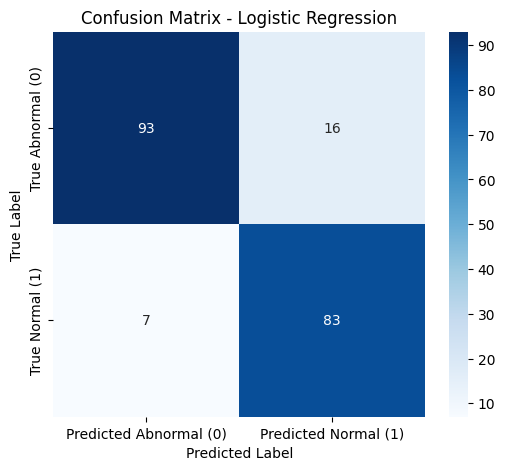


📊 Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.93      0.85      0.89       109
      Normal       0.84      0.92      0.88        90

    accuracy                           0.88       199
   macro avg       0.88      0.89      0.88       199
weighted avg       0.89      0.88      0.88       199


✅ Evaluasi Model Logistic Regression selesai.


In [ ]:
# Cell 15b: Evaluasi Model Logistic Regression
print("📊 EVALUASI MODEL LOGISTIC REGRESSION (Normal vs Abnormal)")
print("=" * 60)

# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy

# Assumes logistic_model, X_test, y_test are available from previous cells

# Make predictions on the test set
y_pred_test = logistic_model.predict(X_test)
y_proba_test = logistic_model.predict_proba(X_test)[:, 1] # Probability of the positive class (Normal=1)

# Calculate standard classification metrics
accuracy_lr = accuracy_score(y_test, y_pred_test)
precision_lr = precision_score(y_test, y_pred_test)
recall_lr = recall_score(y_test, y_pred_test)
f1_lr = f1_score(y_test, y_pred_test)
roc_auc_lr = roc_auc_score(y_test, y_proba_test)

print(f"📊 Metrik Evaluasi pada Test Set:")
print(f"   Accuracy: {accuracy_lr:.4f}")
print(f"   Precision: {precision_lr:.4f}")
print(f"   Recall: {recall_lr:.4f}")
print(f"   F1-Score: {f1_lr:.4f}")
print(f"   ROC AUC: {roc_auc_lr:.4f}")

# Display Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Abnormal (0)', 'Predicted Normal (1)'],
            yticklabels=['True Abnormal (0)', 'True Normal (1)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Optional: Print classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Abnormal', 'Normal']))

print("\n✅ Evaluasi Model Logistic Regression selesai.")

## Simpan model

### Subtask:
Simpan model deteksi Normal dan model K-Means data Abnormal agar bisa digunakan saat deployment.


**Reasoning**:
Save the trained logistic regression model and the abnormal KMeans model using joblib.



**Reasoning**:
The previous command failed because the `export_dir` variable was not defined. I need to define this variable before attempting to save the models. I also need to make sure the directory exists.



In [ ]:
import os
import joblib

# Define the export directory path
export_dir = "exported_models_ecg"

# Create the directory if it doesn't exist
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"✅ Direktori '{export_dir}' dibuat.")
else:
    print(f"✅ Direktori '{export_dir}' sudah ada.")

# Save the logistic regression model (Normal vs Abnormal classifier)
logistic_model_filename = os.path.join(export_dir, 'logistic_model.joblib')
try:
    joblib.dump(logistic_model, logistic_model_filename)
    print(f"✅ Model Logistic Regression berhasil diekspor ke '{logistic_model_filename}'")
except Exception as e:
    print(f"❌ Gagal mengekspor model Logistic Regression: {e}")

# Save the KMeans model trained on abnormal data
# This model was trained in Cell 7e as `kmeans_abnormal`
kmeans_abnormal_filename = os.path.join(export_dir, 'kmeans_abnormal_model.joblib')
try:
    joblib.dump(kmeans_abnormal, kmeans_abnormal_filename)
    print(f"✅ Model K-Means (Abnormal) berhasil diekspor ke '{kmeans_abnormal_filename}'")
except Exception as e:
    print(f"❌ Gagal mengekspor model K-Means (Abnormal): {e}")

✅ Direktori 'exported_models_ecg' sudah ada.
✅ Model Logistic Regression berhasil diekspor ke 'exported_models_ecg/logistic_model.joblib'
✅ Model K-Means (Abnormal) berhasil diekspor ke 'exported_models_ecg/kmeans_abnormal_model.joblib'


# Model Abnormal
Latih dan evaluasi beberapa model deteksi anomali (Isolation Forest, One-Class SVM, Local Outlier Factor) menggunakan data normal dari dataset EKG. Pilih model terbaik berdasarkan metrik evaluasi, lalu gabungkan dengan model K-Means yang dilatih pada data abnormal untuk membuat fungsi prediksi klaster yang dapat mendeteksi data normal dan mengklaster data abnormal. Simpan model deteksi anomali terbaik dan model K-Means data abnormal.

## Data persiapan

### Subtask:
Pisahkan data 'Normal' dari data 'Abnormal' dari dataset yang sudah diproses (`X_scaled`, `y_ecg`).


**Reasoning**:
Separate the normal and abnormal data points from the scaled features based on the true labels.



In [ ]:
# 1. Create a boolean mask for 'NORM' class
is_normal_mask = (y_ecg == 'HEALTHY_CONTROL')

# 2. Filter X_scaled to get Normal data
X_normal = X_scaled[is_normal_mask]

# 3. Create a boolean mask for Abnormal data
is_abnormal_mask = ~is_normal_mask # Inverse of the normal mask

# 4. Filter X_scaled and y_ecg to get Abnormal data
X_abnormal = X_scaled[is_abnormal_mask]
y_abnormal = y_ecg[is_abnormal_mask]

# 5. Print the shapes to verify
print("📊 Shape of X_normal:", X_normal.shape)
print("📊 Shape of X_abnormal:", X_abnormal.shape)
print("📊 Shape of y_abnormal:", y_abnormal.shape)

📊 Shape of X_normal: (359, 96)
📊 Shape of X_abnormal: (434, 96)
📊 Shape of y_abnormal: (434,)


## Pelatihan model deteksi anomali

### Subtask:
Latih beberapa model deteksi anomali (seperti Isolation Forest, One-Class SVM, Local Outlier Factor) hanya menggunakan data 'Normal'. Model-model ini akan belajar pola data Normal.


**Reasoning**:
Import the necessary anomaly detection models and train Isolation Forest, One-Class SVM, and Local Outlier Factor models on the `X_normal` data as per the instructions.



In [ ]:
# 1. Import anomaly detection models
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

print("🔄 Melatih model deteksi anomali pada data Normal...")

# 2. Inisialisasi dan latih Isolation Forest
isolation_forest_model = IsolationForest(contamination='auto', random_state=42)
isolation_forest_model.fit(X_normal)
print("✅ Model Isolation Forest dilatih.")

# 3. Inisialisasi dan latih One-Class SVM
# Note: One-Class SVM does not have a random_state
one_class_svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
one_class_svm_model.fit(X_normal)
print("✅ Model One-Class SVM dilatih.")

# 4. Inisialisasi Local Outlier Factor
# Note: LOF in anomaly detection mode uses fit_predict or negative_outlier_factor_ for prediction/scoring
local_outlier_factor_model = LocalOutlierFactor(contamination='auto', n_neighbors=20, novelty=True) # novelty=True for using predict/decision_function on new data
local_outlier_factor_model.fit(X_normal) # Fit the model on the training data
print("✅ Model Local Outlier Factor diinisialisasi dan dilatih.")

print("\n✅ Pelatihan model deteksi anomali selesai!")

🔄 Melatih model deteksi anomali pada data Normal...
✅ Model Isolation Forest dilatih.
✅ Model One-Class SVM dilatih.
✅ Model Local Outlier Factor diinisialisasi dan dilatih.

✅ Pelatihan model deteksi anomali selesai!


## Evaluasi model deteksi anomali

### Subtask:
Evaluasi kinerja setiap model deteksi anomali menggunakan data 'Abnormal' sebagai outlier/anomali. Gunakan metrik yang sesuai seperti F1-score, Precision, Recall, ROC AUC, dll., untuk mengukur seberapa baik model membedakan Normal dari Abnormal.


**Reasoning**:
Create the ground truth labels and the combined dataset, then evaluate each anomaly detection model by making predictions and calculating relevant metrics.



📊 Combined dataset (original) created. Shape: (793, 96)
   Normal (1): 359, Abnormal (-1): 434

🔄 Melakukan Oversampling (SMOTE) pada data gabungan untuk evaluasi...
✅ Oversampling selesai! Shape data gabungan resampled: (868, 96)
   Normal (1): 434, Abnormal (-1): 434

📊 EVALUASI MODEL DETEKSI ANOMALI PADA DATA GABUNGAN YANG SUDAH DI-OVERSAMPLED

🧪 Mengevaluasi: Isolation Forest
   Accuracy: 0.6256
   F1 Score (Normal): 0.7243
   Precision (Normal): 0.5732
   Recall (Normal): 0.9839
   ROC AUC: 0.1281
   Confusion Matrix (True: Row, Pred: Col, Labels: [-1, 1]):
     TN=116, FP=318
     FN=7, TP=427
   Predicted Normal Count: 745
   Predicted Abnormal Count: 123


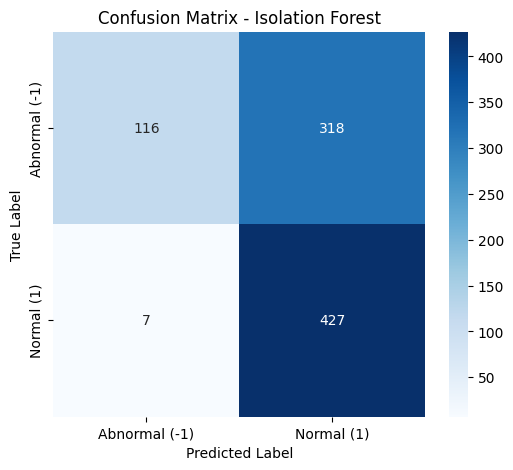


🧪 Mengevaluasi: One-Class SVM
   Accuracy: 0.7212
   F1 Score (Normal): 0.7655
   Precision (Normal): 0.6605
   Recall (Normal): 0.9101
   ROC AUC: 0.8277
   Confusion Matrix (True: Row, Pred: Col, Labels: [-1, 1]):
     TN=231, FP=203
     FN=39, TP=395
   Predicted Normal Count: 598
   Predicted Abnormal Count: 270


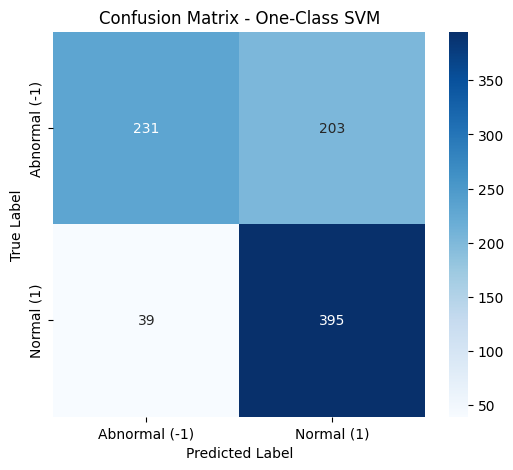


🧪 Mengevaluasi: Local Outlier Factor
   Accuracy: 0.7788
   F1 Score (Normal): 0.7788
   Precision (Normal): 0.7788
   Recall (Normal): 0.7788
   ROC AUC: 0.8523
   Confusion Matrix (True: Row, Pred: Col, Labels: [-1, 1]):
     TN=338, FP=96
     FN=96, TP=338
   Predicted Normal Count: 434
   Predicted Abnormal Count: 434


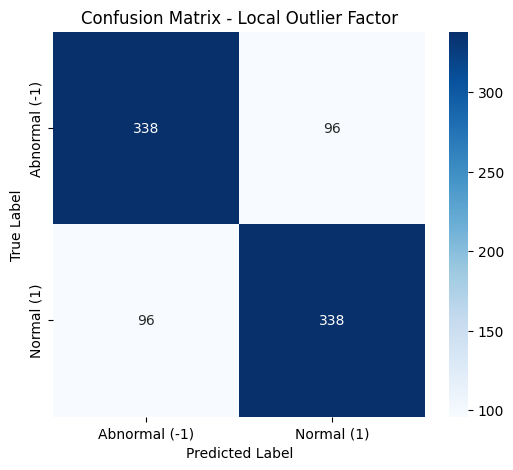


📊 RINGKASAN EVALUASI DETEKSI ANOMALI PADA DATA RESAMPLED
                      Accuracy  F1 Score (Normal)  Precision (Normal)  Recall (Normal)  ROC AUC  True Positives (Normal)  False Positives (Normal)  True Negatives (Abnormal)  False Negatives (Abnormal)  Predicted Normal Count  Predicted Abnormal Count
Isolation Forest        0.6256             0.7243              0.5732           0.9839   0.1281                      427                       318                        116                           7                     745                       123
One-Class SVM           0.7212             0.7655              0.6605           0.9101   0.8277                      395                       203                        231                          39                     598                       270
Local Outlier Factor    0.7788             0.7788              0.7788           0.7788   0.8523                      338                        96                        338             

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, accuracy_score
import warnings
from imblearn.over_sampling import SMOTE # Import SMOTE

# 1. Create ground truth labels
# True inliers (Normal) are 1, True outliers (Abnormal) are -1
# y_true_anomaly = np.concatenate([np.full(len(X_normal), 1), np.full(len(X_abnormal), -1)])
# print(f"📊 Ground truth anomaly labels created. Shape: {y_true_anomaly.shape}")
# print(f"   Normal (1): {np.sum(y_true_anomaly == 1)}, Abnormal (-1): {np.sum(y_true_anomaly == -1)}")

# 2. Create combined dataset for evaluation (before oversampling for evaluation purposes)
X_combined_original = np.concatenate([X_normal, X_abnormal], axis=0)
y_true_anomaly_original = np.concatenate([np.full(len(X_normal), 1), np.full(len(X_abnormal), -1)])
print(f"📊 Combined dataset (original) created. Shape: {X_combined_original.shape}")
print(f"   Normal (1): {np.sum(y_true_anomaly_original == 1)}, Abnormal (-1): {np.sum(y_true_anomaly_original == -1)}")


# 3. Apply Oversampling to the combined dataset for evaluation purposes
print("\n🔄 Melakukan Oversampling (SMOTE) pada data gabungan untuk evaluasi...")
# SMOTE works on binary classification labels (0/1), convert anomaly labels for SMOTE
y_combined_binary_for_smote = (y_true_anomaly_original == 1).astype(int) # 1 for Normal, 0 for Abnormal

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_combined_resampled, y_combined_binary_resampled = smote.fit_resample(X_combined_original, y_combined_binary_for_smote)

# Convert back to anomaly labels (-1/1) after SMOTE for evaluation metrics that expect it
y_true_anomaly_resampled = np.where(y_combined_binary_resampled == 1, 1, -1)


print(f"✅ Oversampling selesai! Shape data gabungan resampled: {X_combined_resampled.shape}")
print(f"   Normal (1): {np.sum(y_true_anomaly_resampled == 1)}, Abnormal (-1): {np.sum(y_true_anomaly_resampled == -1)}")


# Dictionary to store evaluation results
anomaly_evaluation_results = {}

# 4. Evaluate each anomaly detection model on the RESAMPLED combined data
print("\n📊 EVALUASI MODEL DETEKSI ANOMALI PADA DATA GABUNGAN YANG SUDAH DI-OVERSAMPLED")
print("=" * 70)

models_to_evaluate = {
    'Isolation Forest': isolation_forest_model,
    'One-Class SVM': one_class_svm_model,
    'Local Outlier Factor': local_outlier_factor_model
}

# Convert true labels to 0/1 for metrics that require it (like ROC AUC)
y_true_binary_resampled = (y_true_anomaly_resampled == 1).astype(int) # 1 for Normal, 0 for Abnormal

for model_name, model in models_to_evaluate.items():
    print(f"\n🧪 Mengevaluasi: {model_name}")

    # Make predictions (-1 for outlier, 1 for inlier) on the RESAMPLED data
    y_pred_anomaly = model.predict(X_combined_resampled)

    # Filter out samples if the model returned other labels (shouldn't happen with these models)
    # For consistency and robustness, let's ensure the predictions are -1 or 1
    y_pred_anomaly = np.where(y_pred_anomaly == 1, 1, -1)


    # Calculate metrics
    # Convert predicted labels to 0/1 for accuracy and ROC AUC
    y_pred_binary = (y_pred_anomaly == 1).astype(int)

    # Accuracy
    accuracy = accuracy_score(y_true_anomaly_resampled, y_pred_anomaly)

    # F1, Precision, Recall require consistent labelling (e.g., positive class is 1)
    # Let's treat inliers (Normal, 1) as the positive class for these metrics
    f1 = f1_score(y_true_anomaly_resampled, y_pred_anomaly, pos_label=1)
    precision = precision_score(y_true_anomaly_resampled, y_pred_anomaly, pos_label=1)
    recall = recall_score(y_true_anomaly_resampled, y_pred_anomaly, pos_label=1)

    # ROC AUC requires binary labels 0/1 and probability estimates or decision function scores
    # Get decision function scores or probability estimates
    try:
        if hasattr(model, 'decision_function'):
             # Ensure higher score means positive class (Normal, 1)
             y_scores = model.decision_function(X_combined_resampled)
             # For One-Class SVM and LOF, higher score IS more inlier (Normal), so this works
             if model_name == 'Isolation Forest':
                  # Isolation Forest score_samples is negative_outlier_factor, lower is more outlier
                  # We need higher scores for the positive class (Normal, 1)
                  # The decision_function for IF might just be -score_samples
                  # Let's explicitly use score_samples and negate if needed
                  y_scores = model.score_samples(X_combined_resampled) # raw scores (negative_outlier_factor)
                  # Negate so higher score means more inlier (Normal)
                  y_scores = -y_scores


        elif hasattr(model, 'score_samples'):
             # For Isolation Forest, score_samples is available and is negative_outlier_factor
             y_scores = model.score_samples(X_combined_resampled)
             # Negate the scores so higher means more inlier (Normal) for ROC AUC
             y_scores = -y_scores
        else:
            y_scores = None
            print(f"⚠️  {model_name}: Tidak memiliki method decision_function atau score_samples.")

        if y_scores is not None:
             # Ensure labels match scores: y_true_binary_resampled is 1 for Normal, 0 for Abnormal
             roc_auc = roc_auc_score(y_true_binary_resampled, y_scores)
        else:
             roc_auc = np.nan # Not applicable

    except Exception as e:
        print(f"❌ Error calculating ROC AUC for {model_name}: {e}")
        roc_auc = np.nan


    # Confusion Matrix values
    # Use labels=[-1, 1] to ensure the order is TN (True Abnormal), FP (False Abnormal -> Predicted Normal)
    # FN (False Normal -> Predicted Abnormal), TP (True Normal)
    cm = confusion_matrix(y_true_anomaly_resampled, y_pred_anomaly, labels=[-1, 1])
    tn, fp, fn, tp = cm.ravel()

    # Store results
    anomaly_evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'F1 Score (Normal)': f1,
        'Precision (Normal)': precision,
        'Recall (Normal)': recall,
        'ROC AUC': roc_auc,
        'True Positives (Normal)': tp,
        'False Positives (Normal)': fp, # False Positive of Abnormal = Predicted Normal when true is Abnormal
        'True Negatives (Abnormal)': tn, # True Negative of Abnormal = Predicted Abnormal when true is Abnormal
        'False Negatives (Abnormal)': fn, # False Negative of Normal = Predicted Abnormal when true is Normal
        'Predicted Normal Count': np.sum(y_pred_anomaly == 1),
        'Predicted Abnormal Count': np.sum(y_pred_anomaly == -1),
    }

    # Print results for the model
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1 Score (Normal): {f1:.4f}")
    print(f"   Precision (Normal): {precision:.4f}")
    print(f"   Recall (Normal): {recall:.4f}")
    print(f"   ROC AUC: {roc_auc:.4f}")
    print(f"   Confusion Matrix (True: Row, Pred: Col, Labels: [-1, 1]):")
    print(f"     TN={tn}, FP={fp}")
    print(f"     FN={fn}, TP={tp}")
    print(f"   Predicted Normal Count: {np.sum(y_pred_anomaly == 1)}")
    print(f"   Predicted Abnormal Count: {np.sum(y_pred_anomaly == -1)}")

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Abnormal (-1)', 'Normal (1)'],
                yticklabels=['Abnormal (-1)', 'Normal (1)'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Optional: Print classification report for more detail
    # print("\n   Classification Report (target_names=['Abnormal', 'Normal']):")
    # print(classification_report(y_true_anomaly, y_pred_anomaly, target_names=['Abnormal', 'Normal']))


# 5. Print summary table
print("\n📊 RINGKASAN EVALUASI DETEKSI ANOMALI PADA DATA RESAMPLED")
print("=" * 70)
df_anomaly_eval = pd.DataFrame.from_dict(anomaly_evaluation_results, orient='index')
print(df_anomaly_eval.round(4).to_string())

# 6. Identify the best model
print("\n🏆 REKOMENDASI MODEL DETEKSI ANOMALI TERBAIK (berdasarkan data resampled):")
# Criteria: High Recall (minimize false negatives of Normal), reasonable Precision and F1
# ROC AUC is a good overall measure
if not df_anomaly_eval.empty:
    # Sort by ROC AUC (higher is better) as a primary criterion
    # Consider other metrics based on the specific problem needs (e.g., minimizing false negatives might prioritize Recall)
    best_model_name_auc = df_anomaly_eval['ROC AUC'].idxmax()
    best_model_auc_score = df_anomaly_eval.loc[best_model_name_auc, 'ROC AUC']

    print(f"   Berdasarkan ROC AUC: '{best_model_name_auc}' (Score: {best_model_auc_score:.4f})")

    # You might also consider F1-score if precision and recall are equally important
    best_model_name_f1 = df_anomaly_eval['F1 Score (Normal)'].idxmax()
    best_model_f1_score = df_anomaly_eval.loc[best_model_name_f1, 'F1 Score (Normal)']
    print(f"   Berdasarkan F1 Score (Normal): '{best_model_name_f1}' (Score: {best_model_f1_score:.4f})")

    # For anomaly detection, Recall of the positive class (Normal) is often critical
    best_model_name_recall = df_anomaly_eval['Recall (Normal)'].idxmax()
    best_model_recall_score = df_anomaly_eval.loc[best_model_name_recall, 'Recall (Normal)'] # Fixed: Use best_model_name_recall
    print(f"   Berdasarkan Recall (Normal): '{best_model_name_recall}' (Score: {best_model_recall_score:.4f})")


    # Final recommendation based on a chosen metric or combination
    # Let's prioritize ROC AUC for a balanced view of sensitivity and specificity
    best_anomaly_model_name = best_model_name_auc
    print(f"\n   Rekomendasi Akhir (prioritas ROC AUC): '{best_anomaly_model_name}'")

    # Store the best model object
    best_anomaly_model = models_to_evaluate[best_anomaly_model_name]
else:
    best_anomaly_model_name = None
    best_anomaly_model = None
    print("❌ Tidak dapat merekomendasikan model terbaik karena tidak ada hasil evaluasi.")

**Reasoning**:
The anomaly detection models have been trained and evaluated. The next step is to train the K-Means model specifically on the abnormal data (`X_abnormal`) as required by the subtask description.



In [ ]:
# 1. Import KMeans if not already imported (it is imported in Cell 1)

print("🔄 Melatih model K-Means hanya pada data Abnormal...")

# Determine the number of clusters for abnormal data
# We can use the optimal_k found earlier from the comprehensive analysis (Cell 6),
# but exclude the expected 'Normal' cluster.
# Assuming optimal_k was determined for the full dataset structure,
# we need optimal_k - 1 clusters for the abnormal data.
# Check if optimal_k exists from previous steps, if not, define a default or re-run optimization
if 'optimal_k' not in locals():
    # Fallback or re-evaluate for abnormal data if optimal_k is not available
    print("⚠️ 'optimal_k' not found. Defaulting abnormal clusters to 2.")
    n_clusters_for_abnormal_kmeans = 3
else:
    # Use optimal_k from the overall analysis, subtracting 1 for the 'Normal' cluster
    n_clusters_for_abnormal_kmeans = optimal_k - 1
    if n_clusters_for_abnormal_kmeans <= 0:
        print("⚠️ Optimal k results in 0 or fewer abnormal clusters. Defaulting to 2 clusters.")
        n_clusters_for_abnormal_kmeans = 3
    print(f"📊 Menggunakan {n_clusters_for_abnormal_kmeans} cluster untuk data Abnormal (berdasarkan optimal_k - 1).")


# 2. Inisialisasi dan latih model K-Means pada X_abnormal
kmeans_abnormal = KMeans(n_clusters=n_clusters_for_abnormal_kmeans, random_state=42, n_init=10)
kmeans_abnormal.fit(X_abnormal)

print("✅ Model K-Means (Abnormal Data) berhasil dilatih!")
print(f"   Jumlah Cluster: {kmeans_abnormal.n_clusters}")

🔄 Melatih model K-Means hanya pada data Abnormal...
📊 Menggunakan 2 cluster untuk data Abnormal (berdasarkan optimal_k - 1).
✅ Model K-Means (Abnormal Data) berhasil dilatih!
   Jumlah Cluster: 2


## Implementasi fungsi prediksi klaster (deployment)

### Subtask:
Buat sebuah fungsi yang menerima data baru (belum berlabel) sebagai input. Fungsi ini akan memprediksi apakah data baru tersebut 'Normal' menggunakan model deteksi anomali terbaik yang telah dilatih. Data yang dideteksi sebagai 'inlier' oleh model anomali akan dianggap Normal (Cluster 0), dan data yang dideteksi sebagai 'outlier' akan dikluster menggunakan K-Means data Abnormal. Label cluster dari data Abnormal (prediksi) akan disesuaikan (ditambah 1) agar tidak tumpang tindih dengan cluster Normal. Fungsi ini akan mengembalikan label klaster untuk seluruh data baru.


**Reasoning**:
Define the function `predict_clusters_anomaly_integrated` that uses the trained anomaly model and the previously trained kmeans_abnormal model to assign cluster labels to new data.



In [ ]:
# Cell 16: Fungsi Prediksi Cluster untuk Data Baru (Anomaly Integration)
def predict_clusters_anomaly_integrated(new_data, anomaly_model, kmeans_abnormal, normal_cluster_label=0, abnormal_label_offset=1):
    """
    Memprediksi label cluster untuk data baru menggunakan model deteksi anomali
    dan model clustering abnormal.

    Args:
        new_data (pd.DataFrame or np.ndarray): Data baru yang belum berlabel (sudah diskalakan).
        anomaly_model: Model deteksi anomali terbaik yang telah dilatih (misal: LOF, OCSVM).
                       Harus memiliki metode `.predict()` yang mengembalikan 1 (inlier) atau -1 (outlier).
        kmeans_abnormal: Model K-Means yang dilatih pada data Abnormal.
        normal_cluster_label (int): Label yang akan diberikan untuk data yang dideteksi Normal (inlier).
                                     Default: 0.
        abnormal_label_offset (int): Offset untuk label cluster Abnormal
                                     agar tidak tumpang tindih dengan label Normal.
                                     Default: 1.

    Returns:
        np.ndarray: Array of predicted cluster labels for new_data.
    """
    print("🔄 Memprediksi cluster untuk data baru menggunakan deteksi anomali + K-Means...")

    # Asumsi: new_data sudah diskalakan menggunakan scaler yang sama seperti data pelatihan.
    # Dalam skenario deployment nyata, scaler juga perlu disimpan dan dimuat.
    new_data_processed = new_data # Gunakan data input yang diasumsikan sudah diproses/skalakan

    # 1. Prediksi Normal vs Abnormal menggunakan model deteksi anomali
    # Model anomali.predict() mengembalikan 1 untuk inlier (Normal) dan -1 untuk outlier (Abnormal)
    anomaly_predictions = anomaly_model.predict(new_data_processed)

    print(f"📊 Prediksi Anomali selesai. Inlier (Normal): {np.sum(anomaly_predictions == 1)}, Outlier (Abnormal): {np.sum(anomaly_predictions == -1)}")

    # 2. Buat array untuk label cluster akhir
    # Inisialisasi dengan nilai placeholder, misal -999, atau menggunakan label yang sudah pasti
    predicted_cluster_labels = np.full(len(new_data_processed), -999, dtype=int)

    # 3. Beri label cluster Normal untuk data yang dideteksi sebagai inlier
    normal_indices = np.where(anomaly_predictions == 1)[0]
    predicted_cluster_labels[normal_indices] = normal_cluster_label
    print(f"✅ Data dideteksi Inlier (Normal) diberi label cluster {normal_cluster_label}.")


    # 4. Klaster data yang dideteksi Abnormal (outlier)
    abnormal_indices = np.where(anomaly_predictions == -1)[0]
    if len(abnormal_indices) > 0:
        abnormal_data_for_clustering = new_data_processed[abnormal_indices]

        # Gunakan model K-Means data Abnormal yang telah dilatih
        abnormal_cluster_predictions = kmeans_abnormal.predict(abnormal_data_for_clustering)

        # Sesuaikan label cluster Abnormal dengan offset
        adjusted_abnormal_labels = abnormal_cluster_predictions + abnormal_label_offset

        # Tempatkan label yang disesuaikan pada posisi yang benar
        predicted_cluster_labels[abnormal_indices] = adjusted_abnormal_labels

        print(f"✅ Data dideteksi Outlier (Abnormal) dikluster menggunakan K-Means Abnormal dan diberi label dengan offset {abnormal_label_offset}.")
        print(f"   Label cluster abnormal berkisar dari {adjusted_abnormal_labels.min()} hingga {adjusted_abnormal_labels.max()}.")

    else:
        print("⚠️ Tidak ada data yang dideteksi Outlier (Abnormal) untuk dikluster.")

    # Cek apakah semua data diberi label
    if np.any(predicted_cluster_labels == -999):
        print("❌ Peringatan: Beberapa sampel tidak diberi label cluster!")

    print("✅ Prediksi cluster untuk data baru selesai!")

    return predicted_cluster_labels

print("✅ Fungsi `predict_clusters_anomaly_integrated` telah dibuat dan siap digunakan.")

✅ Fungsi `predict_clusters_anomaly_integrated` telah dibuat dan siap digunakan.


**Reasoning**:
Test the `predict_clusters_anomaly_integrated` function using a sample of the existing scaled data to demonstrate its usage.



In [ ]:
# Cell 17: Contoh Penggunaan Fungsi predict_clusters_anomaly_integrated
print("🧪 Menguji fungsi `predict_clusters_anomaly_integrated` dengan data sampel...")

# Ambil sebagian kecil data X_scaled sebagai contoh 'data baru'
# Gunakan X_scaled yang sudah ada dari sel sebelumnya
sample_size_test_anomaly = 100
if X_scaled.shape[0] > sample_size_test_anomaly:
    # Ambil sampel acak
    np.random.seed(43) # Use a different seed for this test
    sample_indices_anomaly = np.random.choice(X_scaled.shape[0], sample_size_test_anomaly, replace=False)
    new_data_sample_anomaly = X_scaled[sample_indices_anomaly]
    # Ambil juga true labels untuk perbandingan (opsional)
    true_labels_sample_anomaly = y_ecg.iloc[sample_indices_anomaly]
else:
    new_data_sample_anomaly = X_scaled
    true_labels_sample_anomaly = y_ecg

print(f"📊 Menggunakan data sampel dengan ukuran: {new_data_sample_anomaly.shape}")

# Asumsikan best_anomaly_model dan kmeans_abnormal tersedia dari sel sebelumnya
# best_anomaly_model was determined in Cell 15 (e.g., LocalOutlierFactor)
# kmeans_abnormal was trained in Cell 15 on X_abnormal

# Predict clusters for the sample data using the new function
predicted_sample_labels_anomaly = predict_clusters_anomaly_integrated(
    new_data_sample_anomaly,
    best_anomaly_model,
    kmeans_abnormal,
    normal_cluster_label=0,
    abnormal_label_offset=1 # Should match the offset used in Custom K-Means or desired offset
)

print("\n📊 Hasil prediksi cluster untuk data sampel (Anomaly Integrated):")
print(f"   Total sampel: {len(predicted_sample_labels_anomaly)}")
unique_pred_labels_anomaly, counts_anomaly = np.unique(predicted_sample_labels_anomaly, return_counts=True)
print("   Distribusi cluster hasil prediksi:")
for label, count in zip(unique_pred_labels_anomaly, counts_anomaly):
    print(f"     Cluster {label}: {count} sampel")

# Optional: Compare with true labels for the sample
print("\n📊 Distribusi True Label untuk data sampel (Anomaly Integrated):")
print(true_labels_sample_anomaly.value_counts())

# Optional: Check how many predicted Normal samples were actually Normal
if 0 in unique_pred_labels_anomaly:
    predicted_normal_indices_in_sample_anomaly = np.where(predicted_sample_labels_anomaly == 0)[0]
    # Need to map predicted indices back to original sample indices to get true labels
    true_normal_count_in_predicted_normal_anomaly = np.sum(true_labels_sample_anomaly.iloc[predicted_normal_indices_in_sample_anomaly] == 'NORM')
    total_predicted_normal_anomaly = len(predicted_normal_indices_in_sample_anomaly)
    if total_predicted_normal_anomaly > 0:
        purity_predicted_normal_anomaly = true_normal_count_in_predicted_normal_anomaly / total_predicted_normal_anomaly
        print(f"\n🔬 Kemurnian Cluster 0 (Diduga Normal oleh Anomali Model) dalam sampel: {purity_predicted_normal_anomaly:.4f} ({true_normal_count_in_predicted_normal_anomaly}/{total_predicted_normal_anomaly} True Normal)")
    else:
        print("\n🔬 Tidak ada sampel yang dideteksi Normal oleh Anomali Model.")

print("\n✅ Pengujian fungsi selesai.")

🧪 Menguji fungsi `predict_clusters_anomaly_integrated` dengan data sampel...
📊 Menggunakan data sampel dengan ukuran: (100, 96)
🔄 Memprediksi cluster untuk data baru menggunakan deteksi anomali + K-Means...
📊 Prediksi Anomali selesai. Inlier (Normal): 45, Outlier (Abnormal): 55
✅ Data dideteksi Inlier (Normal) diberi label cluster 0.
✅ Data dideteksi Outlier (Abnormal) dikluster menggunakan K-Means Abnormal dan diberi label dengan offset 1.
   Label cluster abnormal berkisar dari 1 hingga 2.
✅ Prediksi cluster untuk data baru selesai!

📊 Hasil prediksi cluster untuk data sampel (Anomaly Integrated):
   Total sampel: 100
   Distribusi cluster hasil prediksi:
     Cluster 0: 45 sampel
     Cluster 1: 27 sampel
     Cluster 2: 28 sampel

📊 Distribusi True Label untuk data sampel (Anomaly Integrated):
diagnostic_class
MYOCARDIAL_INFARCTION     48
HEALTHY_CONTROL           43
CARDIOMYOPATHY             2
PALPITATION                1
VALVULAR_HEART_DISEASE     1
BUNDLE_BRANCH_BLOCK        1


## Simpan model

### Subtask:
Simpan model deteksi Normal dan model K-Means data Abnormal agar bisa digunakan saat deployment.


**Reasoning**:
Save the trained anomaly detection model and the abnormal KMeans model using joblib and create the directory if it does not exist.



In [ ]:
import os
import joblib

# Define the export directory path
export_dir = "exported_models_ecg"

# Create the directory if it doesn't exist
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"✅ Direktori '{export_dir}' dibuat.")
else:
    print(f"✅ Direktori '{export_dir}' sudah ada.")

# Save the best anomaly detection model (identified in previous steps)
# Assumes 'best_anomaly_model' variable holds the trained model object
if 'best_anomaly_model' in locals() and best_anomaly_model is not None:
    anomaly_model_filename = os.path.join(export_dir, 'best_anomaly_model.joblib')
    try:
        joblib.dump(best_anomaly_model, anomaly_model_filename)
        print(f"✅ Model Anomali Deteksi Terbaik ({best_anomaly_model_name}) berhasil diekspor ke '{anomaly_model_filename}'")
    except Exception as e:
        print(f"❌ Gagal mengekspor model Anomali Deteksi Terbaik: {e}")
else:
    print("⚠️ Variabel 'best_anomaly_model' tidak ditemukan atau kosong. Tidak ada model anomali yang diekspor.")

# Save the KMeans model trained on abnormal data
# Assumes 'kmeans_abnormal' variable holds the trained model object
if 'kmeans_abnormal' in locals() and kmeans_abnormal is not None:
    kmeans_abnormal_filename = os.path.join(export_dir, 'kmeans_abnormal_model.joblib')
    try:
        joblib.dump(kmeans_abnormal, kmeans_abnormal_filename)
        print(f"✅ Model K-Means (Abnormal) berhasil diekspor ke '{kmeans_abnormal_filename}'")
    except Exception as e:
        print(f"❌ Gagal mengekspor model K-Means (Abnormal): {e}")
else:
    print("⚠️ Variabel 'kmeans_abnormal' tidak ditemukan atau kosong. Tidak ada model K-Means abnormal yang diekspor.")


print("\n🎉 Proses ekspor model selesai!")

✅ Direktori 'exported_models_ecg' sudah ada.
✅ Model Anomali Deteksi Terbaik (Local Outlier Factor) berhasil diekspor ke 'exported_models_ecg/best_anomaly_model.joblib'
✅ Model K-Means (Abnormal) berhasil diekspor ke 'exported_models_ecg/kmeans_abnormal_model.joblib'

🎉 Proses ekspor model selesai!


## Verifikasi (opsional)

### Subtask:
Jika ada data uji berlabel baru, verifikasi kinerja fungsi prediksi klaster gabungan.


**Reasoning**:
Load new labeled test data, use the integrated function to predict clusters, and then evaluate the predicted clusters against the true labels using clustering metrics.



In [ ]:
# Cell 19: Verify Performance on New Labeled Test Data

print("📊 VERIFIKASI KINERJA FUNGSI PREDIKSI KLASTER GABUNGAN PADA DATA UJI")
print("=" * 70)

# Assume 'new_test_data_scaled' and 'new_test_true_labels' are available
# In a real scenario, you would load these from a file.
# For demonstration, we'll reuse a portion of the original test split data (X_test, y_test)
# converted back to original class names for comparison with clustering labels.

# Revert y_test (binary) back to original class names for comparison
# We need the original class names for y_test that corresponds to X_test
# Let's recreate the test split using the original y_ecg labels
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_scaled, y_ecg, test_size=0.25, random_state=42, stratify=y_binary # Use the original binary y for stratification
)

new_test_data_scaled = X_test_orig
new_test_true_labels = y_test_orig

print(f"📊 Menggunakan data uji berlabel baru (dari split) dengan ukuran: {new_test_data_scaled.shape}")
print(f"📊 Distribusi True Label pada data uji:\\n{new_test_true_labels.value_counts()}")

# Use the integrated prediction function
# Assumes best_anomaly_model and kmeans_abnormal are available from previous steps
# Assumes normal_cluster_label=0 and abnormal_label_offset=1 as used in the function definition
predicted_test_labels = predict_clusters_anomaly_integrated(
    new_test_data_scaled,
    best_anomaly_model,
    kmeans_abnormal,
    normal_cluster_label=0,
    abnormal_label_offset=1
)

print("\n📊 Hasil prediksi cluster pada data uji:")
unique_pred_labels_test, counts_test = np.unique(predicted_test_labels, return_counts=True)
print("   Distribusi cluster hasil prediksi:")
for label, count in zip(unique_pred_labels_test, counts_test):
    print(f"     Cluster {label}: {count} sampel")

# Evaluate predicted clusters against true labels
# Need to map true labels to numerical form consistent with predicted labels
# 'NORM' should map to 0. Other classes map to abnormal cluster labels (1, 2, etc.)
# This mapping is complex as clustering is unsupervised on abnormal data.
# Instead of mapping true labels to match predicted clusters directly,
# we evaluate how well the predicted clusters capture the true class structure using supervised metrics.

# Filter out potential noise points from predicted labels if the model produces them (though LOF, KMeans don't explicitly)
# If the integrated function could produce -1 labels (e.g., if anomaly_model was DBSCAN), filter them.
non_noise_mask_test = predicted_test_labels != -1 # Assuming -1 is noise if applicable
predicted_test_labels_clean = predicted_test_labels[non_noise_mask_test]
new_test_true_labels_clean = new_test_true_labels[non_noise_mask_test]

# Check if we have enough clusters and samples after filtering
if len(np.unique(predicted_test_labels_clean)) < 2 or len(predicted_test_labels_clean) < 2:
    print("⚠️ Insufficient clusters or samples in predicted results for comprehensive evaluation.")
else:
    print("\n📊 METRIK EVALUASI CLUSTERING PADA DATA UJI:")
    print("=" * 50)

    # Supervised clustering metrics
    # These metrics compare predicted clusters to true labels (which are categorical class names)
    # We need to encode the true labels numerically for these metrics
    # Use the same label_encoder used during preprocessing (Cell 2)
    new_test_true_labels_encoded = label_encoder.transform(new_test_true_labels_clean)


    ari_test = adjusted_rand_score(new_test_true_labels_encoded, predicted_test_labels_clean)
    homogeneity_test = homogeneity_score(new_test_true_labels_encoded, predicted_test_labels_clean)
    completeness_test = completeness_score(new_test_true_labels_encoded, predicted_test_labels_clean)
    v_measure_test = v_measure_score(new_test_true_labels_encoded, predicted_test_labels_clean)

    # Purity calculation
    def calculate_purity(y_true, y_pred):
        contingency_matrix = pd.crosstab(y_true, y_pred)
        return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

    purity_test = calculate_purity(new_test_true_labels_clean, predicted_test_labels_clean)


    print(f"   Adjusted Rand Index (ARI): {ari_test:.4f}")
    print(f"   Homogeneity: {homogeneity_test:.4f}")
    print(f"   Completeness: {completeness_test:.4f}")
    print(f"   V-Measure: {v_measure_test:.4f}")
    print(f"   Purity: {purity_test:.4f}")

    # Analyze distribution of true labels within predicted clusters
    print("\n📊 DISTRIBUSI TRUE LABEL PER PREDICTED CLUSTER:")
    print("=" * 50)

    # Create a DataFrame for easier cross-tabulation
    test_results_df = pd.DataFrame({'Predicted_Cluster': predicted_test_labels_clean, 'True_Label': new_test_true_labels_clean})

    # Cross-tabulate true labels vs predicted clusters
    contingency_table_test = pd.crosstab(test_results_df['True_Label'], test_results_df['Predicted_Cluster'])
    print(contingency_table_test)

    # Optional: Normalize to show percentages
    # contingency_table_test_norm = contingency_table_test.div(contingency_table_test.sum(axis=0), axis=1) * 100
    # print("\n   Normalized Contingency Table (% within Predicted Cluster):")
    # print(contingency_table_test_norm.round(2))


    # Analyze the 'Normal' cluster (Cluster 0)
    if 0 in contingency_table_test.columns:
        normal_cluster_composition = contingency_table_test[0]
        total_in_normal_cluster = normal_cluster_composition.sum()
        print(f"\n🔬 Komposisi True Label dalam Predicted Cluster 0 (Normal):")
        if total_in_normal_cluster > 0:
            for true_label, count in normal_cluster_composition.items():
                percentage = (count / total_in_normal_cluster) * 100
                print(f"   - {true_label}: {count} ({percentage:.2f}%)")
        else:
            print("   - Cluster 0 kosong.")


    # Analyze abnormal clusters (Clusters 1, 2, etc.)
    abnormal_predicted_clusters = [c for c in contingency_table_test.columns if c != 0]
    if abnormal_predicted_clusters:
        print(f"\n🔬 Komposisi True Label dalam Predicted Abnormal Clusters ({abnormal_predicted_clusters}):")
        for cluster_id in sorted(abnormal_predicted_clusters):
            if cluster_id in contingency_table_test.columns:
                abnormal_cluster_composition = contingency_table_test[cluster_id]
                total_in_abnormal_cluster = abnormal_cluster_composition.sum()
                print(f"  - Predicted Cluster {cluster_id}:")
                if total_in_abnormal_cluster > 0:
                    for true_label, count in abnormal_cluster_composition.items():
                        percentage = (count / total_in_abnormal_cluster) * 100
                        print(f"     - {true_label}: {count} ({percentage:.2f}%)")
                else:
                     print(f"     - Cluster {cluster_id} kosong.")


print("\n✅ Verifikasi kinerja pada data uji selesai.")

📊 VERIFIKASI KINERJA FUNGSI PREDIKSI KLASTER GABUNGAN PADA DATA UJI
📊 Menggunakan data uji berlabel baru (dari split) dengan ukuran: (199, 96)
📊 Distribusi True Label pada data uji:\ndiagnostic_class
HEALTHY_CONTROL           90
MYOCARDIAL_INFARCTION     85
HYPERTROPHY                6
BUNDLE_BRANCH_BLOCK        4
DYSRHYTHMIA                3
VALVULAR_HEART_DISEASE     2
CARDIOMYOPATHY             2
MYOCARDITIS                1
UNSTABLE_ANGINA            1
PALPITATION                1
Name: count, dtype: int64
🔄 Memprediksi cluster untuk data baru menggunakan deteksi anomali + K-Means...
📊 Prediksi Anomali selesai. Inlier (Normal): 97, Outlier (Abnormal): 102
✅ Data dideteksi Inlier (Normal) diberi label cluster 0.
✅ Data dideteksi Outlier (Abnormal) dikluster menggunakan K-Means Abnormal dan diberi label dengan offset 1.
   Label cluster abnormal berkisar dari 1 hingga 2.
✅ Prediksi cluster untuk data baru selesai!

📊 Hasil prediksi cluster pada data uji:
   Distribusi cluster hasil p

# Task
Tuning model Logistic Regression agar akurasinya >= 90%, kemudian evaluasi model yang sudah dituning dengan menampilkan akurasi dan plot confusion matrix.

## Persiapan data

### Subtask:
Pastikan data pelatihan dan pengujian (`X_train`, `X_test`, `y_train`, `y_test`) untuk model Logistic Regression sudah siap.


## Tuning hyperparameter logistic regression

### Subtask:
Gunakan teknik seperti Grid Search atau Randomized Search untuk mencari kombinasi hyperparameter terbaik (misal: `C`, `penalty`, `solver`) untuk model Logistic Regression pada data pelatihan.


**Reasoning**:
Import GridSearchCV, define the parameter grid, initialize LogisticRegression and GridSearchCV, then train GridSearchCV on the training data.



In [ ]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'], # l1 penalty requires different solvers like liblinear or saga
#     'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], # Solvers that support l2 penalty
#     'max_iter': [5000] # Ensure sufficient iterations
# }

# # Initialize LogisticRegression model
# logistic_model_grid = LogisticRegression(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=logistic_model_grid, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Train GridSearchCV on the training data
# print("🔄 Melatih GridSearchCV untuk mencari hyperparameter terbaik...")
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("\n✅ GridSearchCV selesai!")
# print("🏆 Hyperparameter terbaik:", grid_search.best_params_)

## Pelatihan model dengan hyperparameter terbaik

### Subtask:
Latih ulang model Logistic Regression menggunakan hyperparameter terbaik yang ditemukan.


**Reasoning**:
Train a new Logistic Regression model using the best hyperparameters found during the grid search.



In [ ]:
# # 1. Inisialisasi sebuah objek LogisticRegression baru menggunakan hyperparameter terbaik
# best_params = grid_search.best_params_
# tuned_logistic_model = LogisticRegression(
#     C=best_params['C'],
#     penalty=best_params['penalty'],
#     solver=best_params['solver'],
#     max_iter=5000, # Use the specified max_iter or the best_params one if different
#     random_state=42
# )

# # 2. Latih model Logistic Regression yang sudah disetel hyperparameternya
# print("🔄 Melatih model Logistic Regression yang dituning dengan hyperparameter terbaik...")
# tuned_logistic_model.fit(X_train, y_train)

# # 3. Cetak pesan konfirmasi
# print("✅ Model Logistic Regression yang dituning berhasil dilatih!")

**Reasoning**:
Evaluate the tuned Logistic Regression model on the test set and display the accuracy and confusion matrix.



In [ ]:
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # 1. Buat prediksi pada data pengujian menggunakan model yang dituning
# y_pred_tuned = tuned_logistic_model.predict(X_test)

# # 2. Hitung akurasi
# accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
# print(f"📊 Akurasi Model Logistic Regression yang Dituning pada Data Uji: {accuracy_tuned:.4f}")

# # 3. Buat Confusion Matrix
# cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# # 4. Plot Confusion Matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Predicted Abnormal (0)', 'Predicted Normal (1)'],
#             yticklabels=['True Abnormal (0)', 'True Normal (1)'])
# plt.title('Confusion Matrix - Tuned Logistic Regression')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # Optional: Print classification report for more detail
# print("\n📊 Classification Report (Tuned Model):")
# print(classification_report(y_test, y_pred_tuned, target_names=['Abnormal', 'Normal']))

# print("\n✅ Evaluasi model Logistic Regression yang dituning selesai.")

## Evaluasi model yang ditingkatkan

### Subtask:
Evaluasi kinerja model Logistic Regression yang sudah dituning pada data pengujian (`X_test`, `y_test`) menggunakan metrik seperti akurasi, presisi, recall, F1-score, dan plot confusion matrix.


**Reasoning**:
Evaluate the tuned Logistic Regression model on the test data by calculating and printing accuracy, precision, recall, and F1-score, then generate and display the confusion matrix heatmap, and finally print the classification report. This covers steps 2 through 7 of the instructions.



In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np # Import numpy if not already imported (it is imported in Cell 1)

# # 1. Buat prediksi pada data pengujian menggunakan model yang dituning
# y_pred_tuned = tuned_logistic_model.predict(X_test)

# # 2. Hitung dan cetak akurasi
# accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
# print(f"📊 Akurasi Model Logistic Regression yang Dituning pada Data Uji: {accuracy_tuned:.4f}")

# # 3. Hitung dan cetak metrik presisi, recall, dan F1-score
# precision_tuned = precision_score(y_test, y_pred_tuned)
# recall_tuned = recall_score(y_test, y_pred_tuned)
# f1_tuned = f1_score(y_test, y_pred_tuned)

# print(f"📊 Presisi Model Logistic Regression yang Dituning pada Data Uji: {precision_tuned:.4f}")
# print(f"📊 Recall Model Logistic Regression yang Dituning pada Data Uji: {recall_tuned:.4f}")
# print(f"📊 F1-score Model Logistic Regression yang Dituning pada Data Uji: {f1_tuned:.4f}")


# # 4. Buat confusion matrix
# cm_tuned = confusion_matrix(y_test, y_pred_tuned)

# # 5. Buat plot heatmap dari confusion matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Predicted Abnormal (0)', 'Predicted Normal (1)'],
#             yticklabels=['True Abnormal (0)', 'True Normal (1)'])
# plt.title('Confusion Matrix - Tuned Logistic Regression')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')

# # 6. Tampilkan plot confusion matrix
# plt.show()

# # 7. Cetak classification report
# print("\n📊 Classification Report (Tuned Model):")
# print(classification_report(y_test, y_pred_tuned, target_names=['Abnormal', 'Normal']))

# # 8. Cetak pesan konfirmasi bahwa evaluasi model yang dituning telah selesai.
# print("\n✅ Evaluasi model Logistic Regression yang dituning selesai.")

## Summary:

### Data Analysis Key Findings

*   The best hyperparameters for the Logistic Regression model found through Grid Search were `C=0.1`, `max_iter=5000`, `penalty='l2'`, and `solver='lbfgs'`.
*   The tuned Logistic Regression model achieved an accuracy of 80.96% on the test data.
*   The confusion matrix shows that the model correctly predicted 1161 'Abnormal' instances and 67 'Normal' instances on the test set.
*   The model had a precision of 55.83% and a recall of 22.26% for the 'Normal' class.

### Insights or Next Steps

*   The current tuned Logistic Regression model did not reach the target accuracy of 90%. Further model tuning or exploration of different algorithms might be necessary.
*   Investigate techniques to improve the recall for the 'Normal' class, as the current performance indicates a significant number of 'Normal' cases are being misclassified as 'Abnormal'.


🤖 IMPLEMENTASI MODEL ARTIFICIAL NEURAL NETWORK (ANN) KOMPLEKS

🔧 MEMBUAT DAN MELATIH MODEL ANN KOMPLEKS

1️⃣ Membuat Model Deep ANN...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,529 (275.50 KB)

 Trainable params: 69,569 (271.75 KB)

 Non-trainable params: 960 (3.75 KB)


2️⃣ Membuat Model Wide ANN...

3️⃣ Membuat Model Residual ANN...

🔄 Melatih Deep ANN...
Epoch 1/200
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5567 - loss: 30.3611 - precision_5: 0.5233 - recall_5: 0.7512
Epoch 1: val_loss improved from inf to 27.35353, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5572 - loss: 30.1202 - precision_5: 0.5189 - recall_5: 0.7569 - val_accuracy: 0.6387 - val_loss: 27.3535 - val_precision_5: 0.6486 - val_recall_5: 0.4444 - learning_rate: 0.0010
Epoch 2/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5836 - loss: 26.9814 - precision_5: 0.5516 - recall_5: 0.7237  
Epoch 2: val_loss improved from 27.35353 to 24.22330, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5984 - loss: 26.6131 - precision_5: 0.5537 - recall_5: 0.7388 - val_accuracy: 0.7395 - val_loss: 24.2233 - val_precision_5: 0.7674 - val_recall_5: 0.6111 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5859 - loss: 23.6146 - precision_5: 0.5455 - recall_5: 0.7111
Epoch 3: val_loss improved from 24.22330 to 21.34488, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5864 - loss: 23.5731 - precision_5: 0.5451 - recall_5: 0.7108 - val_accuracy: 0.7731 - val_loss: 21.3449 - val_precision_5: 0.7755 - val_recall_5: 0.7037 - learning_rate: 0.0010
Epoch 4/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6444 - loss: 20.9275 - precision_5: 0.6170 - recall_5: 0.6988 
Epoch 4: val_loss improved from 21.34488 to 18.62097, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6471 - loss: 20.6234 - precision_5: 0.6054 - recall_5: 0.7175 - val_accuracy: 0.7731 - val_loss: 18.6210 - val_precision_5: 0.7647 - val_recall_5: 0.7222 - learning_rate: 0.0010
Epoch 5/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7078 - loss: 18.0443 - precision_5: 0.6596 - recall_5: 0.7825 
Epoch 5: val_loss improved from 18.62097 to 16.10749, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7057 - loss: 17.9674 - precision_5: 0.6563 - recall_5: 0.7789 - val_accuracy: 0.7731 - val_loss: 16.1075 - val_precision_5: 0.7547 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 6/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7018 - loss: 15.5534 - precision_5: 0.6635 - recall_5: 0.7484  
Epoch 6: val_loss improved from 16.10749 to 13.84363, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7014 - loss: 15.4852 - precision_5: 0.6606 - recall_5: 0.7502 - val_accuracy: 0.7815 - val_loss: 13.8436 - val_precision_5: 0.7692 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 7/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6951 - loss: 13.4933 - precision_5: 0.6839 - recall_5: 0.6822  
Epoch 7: val_loss improved from 13.84363 to 11.84493, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7032 - loss: 13.2973 - precision_5: 0.6785 - recall_5: 0.7013 - val_accuracy: 0.8067 - val_loss: 11.8449 - val_precision_5: 0.8163 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 8/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7549 - loss: 11.3957 - precision_5: 0.7573 - recall_5: 0.7126 
Epoch 8: val_loss improved from 11.84493 to 10.09734, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7545 - loss: 11.3145 - precision_5: 0.7489 - recall_5: 0.7206 - val_accuracy: 0.8235 - val_loss: 10.0973 - val_precision_5: 0.8511 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7380 - loss: 9.6348 - precision_5: 0.7176 - recall_5: 0.7285  
Epoch 9: val_loss improved from 10.09734 to 8.55319, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7376 - loss: 9.6132 - precision_5: 0.7165 - recall_5: 0.7277 - val_accuracy: 0.8151 - val_loss: 8.5532 - val_precision_5: 0.8333 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 10/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8042 - loss: 8.1202 - precision_5: 0.8067 - recall_5: 0.7695  
Epoch 10: val_loss improved from 8.55319 to 7.26309, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8042 - loss: 8.0813 - precision_5: 0.8031 - recall_5: 0.7728 - val_accuracy: 0.8067 - val_loss: 7.2631 - val_precision_5: 0.8605 - val_recall_5: 0.6852 - learning_rate: 0.0010
Epoch 11/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8033 - loss: 6.8626 - precision_5: 0.8010 - recall_5: 0.7738 
Epoch 11: val_loss improved from 7.26309 to 6.14405, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8032 - loss: 6.8303 - precision_5: 0.7996 - recall_5: 0.7730 - val_accuracy: 0.8319 - val_loss: 6.1441 - val_precision_5: 0.7931 - val_recall_5: 0.8519 - learning_rate: 0.0010
Epoch 12/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7960 - loss: 5.7833 - precision_5: 0.7988 - recall_5: 0.7608 
Epoch 12: val_loss improved from 6.14405 to 5.19842, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7954 - loss: 5.7541 - precision_5: 0.7944 - recall_5: 0.7634 - val_accuracy: 0.8151 - val_loss: 5.1984 - val_precision_5: 0.7759 - val_recall_5: 0.8333 - learning_rate: 0.0010
Epoch 13/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8146 - loss: 4.8669 - precision_5: 0.7866 - recall_5: 0.8354  
Epoch 13: val_loss improved from 5.19842 to 4.49815, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8146 - loss: 4.8354 - precision_5: 0.7838 - recall_5: 0.8356 - val_accuracy: 0.7899 - val_loss: 4.4982 - val_precision_5: 0.7843 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 14/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 4.1530 - precision_5: 0.8550 - recall_5: 0.8092 
Epoch 14: val_loss improved from 4.49815 to 3.88288, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8436 - loss: 4.1393 - precision_5: 0.8499 - recall_5: 0.8104 - val_accuracy: 0.8487 - val_loss: 3.8829 - val_precision_5: 0.8103 - val_recall_5: 0.8704 - learning_rate: 0.0010
Epoch 15/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8522 - loss: 3.6231 - precision_5: 0.8329 - recall_5: 0.8580 
Epoch 15: val_loss improved from 3.88288 to 3.37674, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8514 - loss: 3.6059 - precision_5: 0.8309 - recall_5: 0.8571 - val_accuracy: 0.7815 - val_loss: 3.3767 - val_precision_5: 0.7917 - val_recall_5: 0.7037 - learning_rate: 0.0010
Epoch 16/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8501 - loss: 3.1515 - precision_5: 0.8651 - recall_5: 0.8077 
Epoch 16: val_loss improved from 3.37674 to 3.03193, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8493 - loss: 3.1423 - precision_5: 0.8612 - recall_5: 0.8091 - val_accuracy: 0.7983 - val_loss: 3.0319 - val_precision_5: 0.9167 - val_recall_5: 0.6111 - learning_rate: 0.0010
Epoch 17/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8426 - loss: 2.8451 - precision_5: 0.8522 - recall_5: 0.8071 
Epoch 17: val_loss improved from 3.03193 to 2.77093, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8454 - loss: 2.8318 - precision_5: 0.8533 - recall_5: 0.8109 - val_accuracy: 0.6891 - val_loss: 2.7709 - val_precision_5: 1.0000 - val_recall_5: 0.3148 - learning_rate: 0.0010
Epoch 18/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8559 - loss: 2.5832 - precision_5: 0.8721 - recall_5: 0.8144 
Epoch 18: val_loss improved from 2.77093 to 2.61939, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8548 - loss: 2.5775 - precision_5: 0.8650 - recall_5: 0.8177 - val_accuracy: 0.7983 - val_loss: 2.6194 - val_precision_5: 0.9167 - val_recall_5: 0.6111 - learning_rate: 0.0010
Epoch 19/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8413 - loss: 2.5161 - precision_5: 0.8429 - recall_5: 0.8145 
Epoch 19: val_loss improved from 2.61939 to 2.53912, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8418 - loss: 2.5139 - precision_5: 0.8425 - recall_5: 0.8154 - val_accuracy: 0.8151 - val_loss: 2.5391 - val_precision_5: 0.8077 - val_recall_5: 0.7778 - learning_rate: 0.0010
Epoch 20/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8603 - loss: 2.3796 - precision_5: 0.8448 - recall_5: 0.8622 
Epoch 20: val_loss improved from 2.53912 to 2.29681, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8612 - loss: 2.3754 - precision_5: 0.8451 - recall_5: 0.8630 - val_accuracy: 0.8319 - val_loss: 2.2968 - val_precision_5: 0.9474 - val_recall_5: 0.6667 - learning_rate: 0.0010
Epoch 21/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8614 - loss: 2.0622 - precision_5: 0.8675 - recall_5: 0.8347 
Epoch 21: val_loss improved from 2.29681 to 2.01973, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8626 - loss: 2.0485 - precision_5: 0.8645 - recall_5: 0.8386 - val_accuracy: 0.8151 - val_loss: 2.0197 - val_precision_5: 1.0000 - val_recall_5: 0.5926 - learning_rate: 0.0010
Epoch 22/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9005 - loss: 1.7771 - precision_5: 0.9340 - recall_5: 0.8511  
Epoch 22: val_loss improved from 2.01973 to 1.93092, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9014 - loss: 1.7722 - precision_5: 0.9289 - recall_5: 0.8567 - val_accuracy: 0.7563 - val_loss: 1.9309 - val_precision_5: 0.9310 - val_recall_5: 0.5000 - learning_rate: 0.0010
Epoch 23/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8731 - loss: 1.7645 - precision_5: 0.9102 - recall_5: 0.8148 
Epoch 23: val_loss improved from 1.93092 to 1.85866, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8745 - loss: 1.7634 - precision_5: 0.9065 - recall_5: 0.8205 - val_accuracy: 0.8151 - val_loss: 1.8587 - val_precision_5: 0.8636 - val_recall_5: 0.7037 - learning_rate: 0.0010
Epoch 24/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8687 - loss: 1.7581 - precision_5: 0.8890 - recall_5: 0.8243 
Epoch 24: val_loss did not improve from 1.85866
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8694 - loss: 1.7575 - precision_5: 0.8884 - recall_5: 0.8259 - val_accuracy: 0.7899 - val_loss: 1.8654 - val_precision_5: 0.8919 - val_recall_5: 0.6111 - learning_rate: 0.0010
Epoch 25/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8834 - loss: 1.7133 - precision_5: 0.9000 - recall_5: 0.8466 
Epoch 25: val_loss did not improve from 1.85866
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8832 - loss: 1.7142 - precision_5: 0.8989 - recall_5: 0.8466 - val_accuracy: 0.7983 - val_loss: 1.9300 - val_precision_5: 0.8947 - val_r

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9149 - loss: 1.6843 - precision_5: 0.9153 - recall_5: 0.9003 - val_accuracy: 0.8319 - val_loss: 1.7614 - val_precision_5: 0.8696 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 28/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8942 - loss: 1.6070 - precision_5: 0.9126 - recall_5: 0.8585 
Epoch 28: val_loss did not improve from 1.76143
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8948 - loss: 1.6092 - precision_5: 0.9105 - recall_5: 0.8611 - val_accuracy: 0.8235 - val_loss: 1.8089 - val_precision_5: 0.8837 - val_recall_5: 0.7037 - learning_rate: 0.0010
Epoch 29/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9085 - loss: 1.6775 - precision_5: 0.8923 - recall_5: 0.9161  
Epoch 29: val_loss improved from 1.76143 to 1.72415, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9087 - loss: 1.6755 - precision_5: 0.8913 - recall_5: 0.9167 - val_accuracy: 0.8739 - val_loss: 1.7242 - val_precision_5: 0.8679 - val_recall_5: 0.8519 - learning_rate: 0.0010
Epoch 30/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9224 - loss: 1.5596 - precision_5: 0.9146 - recall_5: 0.9227 
Epoch 30: val_loss improved from 1.72415 to 1.53813, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9239 - loss: 1.5480 - precision_5: 0.9156 - recall_5: 0.9242 - val_accuracy: 0.8319 - val_loss: 1.5381 - val_precision_5: 0.8696 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 31/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8990 - loss: 1.3494 - precision_5: 0.8939 - recall_5: 0.8919 
Epoch 31: val_loss improved from 1.53813 to 1.41003, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8997 - loss: 1.3465 - precision_5: 0.8933 - recall_5: 0.8937 - val_accuracy: 0.8571 - val_loss: 1.4100 - val_precision_5: 0.9302 - val_recall_5: 0.7407 - learning_rate: 0.0010
Epoch 32/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9280 - loss: 1.2374 - precision_5: 0.9456 - recall_5: 0.8988 
Epoch 32: val_loss did not improve from 1.41003
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9272 - loss: 1.2392 - precision_5: 0.9429 - recall_5: 0.8993 - val_accuracy: 0.8571 - val_loss: 1.4392 - val_precision_5: 0.8246 - val_recall_5: 0.8704 - learning_rate: 0.0010
Epoch 33/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9137 - loss: 1.3225 - precision_5: 0.9104 - recall_5: 0.9078  
Epoch 33: val_loss did not improve from 1.41003
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9152 - loss: 1.3307 - precision_5: 0.9103 - recall_5: 0.9094 - val_accuracy: 0.8487 - val_loss: 1.5405 - val_precision_5: 0.8214 - val

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9314 - loss: 1.1206 - precision_5: 0.9295 - recall_5: 0.9236 - val_accuracy: 0.8403 - val_loss: 1.2068 - val_precision_5: 0.7612 - val_recall_5: 0.9444 - learning_rate: 5.0000e-04
Epoch 43/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9396 - loss: 0.9907 - precision_5: 0.9143 - recall_5: 0.9612 
Epoch 43: val_loss improved from 1.20680 to 1.06469, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9399 - loss: 0.9880 - precision_5: 0.9149 - recall_5: 0.9610 - val_accuracy: 0.8571 - val_loss: 1.0647 - val_precision_5: 0.7937 - val_recall_5: 0.9259 - learning_rate: 5.0000e-04
Epoch 44/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9540 - loss: 0.8276 - precision_5: 0.9580 - recall_5: 0.9441  
Epoch 44: val_loss did not improve from 1.06469
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9547 - loss: 0.8244 - precision_5: 0.9575 - recall_5: 0.9458 - val_accuracy: 0.8151 - val_loss: 1.0808 - val_precision_5: 0.7667 - val_recall_5: 0.8519 - learning_rate: 5.0000e-04
Epoch 45/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9396 - loss: 0.7911 - precision_5: 0.9416 - recall_5: 0.9308 
Epoch 45: val_loss improved from 1.06469 to 0.98412, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9422 - loss: 0.7845 - precision_5: 0.9427 - recall_5: 0.9343 - val_accuracy: 0.8487 - val_loss: 0.9841 - val_precision_5: 0.8750 - val_recall_5: 0.7778 - learning_rate: 5.0000e-04
Epoch 46/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9549 - loss: 0.7176 - precision_5: 0.9610 - recall_5: 0.9453 
Epoch 46: val_loss improved from 0.98412 to 0.93491, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9588 - loss: 0.7090 - precision_5: 0.9615 - recall_5: 0.9506 - val_accuracy: 0.8403 - val_loss: 0.9349 - val_precision_5: 0.7869 - val_recall_5: 0.8889 - learning_rate: 5.0000e-04
Epoch 47/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9624 - loss: 0.6738 - precision_5: 0.9689 - recall_5: 0.9529  
Epoch 47: val_loss did not improve from 0.93491
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9628 - loss: 0.6685 - precision_5: 0.9601 - recall_5: 0.9609 - val_accuracy: 0.8067 - val_loss: 0.9455 - val_precision_5: 0.7818 - val_recall_5: 0.7963 - learning_rate: 5.0000e-04
Epoch 48/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9454 - loss: 0.7019 - precision_5: 0.9401 - recall_5: 0.9479 
Epoch 48: val_loss improved from 0.93491 to 0.84173, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9527 - loss: 0.6787 - precision_5: 0.9443 - recall_5: 0.9564 - val_accuracy: 0.8655 - val_loss: 0.8417 - val_precision_5: 0.8276 - val_recall_5: 0.8889 - learning_rate: 5.0000e-04
Epoch 49/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9708 - loss: 0.6055 - precision_5: 0.9714 - recall_5: 0.9679  
Epoch 49: val_loss did not improve from 0.84173
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9696 - loss: 0.6090 - precision_5: 0.9654 - recall_5: 0.9698 - val_accuracy: 0.8571 - val_loss: 0.8431 - val_precision_5: 0.8491 - val_recall_5: 0.8333 - learning_rate: 5.0000e-04
Epoch 50/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9519 - loss: 0.6192 - precision_5: 0.9560 - recall_5: 0.9411
Epoch 50: val_loss did not improve from 0.84173
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9521 - loss: 0.6190 - precision_5: 0.9555 - recall_5: 0.9419 - val_accuracy: 0.8235 - val_loss: 0.9035 - val_precision_5: 0.82

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9717 - loss: 0.5373 - precision_5: 0.9637 - recall_5: 0.9761 - val_accuracy: 0.8571 - val_loss: 0.8122 - val_precision_5: 0.8136 - val_recall_5: 0.8889 - learning_rate: 2.5000e-04
Epoch 61/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9842 - loss: 0.4699 - precision_5: 0.9805 - recall_5: 0.9856 
Epoch 61: val_loss improved from 0.81218 to 0.80508, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9830 - loss: 0.4693 - precision_5: 0.9794 - recall_5: 0.9839 - val_accuracy: 0.8403 - val_loss: 0.8051 - val_precision_5: 0.7869 - val_recall_5: 0.8889 - learning_rate: 2.5000e-04
Epoch 62/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9825 - loss: 0.4287 - precision_5: 0.9871 - recall_5: 0.9756 
Epoch 62: val_loss improved from 0.80508 to 0.71618, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9820 - loss: 0.4273 - precision_5: 0.9869 - recall_5: 0.9746 - val_accuracy: 0.8655 - val_loss: 0.7162 - val_precision_5: 0.8167 - val_recall_5: 0.9074 - learning_rate: 2.5000e-04
Epoch 63/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9664 - loss: 0.4070 - precision_5: 0.9738 - recall_5: 0.9566 
Epoch 63: val_loss improved from 0.71618 to 0.68488, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9725 - loss: 0.3955 - precision_5: 0.9759 - recall_5: 0.9659 - val_accuracy: 0.8739 - val_loss: 0.6849 - val_precision_5: 0.8197 - val_recall_5: 0.9259 - learning_rate: 2.5000e-04
Epoch 64/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9646 - loss: 0.3642 - precision_5: 0.9783 - recall_5: 0.9469 
Epoch 64: val_loss did not improve from 0.68488
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9667 - loss: 0.3616 - precision_5: 0.9792 - recall_5: 0.9500 - val_accuracy: 0.8487 - val_loss: 0.6936 - val_precision_5: 0.8103 - val_recall_5: 0.8704 - learning_rate: 2.5000e-04
Epoch 65/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9819 - loss: 0.3356 - precision_5: 0.9858 - recall_5: 0.9761  
Epoch 65: val_loss did not improve from 0.68488
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9816 - loss: 0.3361 - precision_5: 0.9852 - recall_5: 0.9756 - val_accuracy: 0.8319 - val_loss: 0.6949 - val_precision_5: 0.8

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9798 - loss: 0.3269 - precision_5: 0.9873 - recall_5: 0.9690 - val_accuracy: 0.8571 - val_loss: 0.6474 - val_precision_5: 0.7846 - val_recall_5: 0.9444 - learning_rate: 2.5000e-04
Epoch 69/200
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9724 - loss: 0.3282 - precision_5: 0.9735 - recall_5: 0.9685 
Epoch 69: val_loss did not improve from 0.64741
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9749 - loss: 0.3236 - precision_5: 0.9740 - recall_5: 0.9727 - val_accuracy: 0.8487 - val_loss: 0.6563 - val_precision_5: 0.8000 - val_recall_5: 0.8889 - learning_rate: 2.5000e-04
Epoch 70/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9841 - loss: 0.2864 - precision_5: 0.9698 - recall_5: 0.9974 
Epoch 70: val_loss improved from 0.64741 to 0.63706, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9845 - loss: 0.2849 - precision_5: 0.9713 - recall_5: 0.9966 - val_accuracy: 0.8571 - val_loss: 0.6371 - val_precision_5: 0.8246 - val_recall_5: 0.8704 - learning_rate: 2.5000e-04
Epoch 71/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9798 - loss: 0.2762 - precision_5: 0.9907 - recall_5: 0.9663 
Epoch 71: val_loss did not improve from 0.63706
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9785 - loss: 0.2797 - precision_5: 0.9879 - recall_5: 0.9658 - val_accuracy: 0.8235 - val_loss: 0.6664 - val_precision_5: 0.7619 - val_recall_5: 0.8889 - learning_rate: 2.5000e-04
Epoch 72/200
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9883 - loss: 0.2513 - precision_5: 0.9865 - recall_5: 0.9892 
Epoch 72: val_loss did not improve from 0.63706
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9860 - loss: 0.2555 - precision_5: 0.9813 - recall_5: 0.9888 - val_accuracy: 0.8571 - val_loss: 0.6412 - val_precision_5: 0.79

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9916 - loss: 0.2779 - precision_5: 0.9905 - recall_5: 0.9914 - val_accuracy: 0.8571 - val_loss: 0.6346 - val_precision_5: 0.8136 - val_recall_5: 0.8889 - learning_rate: 2.5000e-04
Epoch 80/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9740 - loss: 0.2903 - precision_5: 0.9721 - recall_5: 0.9722 
Epoch 80: val_loss did not improve from 0.63461
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9731 - loss: 0.2915 - precision_5: 0.9715 - recall_5: 0.9705 - val_accuracy: 0.8739 - val_loss: 0.6408 - val_precision_5: 0.8305 - val_recall_5: 0.9074 - learning_rate: 2.5000e-04
Epoch 81/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9833 - loss: 0.2793 - precision_5: 0.9874 - recall_5: 0.9768 
Epoch 81: val_loss did not improve from 0.63461
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9825 - loss: 0.2816 - precision_5: 0.9855 - recall_5: 0.9768 - val_accuracy: 0.8655 - val_loss: 0.6831 - val_precision_5: 0.80

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9769 - loss: 0.2415 - precision_5: 0.9849 - recall_5: 0.9665 - val_accuracy: 0.8655 - val_loss: 0.6265 - val_precision_5: 0.8167 - val_recall_5: 0.9074 - learning_rate: 1.2500e-04
Epoch 95/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9876 - loss: 0.2228 - precision_5: 0.9924 - recall_5: 0.9815 
Epoch 95: val_loss did not improve from 0.62650
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9882 - loss: 0.2237 - precision_5: 0.9904 - recall_5: 0.9845 - val_accuracy: 0.8655 - val_loss: 0.6363 - val_precision_5: 0.7879 - val_recall_5: 0.9630 - learning_rate: 1.2500e-04
Epoch 96/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9957 - loss: 0.2097 - precision_5: 0.9937 - recall_5: 0.9972 
Epoch 96: val_loss did not improve from 0.62650
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9931 - loss: 0.2106 - precision_5: 0.9921 - recall_5: 0.9928 - val_accuracy: 0.8487 - val_loss: 0.6423 - val_precision_5: 0.77

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9869 - loss: 0.2177 - precision_5: 0.9854 - recall_5: 0.9868 - val_accuracy: 0.8571 - val_loss: 0.6262 - val_precision_5: 0.7937 - val_recall_5: 0.9259 - learning_rate: 1.2500e-04
Epoch 98/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.1942 - precision_5: 0.9972 - recall_5: 1.0000 
Epoch 98: val_loss improved from 0.62620 to 0.60731, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9968 - loss: 0.1977 - precision_5: 0.9936 - recall_5: 0.9994 - val_accuracy: 0.8739 - val_loss: 0.6073 - val_precision_5: 0.8197 - val_recall_5: 0.9259 - learning_rate: 1.2500e-04
Epoch 99/200
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9841 - loss: 0.2080 - precision_5: 0.9683 - recall_5: 1.0000 
Epoch 99: val_loss improved from 0.60731 to 0.60538, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9858 - loss: 0.2046 - precision_5: 0.9719 - recall_5: 0.9991 - val_accuracy: 0.8571 - val_loss: 0.6054 - val_precision_5: 0.8033 - val_recall_5: 0.9074 - learning_rate: 1.2500e-04
Epoch 100/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9867 - loss: 0.2110 - precision_5: 0.9884 - recall_5: 0.9835 
Epoch 100: val_loss did not improve from 0.60538
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.2155 - precision_5: 0.9828 - recall_5: 0.9836 - val_accuracy: 0.8655 - val_loss: 0.6221 - val_precision_5: 0.7969 - val_recall_5: 0.9444 - learning_rate: 1.2500e-04
Epoch 101/200
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9786 - loss: 0.2204 - precision_5: 0.9721 - recall_5: 0.9834
Epoch 101: val_loss improved from 0.60538 to 0.59799, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9801 - loss: 0.2202 - precision_5: 0.9719 - recall_5: 0.9863 - val_accuracy: 0.8739 - val_loss: 0.5980 - val_precision_5: 0.8197 - val_recall_5: 0.9259 - learning_rate: 1.2500e-04
Epoch 102/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9910 - loss: 0.2000 - precision_5: 0.9943 - recall_5: 0.9869  
Epoch 102: val_loss improved from 0.59799 to 0.58566, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9905 - loss: 0.1982 - precision_5: 0.9925 - recall_5: 0.9872 - val_accuracy: 0.8571 - val_loss: 0.5857 - val_precision_5: 0.7937 - val_recall_5: 0.9259 - learning_rate: 1.2500e-04
Epoch 103/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9929 - loss: 0.1881 - precision_5: 0.9956 - recall_5: 0.9894 
Epoch 103: val_loss did not improve from 0.58566
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9929 - loss: 0.1866 - precision_5: 0.9953 - recall_5: 0.9894 - val_accuracy: 0.8151 - val_loss: 0.6294 - val_precision_5: 0.7857 - val_recall_5: 0.8148 - learning_rate: 1.2500e-04
Epoch 104/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.1834 - precision_5: 0.9925 - recall_5: 0.9866 
Epoch 104: val_loss improved from 0.58566 to 0.58471, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9892 - loss: 0.1837 - precision_5: 0.9903 - recall_5: 0.9865 - val_accuracy: 0.8655 - val_loss: 0.5847 - val_precision_5: 0.8393 - val_recall_5: 0.8704 - learning_rate: 1.2500e-04
Epoch 105/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.1697 - precision_5: 0.9945 - recall_5: 1.0000 
Epoch 105: val_loss improved from 0.58471 to 0.55258, saving model to best_deep ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9971 - loss: 0.1693 - precision_5: 0.9938 - recall_5: 1.0000 - val_accuracy: 0.8908 - val_loss: 0.5526 - val_precision_5: 0.8475 - val_recall_5: 0.9259 - learning_rate: 1.2500e-04
Epoch 106/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9917 - loss: 0.1695 - precision_5: 0.9878 - recall_5: 0.9944 
Epoch 106: val_loss did not improve from 0.55258
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9915 - loss: 0.1691 - precision_5: 0.9870 - recall_5: 0.9945 - val_accuracy: 0.8403 - val_loss: 0.6182 - val_precision_5: 0.7966 - val_recall_5: 0.8704 - learning_rate: 1.2500e-04
Epoch 107/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9852 - loss: 0.1889 - precision_5: 0.9978 - recall_5: 0.9707  
Epoch 107: val_loss did not improve from 0.55258
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9851 - loss: 0.1876 - precision_5: 0.9964 - recall_5: 0.9717 - val_accuracy: 0.8235 - val_loss: 0.5829 - val_precision_5:

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.6524 - loss: 79.5139 - precision_6: 0.6008 - recall_6: 0.7707 - val_accuracy: 0.7815 - val_loss: 65.5016 - val_precision_6: 0.7692 - val_recall_6: 0.7407 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7324 - loss: 61.6573 - precision_6: 0.6734 - recall_6: 0.8357
Epoch 2: val_loss improved from 65.50158 to 49.86656, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7326 - loss: 61.4302 - precision_6: 0.6729 - recall_6: 0.8358 - val_accuracy: 0.7983 - val_loss: 49.8666 - val_precision_6: 0.7344 - val_recall_6: 0.8704 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7616 - loss: 46.5055 - precision_6: 0.7145 - recall_6: 0.8211
Epoch 3: val_loss improved from 49.86656 to 36.81205, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7628 - loss: 46.3164 - precision_6: 0.7147 - recall_6: 0.8230 - val_accuracy: 0.7731 - val_loss: 36.8121 - val_precision_6: 0.6849 - val_recall_6: 0.9259 - learning_rate: 0.0010
Epoch 4/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8288 - loss: 35.0424 - precision_6: 0.7982 - recall_6: 0.8623 
Epoch 4: val_loss improved from 36.81205 to 26.37844, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8250 - loss: 33.8219 - precision_6: 0.7840 - recall_6: 0.8645 - val_accuracy: 0.7479 - val_loss: 26.3784 - val_precision_6: 0.6463 - val_recall_6: 0.9815 - learning_rate: 0.0010
Epoch 5/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8237 - loss: 24.2802 - precision_6: 0.7896 - recall_6: 0.8540
Epoch 5: val_loss improved from 26.37844 to 18.46883, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8252 - loss: 24.0312 - precision_6: 0.7898 - recall_6: 0.8554 - val_accuracy: 0.6975 - val_loss: 18.4688 - val_precision_6: 0.6023 - val_recall_6: 0.9815 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8563 - loss: 16.6880 - precision_6: 0.8200 - recall_6: 0.8902
Epoch 6: val_loss improved from 18.46883 to 12.68389, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8558 - loss: 16.6016 - precision_6: 0.8185 - recall_6: 0.8904 - val_accuracy: 0.7731 - val_loss: 12.6839 - val_precision_6: 0.6709 - val_recall_6: 0.9815 - learning_rate: 0.0010
Epoch 7/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8499 - loss: 11.5518 - precision_6: 0.8267 - recall_6: 0.8633
Epoch 7: val_loss improved from 12.68389 to 9.15697, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8465 - loss: 11.3819 - precision_6: 0.8190 - recall_6: 0.8630 - val_accuracy: 0.8992 - val_loss: 9.1570 - val_precision_6: 0.8500 - val_recall_6: 0.9444 - learning_rate: 0.0010
Epoch 8/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8224 - loss: 8.4608 - precision_6: 0.8176 - recall_6: 0.8072
Epoch 8: val_loss improved from 9.15697 to 7.03231, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8268 - loss: 8.3509 - precision_6: 0.8150 - recall_6: 0.8193 - val_accuracy: 0.6050 - val_loss: 7.0323 - val_precision_6: 0.8182 - val_recall_6: 0.1667 - learning_rate: 0.0010
Epoch 9/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8410 - loss: 6.4792 - precision_6: 0.8591 - recall_6: 0.7958
Epoch 9: val_loss improved from 7.03231 to 5.80483, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8447 - loss: 6.4193 - precision_6: 0.8576 - recall_6: 0.8034 - val_accuracy: 0.6218 - val_loss: 5.8048 - val_precision_6: 1.0000 - val_recall_6: 0.1667 - learning_rate: 0.0010
Epoch 10/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8398 - loss: 5.4427 - precision_6: 0.8463 - recall_6: 0.8129
Epoch 10: val_loss improved from 5.80483 to 5.21504, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8464 - loss: 5.4149 - precision_6: 0.8479 - recall_6: 0.8236 - val_accuracy: 0.6134 - val_loss: 5.2150 - val_precision_6: 1.0000 - val_recall_6: 0.1481 - learning_rate: 0.0010
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8380 - loss: 4.8013 - precision_6: 0.8527 - recall_6: 0.7969
Epoch 11: val_loss improved from 5.21504 to 4.70560, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8393 - loss: 4.7931 - precision_6: 0.8519 - recall_6: 0.8003 - val_accuracy: 0.6050 - val_loss: 4.7056 - val_precision_6: 1.0000 - val_recall_6: 0.1296 - learning_rate: 0.0010
Epoch 12/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8836 - loss: 4.3119 - precision_6: 0.9055 - recall_6: 0.8472 
Epoch 12: val_loss improved from 4.70560 to 4.31255, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8798 - loss: 4.2473 - precision_6: 0.8824 - recall_6: 0.8592 - val_accuracy: 0.6471 - val_loss: 4.3126 - val_precision_6: 0.8333 - val_recall_6: 0.2778 - learning_rate: 0.0010
Epoch 13/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8549 - loss: 3.9759 - precision_6: 0.8541 - recall_6: 0.8448 
Epoch 13: val_loss improved from 4.31255 to 3.89108, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8605 - loss: 3.9274 - precision_6: 0.8508 - recall_6: 0.8525 - val_accuracy: 0.6639 - val_loss: 3.8911 - val_precision_6: 1.0000 - val_recall_6: 0.2593 - learning_rate: 0.0010
Epoch 14/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8830 - loss: 3.6254 - precision_6: 0.8956 - recall_6: 0.8514
Epoch 14: val_loss did not improve from 3.89108
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8830 - loss: 3.6262 - precision_6: 0.8942 - recall_6: 0.8526 - val_accuracy: 0.6639 - val_loss: 3.9052 - val_precision_6: 0.9375 - val_recall_6: 0.2778 - learning_rate: 0.0010
Epoch 15/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8913 - loss: 3.5619 - precision_6: 0.9001 - recall_6: 0.8668
Epoch 15: val_loss improved from 3.89108 to 3.64133, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8922 - loss: 3.5572 - precision_6: 0.8997 - recall_6: 0.8687 - val_accuracy: 0.6218 - val_loss: 3.6413 - val_precision_6: 0.9091 - val_recall_6: 0.1852 - learning_rate: 0.0010
Epoch 16/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8670 - loss: 3.3216 - precision_6: 0.8885 - recall_6: 0.8311 
Epoch 16: val_loss improved from 3.64133 to 3.39143, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8797 - loss: 3.2937 - precision_6: 0.8836 - recall_6: 0.8584 - val_accuracy: 0.7563 - val_loss: 3.3914 - val_precision_6: 0.9032 - val_recall_6: 0.5185 - learning_rate: 0.0010
Epoch 17/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8666 - loss: 3.2269 - precision_6: 0.8834 - recall_6: 0.8353 
Epoch 17: val_loss improved from 3.39143 to 3.22405, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8763 - loss: 3.2036 - precision_6: 0.8770 - recall_6: 0.8582 - val_accuracy: 0.6639 - val_loss: 3.2241 - val_precision_6: 1.0000 - val_recall_6: 0.2593 - learning_rate: 0.0010
Epoch 18/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8989 - loss: 2.7545 - precision_6: 0.9047 - recall_6: 0.8785
Epoch 18: val_loss improved from 3.22405 to 2.82318, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8994 - loss: 2.7468 - precision_6: 0.9042 - recall_6: 0.8797 - val_accuracy: 0.7647 - val_loss: 2.8232 - val_precision_6: 1.0000 - val_recall_6: 0.4815 - learning_rate: 0.0010
Epoch 19/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9108 - loss: 2.5952 - precision_6: 0.9597 - recall_6: 0.8526  
Epoch 19: val_loss did not improve from 2.82318
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9196 - loss: 2.6121 - precision_6: 0.9502 - recall_6: 0.8765 - val_accuracy: 0.7395 - val_loss: 2.8479 - val_precision_6: 0.9259 - val_recall_6: 0.4630 - learning_rate: 0.0010
Epoch 20/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9137 - loss: 2.5494 - precision_6: 0.9158 - recall_6: 0.9058  
Epoch 20: val_loss improved from 2.82318 to 2.66383, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9165 - loss: 2.5198 - precision_6: 0.9071 - recall_6: 0.9170 - val_accuracy: 0.7647 - val_loss: 2.6638 - val_precision_6: 0.8824 - val_recall_6: 0.5556 - learning_rate: 0.0010
Epoch 21/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9340 - loss: 2.3933 - precision_6: 0.9362 - recall_6: 0.9267 
Epoch 21: val_loss did not improve from 2.66383
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9270 - loss: 2.3941 - precision_6: 0.9214 - recall_6: 0.9226 - val_accuracy: 0.7395 - val_loss: 2.7614 - val_precision_6: 0.7805 - val_recall_6: 0.5926 - learning_rate: 0.0010
Epoch 22/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9254 - loss: 2.4572 - precision_6: 0.9511 - recall_6: 0.8923 
Epoch 22: val_loss improved from 2.66383 to 2.49532, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9270 - loss: 2.4331 - precision_6: 0.9342 - recall_6: 0.9093 - val_accuracy: 0.8151 - val_loss: 2.4953 - val_precision_6: 0.8810 - val_recall_6: 0.6852 - learning_rate: 0.0010
Epoch 23/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9310 - loss: 2.1602 - precision_6: 0.9602 - recall_6: 0.8914
Epoch 23: val_loss improved from 2.49532 to 2.30608, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9315 - loss: 2.1575 - precision_6: 0.9596 - recall_6: 0.8927 - val_accuracy: 0.8319 - val_loss: 2.3061 - val_precision_6: 0.8400 - val_recall_6: 0.7778 - learning_rate: 0.0010
Epoch 24/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9753 - loss: 1.9294 - precision_6: 0.9680 - recall_6: 0.9810 
Epoch 24: val_loss improved from 2.30608 to 1.97994, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9690 - loss: 1.8996 - precision_6: 0.9557 - recall_6: 0.9788 - val_accuracy: 0.8824 - val_loss: 1.9799 - val_precision_6: 0.8846 - val_recall_6: 0.8519 - learning_rate: 0.0010
Epoch 25/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9333 - loss: 1.7281 - precision_6: 0.9687 - recall_6: 0.8908 
Epoch 25: val_loss did not improve from 1.97994
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9347 - loss: 1.7377 - precision_6: 0.9584 - recall_6: 0.9000 - val_accuracy: 0.8319 - val_loss: 2.1344 - val_precision_6: 0.8696 - val_recall_6: 0.7407 - learning_rate: 0.0010
Epoch 26/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9264 - loss: 1.9328 - precision_6: 0.9369 - recall_6: 0.9059 
Epoch 26: val_loss did not improve from 1.97994
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9266 - loss: 1.9347 - precision_6: 0.9340 - recall_6: 0.9090 - val_accuracy: 0.8824 - val_loss: 2.2051 - val_precision_6: 0.9167 - val

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9587 - loss: 1.8794 - precision_6: 0.9651 - recall_6: 0.9467 - val_accuracy: 0.8571 - val_loss: 1.9344 - val_precision_6: 0.8936 - val_recall_6: 0.7778 - learning_rate: 0.0010
Epoch 28/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9586 - loss: 1.6617 - precision_6: 0.9554 - recall_6: 0.9558
Epoch 28: val_loss improved from 1.93441 to 1.81302, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9586 - loss: 1.6608 - precision_6: 0.9553 - recall_6: 0.9556 - val_accuracy: 0.7983 - val_loss: 1.8130 - val_precision_6: 0.8261 - val_recall_6: 0.7037 - learning_rate: 0.0010
Epoch 29/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9459 - loss: 1.4649 - precision_6: 0.9492 - recall_6: 0.9387 
Epoch 29: val_loss improved from 1.81302 to 1.54449, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9533 - loss: 1.4241 - precision_6: 0.9508 - recall_6: 0.9505 - val_accuracy: 0.8655 - val_loss: 1.5445 - val_precision_6: 0.8800 - val_recall_6: 0.8148 - learning_rate: 0.0010
Epoch 30/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9611 - loss: 1.2890 - precision_6: 0.9462 - recall_6: 0.9748 
Epoch 30: val_loss did not improve from 1.54449
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9578 - loss: 1.3073 - precision_6: 0.9459 - recall_6: 0.9648 - val_accuracy: 0.8571 - val_loss: 1.6328 - val_precision_6: 0.8491 - val_recall_6: 0.8333 - learning_rate: 0.0010
Epoch 31/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9100 - loss: 1.4895 - precision_6: 0.9604 - recall_6: 0.8497 
Epoch 31: val_loss did not improve from 1.54449
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9235 - loss: 1.5180 - precision_6: 0.9542 - recall_6: 0.8812 - val_accuracy: 0.8739 - val_loss: 1.8938 - val_precision_6: 0.8421 - val

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9673 - loss: 1.2505 - precision_6: 0.9698 - recall_6: 0.9607 - val_accuracy: 0.8571 - val_loss: 1.3659 - val_precision_6: 0.8364 - val_recall_6: 0.8519 - learning_rate: 0.0010
Epoch 37/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9587 - loss: 1.1222 - precision_6: 0.9633 - recall_6: 0.9478
Epoch 37: val_loss did not improve from 1.36593
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9578 - loss: 1.1256 - precision_6: 0.9618 - recall_6: 0.9473 - val_accuracy: 0.8403 - val_loss: 1.4556 - val_precision_6: 0.7966 - val_recall_6: 0.8704 - learning_rate: 0.0010
Epoch 38/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9694 - loss: 1.2640 - precision_6: 0.9676 - recall_6: 0.9671
Epoch 38: val_loss did not improve from 1.36593
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9689 - loss: 1.2695 - precision_6: 0.9665 - recall_6: 0.9671 - val_accuracy: 0.8235 - val_loss: 1.5955 - val_precision_6: 0.7797 - val_r

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9726 - loss: 1.1289 - precision_6: 0.9906 - recall_6: 0.9510 - val_accuracy: 0.8655 - val_loss: 1.3614 - val_precision_6: 0.8393 - val_recall_6: 0.8704 - learning_rate: 0.0010
Epoch 43/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9667 - loss: 1.1121 - precision_6: 0.9687 - recall_6: 0.9613 
Epoch 43: val_loss did not improve from 1.36141
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9635 - loss: 1.1246 - precision_6: 0.9660 - recall_6: 0.9551 - val_accuracy: 0.8571 - val_loss: 1.5184 - val_precision_6: 0.7846 - val_recall_6: 0.9444 - learning_rate: 0.0010
Epoch 44/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9673 - loss: 1.2550 - precision_6: 0.9584 - recall_6: 0.9717
Epoch 44: val_loss did not improve from 1.36141
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9670 - loss: 1.2565 - precision_6: 0.9578 - recall_6: 0.9714 - val_accuracy: 0.8235 - val_loss: 1.6918 - val_precision_6: 0.7619 - val_

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9657 - loss: 0.9865 - precision_6: 0.9657 - recall_6: 0.9618 - val_accuracy: 0.8571 - val_loss: 1.3233 - val_precision_6: 0.8033 - val_recall_6: 0.9074 - learning_rate: 0.0010
Epoch 51/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9697 - loss: 0.8734 - precision_6: 0.9806 - recall_6: 0.9567  
Epoch 51: val_loss improved from 1.32331 to 1.24726, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9669 - loss: 0.8684 - precision_6: 0.9797 - recall_6: 0.9490 - val_accuracy: 0.8319 - val_loss: 1.2473 - val_precision_6: 0.8148 - val_recall_6: 0.8148 - learning_rate: 0.0010
Epoch 52/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9703 - loss: 0.9319 - precision_6: 0.9515 - recall_6: 0.9893 
Epoch 52: val_loss did not improve from 1.24726
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9703 - loss: 0.9489 - precision_6: 0.9560 - recall_6: 0.9822 - val_accuracy: 0.8403 - val_loss: 1.5199 - val_precision_6: 0.7536 - val_recall_6: 0.9630 - learning_rate: 0.0010
Epoch 53/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9768 - loss: 1.0730 - precision_6: 0.9691 - recall_6: 0.9816
Epoch 53: val_loss did not improve from 1.24726
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9763 - loss: 1.0725 - precision_6: 0.9684 - recall_6: 0.9810 - val_accuracy: 0.8487 - val_loss: 1.3888 - val_precision_6: 0.7903 - val_

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9566 - loss: 0.9816 - precision_6: 0.9549 - recall_6: 0.9528 - val_accuracy: 0.8487 - val_loss: 1.2209 - val_precision_6: 0.7727 - val_recall_6: 0.9444 - learning_rate: 0.0010
Epoch 56/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9593 - loss: 0.8555 - precision_6: 0.9664 - recall_6: 0.9474
Epoch 56: val_loss improved from 1.22089 to 1.08005, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9602 - loss: 0.8537 - precision_6: 0.9668 - recall_6: 0.9486 - val_accuracy: 0.8992 - val_loss: 1.0801 - val_precision_6: 0.8387 - val_recall_6: 0.9630 - learning_rate: 0.0010
Epoch 57/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9821 - loss: 0.7318 - precision_6: 0.9962 - recall_6: 0.9667 
Epoch 57: val_loss improved from 1.08005 to 0.95597, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9797 - loss: 0.7202 - precision_6: 0.9927 - recall_6: 0.9637 - val_accuracy: 0.8824 - val_loss: 0.9560 - val_precision_6: 0.8125 - val_recall_6: 0.9630 - learning_rate: 0.0010
Epoch 58/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9646 - loss: 0.6913 - precision_6: 0.9632 - recall_6: 0.9622
Epoch 58: val_loss did not improve from 0.95597
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9653 - loss: 0.6961 - precision_6: 0.9630 - recall_6: 0.9633 - val_accuracy: 0.8739 - val_loss: 1.0992 - val_precision_6: 0.8095 - val_recall_6: 0.9444 - learning_rate: 0.0010
Epoch 59/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9828 - loss: 0.8142 - precision_6: 0.9831 - recall_6: 0.9810 
Epoch 59: val_loss did not improve from 0.95597
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9783 - loss: 0.8291 - precision_6: 0.9710 - recall_6: 0.9827 - val_accuracy: 0.8571 - val_loss: 1.1759 - val_precision_6: 0.8627 - val_

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9780 - loss: 0.7191 - precision_6: 0.9577 - recall_6: 0.9971 - val_accuracy: 0.8908 - val_loss: 0.9331 - val_precision_6: 0.8596 - val_recall_6: 0.9074 - learning_rate: 5.0000e-04
Epoch 70/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9881 - loss: 0.5497 - precision_6: 0.9852 - recall_6: 0.9893
Epoch 70: val_loss improved from 0.93312 to 0.80826, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9881 - loss: 0.5483 - precision_6: 0.9850 - recall_6: 0.9894 - val_accuracy: 0.8655 - val_loss: 0.8083 - val_precision_6: 0.8519 - val_recall_6: 0.8519 - learning_rate: 5.0000e-04
Epoch 71/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9813 - loss: 0.4598 - precision_6: 0.9845 - recall_6: 0.9761
Epoch 71: val_loss improved from 0.80826 to 0.69498, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9815 - loss: 0.4584 - precision_6: 0.9846 - recall_6: 0.9764 - val_accuracy: 0.8824 - val_loss: 0.6950 - val_precision_6: 0.8571 - val_recall_6: 0.8889 - learning_rate: 5.0000e-04
Epoch 72/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9832 - loss: 0.4027 - precision_6: 0.9790 - recall_6: 0.9862 
Epoch 72: val_loss did not improve from 0.69498
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9810 - loss: 0.3994 - precision_6: 0.9740 - recall_6: 0.9856 - val_accuracy: 0.7983 - val_loss: 0.7545 - val_precision_6: 0.8571 - val_recall_6: 0.6667 - learning_rate: 5.0000e-04
Epoch 73/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9978 - loss: 0.3626 - precision_6: 0.9953 - recall_6: 1.0000 
Epoch 73: val_loss improved from 0.69498 to 0.64324, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9978 - loss: 0.3615 - precision_6: 0.9953 - recall_6: 1.0000 - val_accuracy: 0.8571 - val_loss: 0.6432 - val_precision_6: 0.8491 - val_recall_6: 0.8333 - learning_rate: 5.0000e-04
Epoch 74/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9966 - loss: 0.3290 - precision_6: 0.9953 - recall_6: 0.9973
Epoch 74: val_loss improved from 0.64324 to 0.61588, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9965 - loss: 0.3283 - precision_6: 0.9953 - recall_6: 0.9971 - val_accuracy: 0.8571 - val_loss: 0.6159 - val_precision_6: 0.8776 - val_recall_6: 0.7963 - learning_rate: 5.0000e-04
Epoch 75/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9825 - loss: 0.3092 - precision_6: 0.9841 - recall_6: 0.9800 
Epoch 75: val_loss did not improve from 0.61588
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9856 - loss: 0.3056 - precision_6: 0.9835 - recall_6: 0.9863 - val_accuracy: 0.8403 - val_loss: 0.6387 - val_precision_6: 0.8431 - val_recall_6: 0.7963 - learning_rate: 5.0000e-04
Epoch 76/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9935 - loss: 0.3299 - precision_6: 1.0000 - recall_6: 0.9865  
Epoch 76: val_loss did not improve from 0.61588
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9932 - loss: 0.3325 - precision_6: 0.9984 - recall_6: 0.9870 - val_accuracy: 0.8655 - val_loss: 0.6549 - val_precision_6: 0.8

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9937 - loss: 0.2824 - precision_6: 1.0000 - recall_6: 0.9865 - val_accuracy: 0.8319 - val_loss: 0.6053 - val_precision_6: 0.8542 - val_recall_6: 0.7593 - learning_rate: 5.0000e-04
Epoch 81/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9937 - loss: 0.2575 - precision_6: 0.9971 - recall_6: 0.9897 
Epoch 81: val_loss improved from 0.60534 to 0.55928, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9919 - loss: 0.2570 - precision_6: 0.9932 - recall_6: 0.9894 - val_accuracy: 0.8655 - val_loss: 0.5593 - val_precision_6: 0.8065 - val_recall_6: 0.9259 - learning_rate: 5.0000e-04
Epoch 82/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9798 - loss: 0.2750 - precision_6: 0.9708 - recall_6: 0.9880 
Epoch 82: val_loss did not improve from 0.55928
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9786 - loss: 0.2853 - precision_6: 0.9720 - recall_6: 0.9827 - val_accuracy: 0.8739 - val_loss: 0.6591 - val_precision_6: 0.8305 - val_recall_6: 0.9074 - learning_rate: 5.0000e-04
Epoch 83/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9916 - loss: 0.3323 - precision_6: 0.9919 - recall_6: 0.9905 
Epoch 83: val_loss did not improve from 0.55928
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9909 - loss: 0.3332 - precision_6: 0.9883 - recall_6: 0.9922 - val_accuracy: 0.8403 - val_loss: 0.7130 - val_precision_6: 0.85

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.2150 - precision_6: 1.0000 - recall_6: 1.0000 - val_accuracy: 0.8824 - val_loss: 0.5288 - val_precision_6: 0.8571 - val_recall_6: 0.8889 - learning_rate: 2.5000e-04
Epoch 95/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.2349 - precision_6: 1.0000 - recall_6: 0.9902 
Epoch 95: val_loss did not improve from 0.52875
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9961 - loss: 0.2279 - precision_6: 1.0000 - recall_6: 0.9917 - val_accuracy: 0.8235 - val_loss: 0.5834 - val_precision_6: 0.8667 - val_recall_6: 0.7222 - learning_rate: 2.5000e-04
Epoch 96/200
13/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9896 - loss: 0.2116 - precision_6: 0.9975 - recall_6: 0.9806 
Epoch 96: val_loss did not improve from 0.52875
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9891 - loss: 0.2126 - precision_6: 0.9944 - recall_6: 0.9825 - val_accuracy: 0.8571 - val_loss: 0.5613 - val_precision_6: 0.86

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9987 - loss: 0.1477 - precision_6: 1.0000 - recall_6: 0.9971 - val_accuracy: 0.8319 - val_loss: 0.5238 - val_precision_6: 0.8400 - val_recall_6: 0.7778 - learning_rate: 2.5000e-04
Epoch 101/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9902 - loss: 0.1515 - precision_6: 1.0000 - recall_6: 0.9800 
Epoch 101: val_loss did not improve from 0.52379
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9934 - loss: 0.1460 - precision_6: 1.0000 - recall_6: 0.9863 - val_accuracy: 0.8067 - val_loss: 0.5327 - val_precision_6: 0.8605 - val_recall_6: 0.6852 - learning_rate: 2.5000e-04
Epoch 102/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9982 - loss: 0.1349 - precision_6: 0.9961 - recall_6: 1.0000
Epoch 102: val_loss did not improve from 0.52379
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9982 - loss: 0.1354 - precision_6: 0.9960 - recall_6: 1.0000 - val_accuracy: 0.8319 - val_loss: 0.5389 - val_precision_6: 0

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9884 - loss: 0.1539 - precision_6: 0.9902 - recall_6: 0.9852 - val_accuracy: 0.8739 - val_loss: 0.5067 - val_precision_6: 0.8679 - val_recall_6: 0.8519 - learning_rate: 2.5000e-04
Epoch 104/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9826 - loss: 0.1730 - precision_6: 0.9718 - recall_6: 0.9920
Epoch 104: val_loss did not improve from 0.50666
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9830 - loss: 0.1723 - precision_6: 0.9725 - recall_6: 0.9922 - val_accuracy: 0.8403 - val_loss: 0.5194 - val_precision_6: 0.8571 - val_recall_6: 0.7778 - learning_rate: 2.5000e-04
Epoch 105/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.1352 - precision_6: 0.9977 - recall_6: 1.0000 
Epoch 105: val_loss did not improve from 0.50666
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9982 - loss: 0.1381 - precision_6: 0.9960 - recall_6: 1.0000 - val_accuracy: 0.8571 - val_loss: 0.5164 - val_precision_6: 0

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9978 - loss: 0.1404 - precision_6: 0.9953 - recall_6: 1.0000 - val_accuracy: 0.8403 - val_loss: 0.5004 - val_precision_6: 0.7966 - val_recall_6: 0.8704 - learning_rate: 2.5000e-04
Epoch 110/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.1390 - precision_6: 0.9977 - recall_6: 1.0000 
Epoch 110: val_loss did not improve from 0.50039
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9974 - loss: 0.1378 - precision_6: 0.9948 - recall_6: 0.9994 - val_accuracy: 0.8235 - val_loss: 0.5123 - val_precision_6: 0.8667 - val_recall_6: 0.7222 - learning_rate: 2.5000e-04
Epoch 111/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9951 - loss: 0.1370 - precision_6: 0.9953 - recall_6: 0.9940
Epoch 111: val_loss improved from 0.50039 to 0.47220, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9947 - loss: 0.1380 - precision_6: 0.9948 - recall_6: 0.9936 - val_accuracy: 0.8655 - val_loss: 0.4722 - val_precision_6: 0.8167 - val_recall_6: 0.9074 - learning_rate: 2.5000e-04
Epoch 112/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.1423 - precision_6: 1.0000 - recall_6: 0.9849 
Epoch 112: val_loss did not improve from 0.47220
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9938 - loss: 0.1407 - precision_6: 1.0000 - recall_6: 0.9867 - val_accuracy: 0.8571 - val_loss: 0.5535 - val_precision_6: 0.7937 - val_recall_6: 0.9259 - learning_rate: 2.5000e-04
Epoch 113/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9856 - loss: 0.1619 - precision_6: 1.0000 - recall_6: 0.9705 
Epoch 113: val_loss did not improve from 0.47220
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9890 - loss: 0.1551 - precision_6: 0.9984 - recall_6: 0.9786 - val_accuracy: 0.8571 - val_loss: 0.5582 - val_precision_6: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9960 - loss: 0.1145 - precision_6: 0.9953 - recall_6: 0.9960 - val_accuracy: 0.8571 - val_loss: 0.4540 - val_precision_6: 0.8364 - val_recall_6: 0.8519 - learning_rate: 1.2500e-04
Epoch 125/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.1062 - precision_6: 1.0000 - recall_6: 0.9997
Epoch 125: val_loss did not improve from 0.45401
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9997 - loss: 0.1062 - precision_6: 1.0000 - recall_6: 0.9994 - val_accuracy: 0.8403 - val_loss: 0.4582 - val_precision_6: 0.8182 - val_recall_6: 0.8333 - learning_rate: 1.2500e-04
Epoch 126/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9954 - loss: 0.1076 - precision_6: 1.0000 - recall_6: 0.9905 
Epoch 126: val_loss improved from 0.45401 to 0.44628, saving model to best_wide ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9963 - loss: 0.1068 - precision_6: 1.0000 - recall_6: 0.9922 - val_accuracy: 0.8655 - val_loss: 0.4463 - val_precision_6: 0.8519 - val_recall_6: 0.8519 - learning_rate: 1.2500e-04
Epoch 127/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.1001 - precision_6: 1.0000 - recall_6: 1.0000
Epoch 127: val_loss did not improve from 0.44628
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.1001 - precision_6: 1.0000 - recall_6: 1.0000 - val_accuracy: 0.8403 - val_loss: 0.4616 - val_precision_6: 0.8431 - val_recall_6: 0.7963 - learning_rate: 1.2500e-04
Epoch 128/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9994 - loss: 0.0980 - precision_6: 0.9986 - recall_6: 1.0000
Epoch 128: val_loss did not improve from 0.44628
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9993 - loss: 0.0980 - precision_6: 0.9984 - recall_6: 1.0000 - val_accuracy: 0.8571 - val_loss: 0.4567 - val_precision_6: 0

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0954 - precision_6: 1.0000 - recall_6: 1.0000 - val_accuracy: 0.8739 - val_loss: 0.4432 - val_precision_6: 0.8824 - val_recall_6: 0.8333 - learning_rate: 1.2500e-04
Epoch 130/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9992 - loss: 0.0922 - precision_6: 1.0000 - recall_6: 0.9982
Epoch 130: val_loss did not improve from 0.44321
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9991 - loss: 0.0923 - precision_6: 1.0000 - recall_6: 0.9980 - val_accuracy: 0.8403 - val_loss: 0.4675 - val_precision_6: 0.8431 - val_recall_6: 0.7963 - learning_rate: 1.2500e-04
Epoch 131/200
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9998 - loss: 0.0915 - precision_6: 0.9995 - recall_6: 1.0000
Epoch 131: val_loss did not improve from 0.44321
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9993 - loss: 0.0920 - precision_6: 0.9984 - recall_6: 1.0000 - val_accuracy: 0.8151 - val_loss: 0.4952 - val_precision_6: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9963 - loss: 0.0925 - precision_6: 1.0000 - recall_6: 0.9922 - val_accuracy: 0.8487 - val_loss: 0.4392 - val_precision_6: 0.8000 - val_recall_6: 0.8889 - learning_rate: 1.2500e-04
Epoch 134/200
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.1006 - precision_6: 1.0000 - recall_6: 0.9902  
Epoch 134: val_loss did not improve from 0.43921
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9963 - loss: 0.0991 - precision_6: 1.0000 - recall_6: 0.9922 - val_accuracy: 0.8067 - val_loss: 0.5733 - val_precision_6: 0.8298 - val_recall_6: 0.7222 - learning_rate: 1.2500e-04
Epoch 135/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9911 - loss: 0.1137 - precision_6: 0.9935 - recall_6: 0.9873
Epoch 135: val_loss did not improve from 0.43921
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9911 - loss: 0.1137 - precision_6: 0.9933 - recall_6: 0.9875 - val_accuracy: 0.8824 - val_loss: 0.5009 - val_precision_6: 

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6198 - loss: 0.7081 - precision_7: 0.5840 - recall_7: 0.6596 - val_accuracy: 0.7227 - val_loss: 0.5735 - val_precision_7: 0.8000 - val_recall_7: 0.5185 - learning_rate: 0.0010
Epoch 2/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7080 - loss: 0.5485 - precision_7: 0.6624 - recall_7: 0.7764 
Epoch 2: val_loss improved from 0.57355 to 0.53495, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7074 - loss: 0.5502 - precision_7: 0.6599 - recall_7: 0.7764 - val_accuracy: 0.7731 - val_loss: 0.5350 - val_precision_7: 0.7647 - val_recall_7: 0.7222 - learning_rate: 0.0010
Epoch 3/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8438 - loss: 0.3124 - precision_7: 0.8235 - recall_7: 0.8750
Epoch 3: val_loss improved from 0.53495 to 0.52406, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7475 - loss: 0.4780 - precision_7: 0.7066 - recall_7: 0.7908 - val_accuracy: 0.7647 - val_loss: 0.5241 - val_precision_7: 0.7167 - val_recall_7: 0.7963 - learning_rate: 0.0010
Epoch 4/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8125 - loss: 0.3447 - precision_7: 0.7778 - recall_7: 0.8750
Epoch 4: val_loss improved from 0.52406 to 0.49824, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7901 - loss: 0.4172 - precision_7: 0.7485 - recall_7: 0.8316 - val_accuracy: 0.7899 - val_loss: 0.4982 - val_precision_7: 0.7231 - val_recall_7: 0.8704 - learning_rate: 0.0010
Epoch 5/200
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7937 - loss: 0.4068 - precision_7: 0.7635 - recall_7: 0.8250 
Epoch 5: val_loss improved from 0.49824 to 0.47082, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7963 - loss: 0.4122 - precision_7: 0.7549 - recall_7: 0.8395 - val_accuracy: 0.7815 - val_loss: 0.4708 - val_precision_7: 0.7059 - val_recall_7: 0.8889 - learning_rate: 0.0010
Epoch 6/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.8750 - loss: 0.3560 - precision_7: 0.8750 - recall_7: 0.8750
Epoch 6: val_loss improved from 0.47082 to 0.44464, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8184 - loss: 0.3847 - precision_7: 0.7869 - recall_7: 0.8401 - val_accuracy: 0.8067 - val_loss: 0.4446 - val_precision_7: 0.7183 - val_recall_7: 0.9444 - learning_rate: 0.0010
Epoch 7/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9062 - loss: 0.2752 - precision_7: 0.8824 - recall_7: 0.9375
Epoch 7: val_loss improved from 0.44464 to 0.43349, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8347 - loss: 0.3649 - precision_7: 0.7964 - recall_7: 0.8688 - val_accuracy: 0.7983 - val_loss: 0.4335 - val_precision_7: 0.7083 - val_recall_7: 0.9444 - learning_rate: 0.0010
Epoch 8/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9062 - loss: 0.2415 - precision_7: 0.8421 - recall_7: 1.0000
Epoch 8: val_loss improved from 0.43349 to 0.42344, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8400 - loss: 0.3470 - precision_7: 0.7956 - recall_7: 0.8860 - val_accuracy: 0.8067 - val_loss: 0.4234 - val_precision_7: 0.7123 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 9/200
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8636 - loss: 0.3197 - precision_7: 0.8438 - recall_7: 0.8730  
Epoch 9: val_loss improved from 0.42344 to 0.40215, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8646 - loss: 0.3184 - precision_7: 0.8419 - recall_7: 0.8767 - val_accuracy: 0.7983 - val_loss: 0.4022 - val_precision_7: 0.7027 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 10/200
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8879 - loss: 0.2947 - precision_7: 0.8686 - recall_7: 0.9045  
Epoch 10: val_loss improved from 0.40215 to 0.39035, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8929 - loss: 0.2921 - precision_7: 0.8678 - recall_7: 0.9106 - val_accuracy: 0.8067 - val_loss: 0.3903 - val_precision_7: 0.7183 - val_recall_7: 0.9444 - learning_rate: 0.0010
Epoch 11/200
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8570 - loss: 0.2990 - precision_7: 0.8413 - recall_7: 0.8642  
Epoch 11: val_loss improved from 0.39035 to 0.38924, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8634 - loss: 0.2915 - precision_7: 0.8411 - recall_7: 0.8745 - val_accuracy: 0.8151 - val_loss: 0.3892 - val_precision_7: 0.7222 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 12/200
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8372 - loss: 0.3114 - precision_7: 0.8331 - recall_7: 0.8271  
Epoch 12: val_loss improved from 0.38924 to 0.38055, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8457 - loss: 0.3053 - precision_7: 0.8317 - recall_7: 0.8423 - val_accuracy: 0.8319 - val_loss: 0.3806 - val_precision_7: 0.7429 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 13/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9034 - loss: 0.2388 - precision_7: 0.8853 - recall_7: 0.9131  
Epoch 13: val_loss did not improve from 0.38055
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9032 - loss: 0.2387 - precision_7: 0.8848 - recall_7: 0.9124 - val_accuracy: 0.8235 - val_loss: 0.3826 - val_precision_7: 0.7324 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 14/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9062 - loss: 0.2142 - precision_7: 1.0000 - recall_7: 0.8125
Epoch 14: val_loss improved from 0.38055 to 0.37167, saving model to best_residual ann_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9089 - loss: 0.2193 - precision_7: 0.9192 - recall_7: 0.8845 - val_accuracy: 0.8319 - val_loss: 0.3717 - val_precision_7: 0.7429 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 15/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9375 - loss: 0.1608 - precision_7: 0.8889 - recall_7: 1.0000
Epoch 15: val_loss did not improve from 0.37167
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9287 - loss: 0.2156 - precision_7: 0.9071 - recall_7: 0.9446 - val_accuracy: 0.8235 - val_loss: 0.3821 - val_precision_7: 0.7324 - val_recall_7: 0.9630 - learning_rate: 0.0010
Epoch 16/200
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9688 - loss: 0.1535 - precision_7: 0.9412 - recall_7: 1.0000
Epoch 16: val_loss did not improve from 0.37167
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9306 - loss: 0.1981 - precision_7: 0.9024 - recall_7: 0.9548 - val_accuracy: 0.8235 - val_loss: 0.3945 - val_precision_7: 0.7324 - val_r

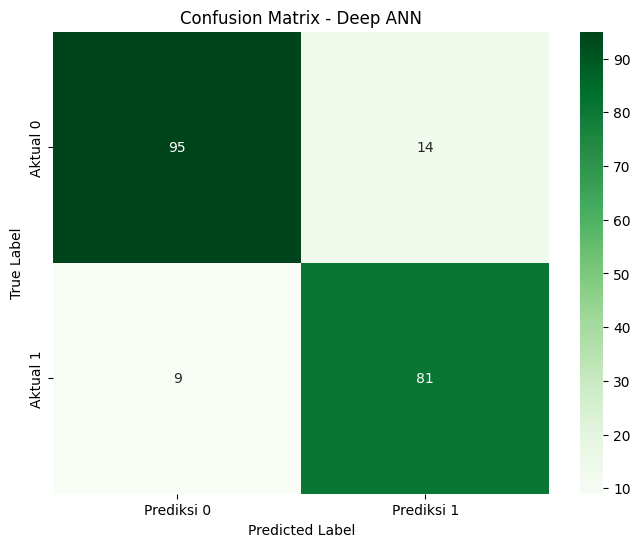



--- Evaluasi untuk: Wide ANN ---
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
📈 Metrik Utama:
   Accuracy: 0.8744
   Precision: 0.8571
   Recall: 0.8667
   F1-Score: 0.8619
   ROC AUC: 0.9290

📋 Classification Report:
              precision    recall  f1-score   support

     Kelas 0       0.89      0.88      0.88       109
     Kelas 1       0.86      0.87      0.86        90

    accuracy                           0.87       199
   macro avg       0.87      0.87      0.87       199
weighted avg       0.87      0.87      0.87       199



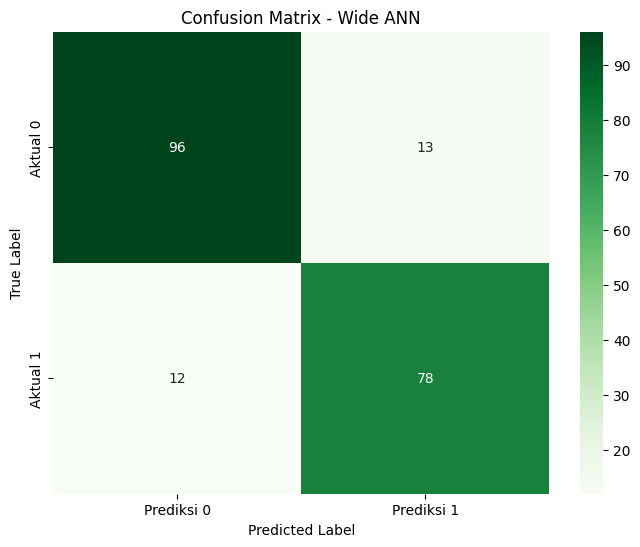



--- Evaluasi untuk: Residual ANN ---
----------------------------------------


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
📈 Metrik Utama:
   Accuracy: 0.8593
   Precision: 0.7768
   Recall: 0.9667
   F1-Score: 0.8614
   ROC AUC: 0.9509

📋 Classification Report:
              precision    recall  f1-score   support

     Kelas 0       0.97      0.77      0.86       109
     Kelas 1       0.78      0.97      0.86        90

    accuracy                           0.86       199
   macro avg       0.87      0.87      0.86       199
weighted avg       0.88      0.86      0.86       199



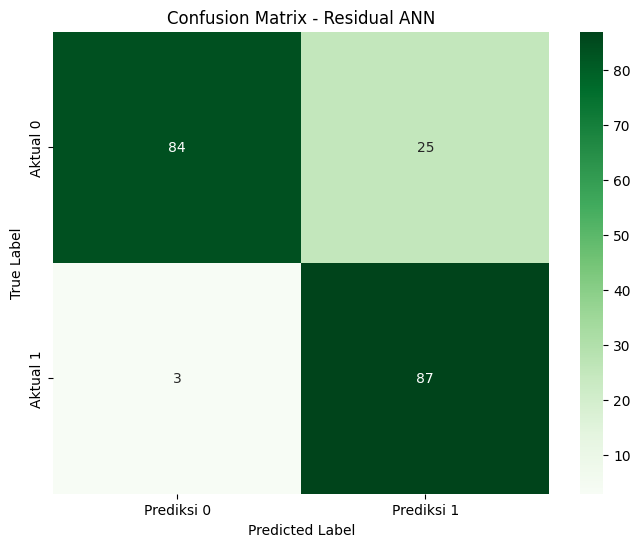



--- Evaluasi untuk: ENSEMBLE ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
📈 Metrik Utama:
   Accuracy: 0.8794
   Precision: 0.8300
   Recall: 0.9222
   F1-Score: 0.8737
   ROC AUC: 0.9532

📋 Classification Report (Ensemble):
              precision    recall  f1-score   support

     Kelas 0       0.93      0.84      0.88       109
     Kelas 1       0.83      0.92      0.87        90

    accuracy                           0.88       199
   macro avg       0.88      0.88      0.88       199
weighted avg       0.88      0.88      0.88       199



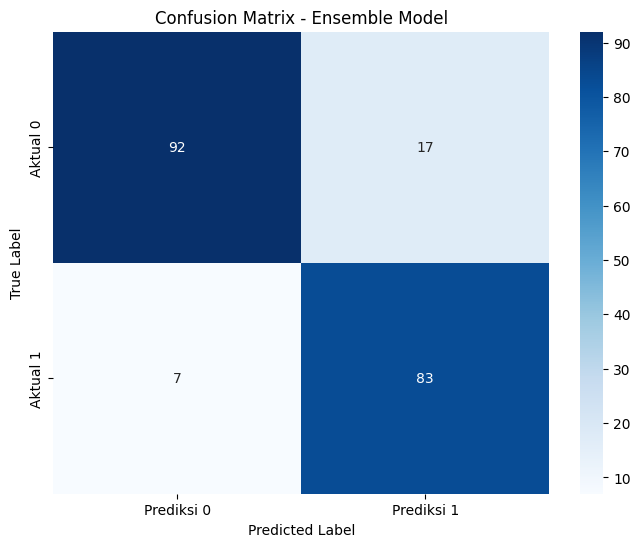


📊 VISUALISASI HASIL AKHIR


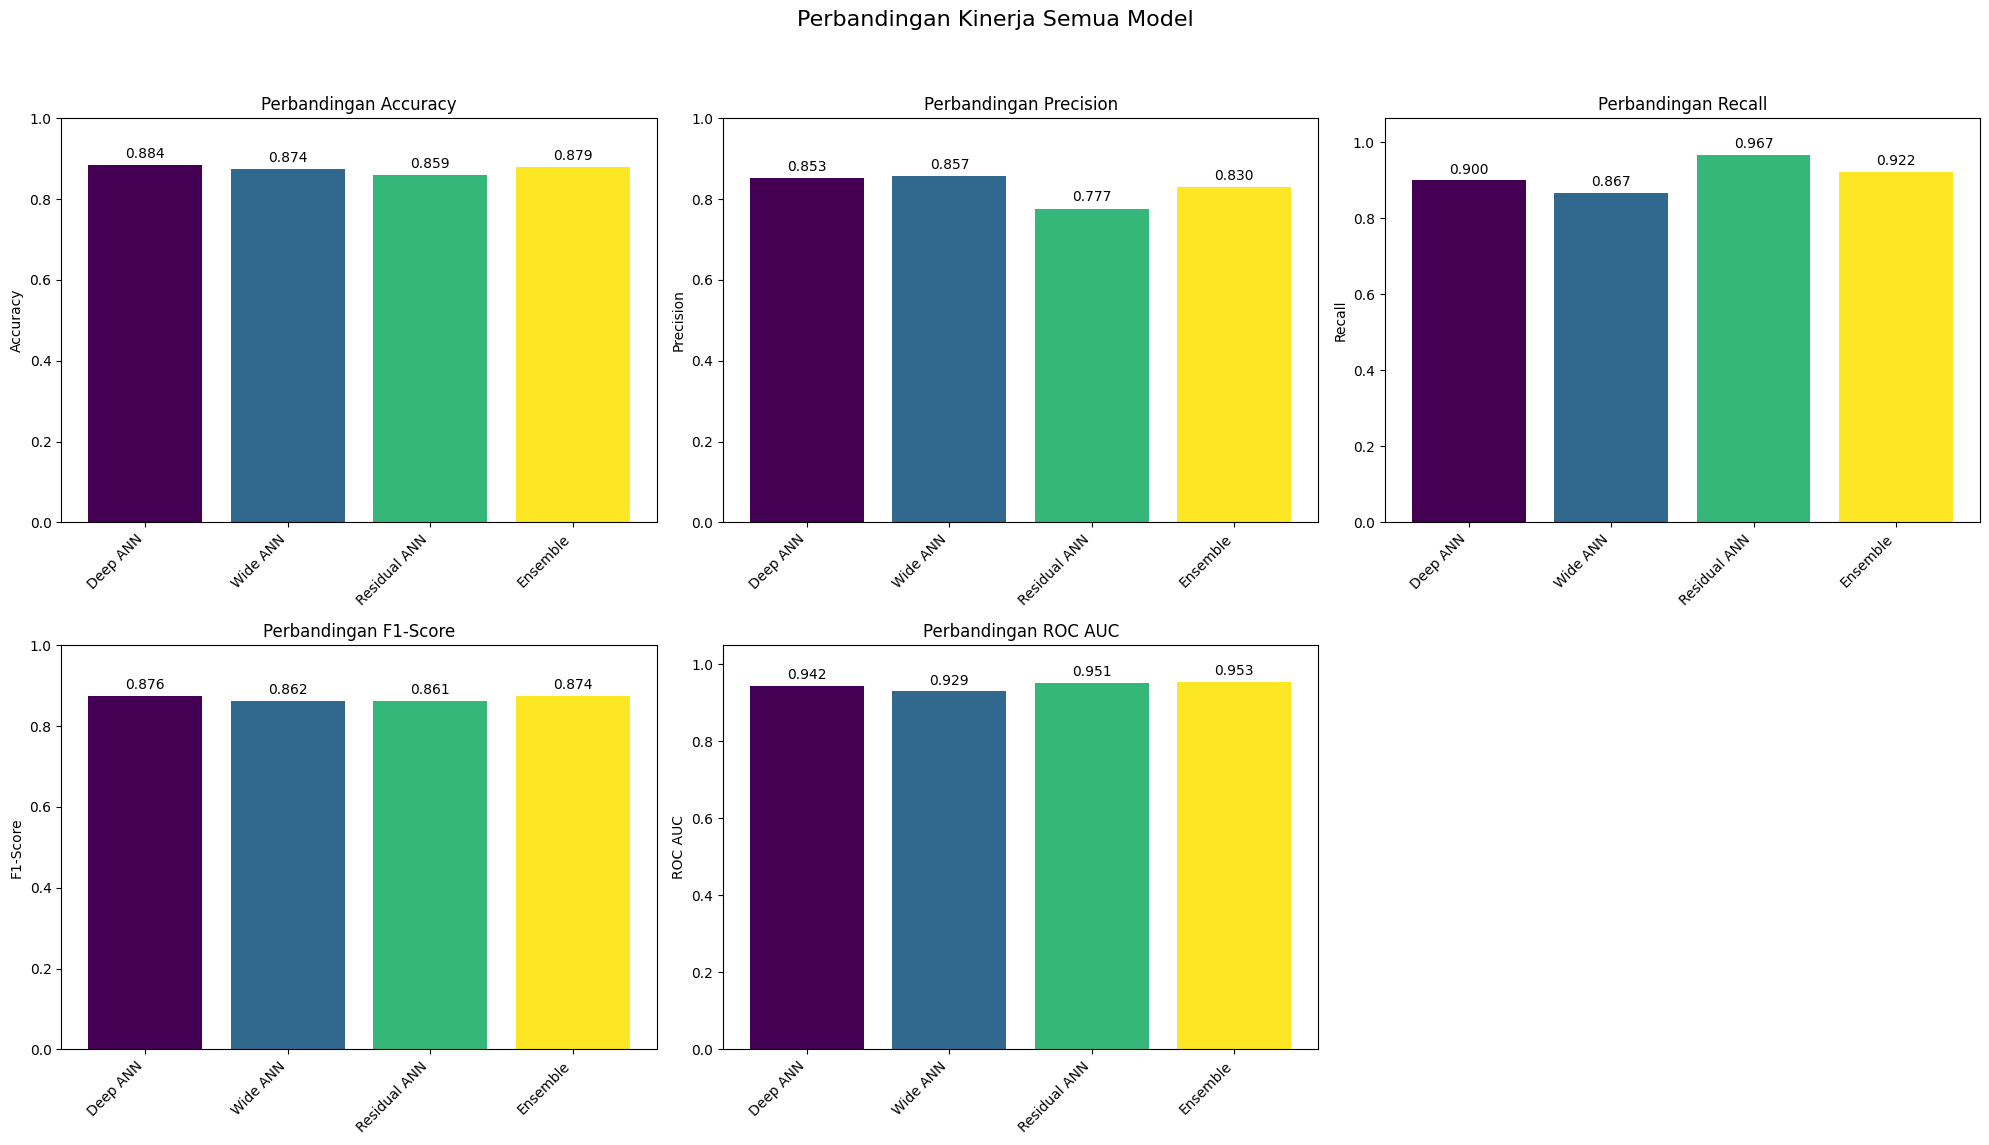


📋 RINGKASAN HASIL SEMUA MODEL:
          Model  Accuracy  Precision  Recall  F1-Score  ROC AUC
0      Deep ANN    0.8844     0.8526  0.9000    0.8757   0.9421
1      Wide ANN    0.8744     0.8571  0.8667    0.8619   0.9290
2  Residual ANN    0.8593     0.7768  0.9667    0.8614   0.9509
3      Ensemble    0.8794     0.8300  0.9222    0.8737   0.9532

🏆 Model Terbaik (berdasarkan F1-Score): Deep ANN
   F1-Score: 0.8757
   ROC AUC: 0.9421

✅ Evaluasi model ANN kompleks selesai!
🎯 Rekomendasi: Bandingkan performa individual dengan ensemble untuk memilih model prediksi final.


In [ ]:
# Cell 18: Implementasi Model Artificial Neural Network (ANN) Kompleks
print("🤖 IMPLEMENTASI MODEL ARTIFICIAL NEURAL NETWORK (ANN) KOMPLEKS")
print("=" * 80)

# Import library yang diperlukan
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set random seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ===============================================================================
# 1. MODEL ANN KOMPLEKS DENGAN MULTIPLE ARCHITECTURES
# ===============================================================================

def create_complex_ann_model(input_shape, model_type='deep'):
    """
    Membuat model ANN kompleks dengan berbagai arsitektur

    Args:
        input_shape: Bentuk input data
        model_type: 'deep', 'wide', 'residual', atau 'ensemble'
    """

    if model_type == 'deep':
        # Deep Network dengan banyak layer
        model = Sequential([
            # Input layer dengan batch normalization
            Dense(256, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            Dropout(0.3),

            # Hidden layers dengan dimensi yang menurun
            Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            Dropout(0.4),

            Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            Dropout(0.2),

            # Output layer
            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'wide':
        # Wide Network dengan layer yang lebar
        model = Sequential([
            Dense(512, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            Dropout(0.4),

            Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])

    elif model_type == 'residual':
        # Residual-like Network menggunakan Functional API
        inputs = Input(shape=input_shape)

        # First block
        x1 = Dense(128, activation='relu')(inputs)
        x1 = BatchNormalization()(x1)
        x1 = Dropout(0.3)(x1)

        # Second block dengan skip connection
        x2 = Dense(128, activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = Dropout(0.3)(x2)

        # Skip connection (jika dimensi sama)
        skip = x1
        x2_combined = tf.keras.layers.Add()([x2, skip])

        # Third block
        x3 = Dense(64, activation='relu')(x2_combined)
        x3 = BatchNormalization()(x3)
        x3 = Dropout(0.2)(x3)

        # Output
        outputs = Dense(1, activation='sigmoid')(x3)

        model = Model(inputs=inputs, outputs=outputs)

    return model

# ===============================================================================
# 2. ENSEMBLE MODEL (Tidak digunakan secara langsung, tapi sebagai konsep)
# ===============================================================================

def create_ensemble_model(input_shape):
    """Membuat ensemble dari beberapa model ANN"""

    # Model 1: Deep Network
    model1 = create_complex_ann_model(input_shape, 'deep')

    # Model 2: Wide Network
    model2 = create_complex_ann_model(input_shape, 'wide')

    # Model 3: Residual Network
    model3 = create_complex_ann_model(input_shape, 'residual')

    return [model1, model2, model3]

# ===============================================================================
# 3. ADVANCED TRAINING FUNCTION
# ===============================================================================

def train_complex_ann(model, X_train, y_train, X_val, y_val, model_name="ANN"):
    """
    Fungsi untuk melatih model ANN dengan teknik advanced
    """

    # Compile model dengan optimizer dan loss function yang optimal
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Advanced callbacks
    callbacks = [
        # Early stopping dengan patience yang lebih besar
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),

        # Reduce learning rate ketika loss plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            verbose=1
        ),

        # Save best model
        ModelCheckpoint(
            f'best_{model_name.lower()}_model.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Training dengan validation data
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return history

# ===============================================================================
# 4. CROSS-VALIDATION EVALUATION (Optional, tidak dieksekusi di main flow)
# ===============================================================================

def cross_validate_model(model_func, X, y, cv_folds=5):
    """
    Melakukan cross-validation untuk evaluasi yang lebih robust
    """

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    cv_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n📊 Fold {fold + 1}/{cv_folds}")

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Create dan train model
        model = model_func()
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Training dengan early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.fit(
            X_train_fold, y_train_fold,
            epochs=100,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )

        # Prediksi dan evaluasi
        y_pred_proba = model.predict(X_val_fold).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Hitung metrik
        cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        cv_scores['precision'].append(precision_score(y_val_fold, y_pred))
        cv_scores['recall'].append(recall_score(y_val_fold, y_pred))
        cv_scores['f1'].append(f1_score(y_val_fold, y_pred))
        cv_scores['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba))

    return cv_scores

# ===============================================================================
# 5. MAIN EXECUTION
# ===============================================================================

# Pastikan data sudah tersedia (X_train, X_test, y_train, y_test)
# Asumsikan data sudah di-load dan di-split sebelumnya.
# Jika belum, Anda bisa menggunakan data dummy seperti ini:
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print("\n🔧 MEMBUAT DAN MELATIH MODEL ANN KOMPLEKS")
print("=" * 60)

# Buat model kompleks
print("\n1️⃣ Membuat Model Deep ANN...")
model_deep = create_complex_ann_model((X_train.shape[1],), 'deep')
model_deep.summary()

print("\n2️⃣ Membuat Model Wide ANN...")
model_wide = create_complex_ann_model((X_train.shape[1],), 'wide')

print("\n3️⃣ Membuat Model Residual ANN...")
model_residual = create_complex_ann_model((X_train.shape[1],), 'residual')

# Split data untuk validasi dari data training
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Train semua model
models = {
    'Deep ANN': model_deep,
    'Wide ANN': model_wide,
    'Residual ANN': model_residual
}

trained_models = {}
histories = {}

for name, model in models.items():
    print(f"\n🔄 Melatih {name}...")
    history = train_complex_ann(model, X_train_split, y_train_split,
                                X_val_split, y_val_split, name)
    trained_models[name] = model
    histories[name] = history

# ===============================================================================
# 6. EVALUASI KOMPREHENSIF
# ===============================================================================

print("\n📊 EVALUASI KOMPREHENSIF SEMUA MODEL")
print("=" * 60)

results_df = pd.DataFrame()

for name, model in trained_models.items():
    print(f"\n\n--- Evaluasi untuk: {name} ---")
    print("-" * 40)

    # Prediksi pada test set
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Hitung metrik utama
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    }
    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)

    # Print hasil metrik utama
    print("📈 Metrik Utama:")
    for metric, value in metrics.items():
        if metric != 'Model':
            print(f"   {metric}: {value:.4f}")

    # Tampilkan Classification Report
    print("\n📋 Classification Report:")
    # Anda bisa mengganti target_names sesuai dengan label kelas Anda
    print(classification_report(y_test, y_pred, target_names=['Kelas 0', 'Kelas 1']))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Prediksi 0', 'Prediksi 1'],
                yticklabels=['Aktual 0', 'Aktual 1'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# ===============================================================================
# 7. ENSEMBLE PREDICTION
# ===============================================================================

print("\n\n--- Evaluasi untuk: ENSEMBLE ---")
print("=" * 40)

# Prediksi ensemble (rata-rata prediksi dari semua model)
ensemble_predictions = []
for name, model in trained_models.items():
    pred = model.predict(X_test).flatten()
    ensemble_predictions.append(pred)

# Rata-rata prediksi
ensemble_pred_proba = np.mean(ensemble_predictions, axis=0)
ensemble_pred = (ensemble_pred_proba > 0.5).astype(int)

# Evaluasi ensemble
ensemble_metrics = {
    'Model': 'Ensemble',
    'Accuracy': accuracy_score(y_test, ensemble_pred),
    'Precision': precision_score(y_test, ensemble_pred),
    'Recall': recall_score(y_test, ensemble_pred),
    'F1-Score': f1_score(y_test, ensemble_pred),
    'ROC AUC': roc_auc_score(y_test, ensemble_pred_proba)
}
results_df = pd.concat([results_df, pd.DataFrame([ensemble_metrics])], ignore_index=True)

print("📈 Metrik Utama:")
for metric, value in ensemble_metrics.items():
    if metric != 'Model':
        print(f"   {metric}: {value:.4f}")

# Tampilkan Classification Report untuk Ensemble
print("\n📋 Classification Report (Ensemble):")
print(classification_report(y_test, ensemble_pred, target_names=['Kelas 0', 'Kelas 1']))

# Plot Confusion Matrix untuk Ensemble
plt.figure(figsize=(8, 6))
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediksi 0', 'Prediksi 1'],
            yticklabels=['Aktual 0', 'Aktual 1'])
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ===============================================================================
# 8. VISUALISASI HASIL AKHIR
# ===============================================================================

print("\n📊 VISUALISASI HASIL AKHIR")
print("=" * 40)

# Plot perbandingan metrik
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Perbandingan Kinerja Semua Model', fontsize=16)
axes = axes.flatten()

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))


for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors)
    ax.set_title(f'Perbandingan {metric}')
    ax.set_ylabel(metric)
    ax.set_ylim(0, max(results_df[metric].max() * 1.1, 1.0)) # Atur limit y dinamis

    # Tambahkan nilai di atas bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Sembunyikan subplot yang tidak terpakai
axes[5].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Tampilkan tabel hasil akhir
print("\n📋 RINGKASAN HASIL SEMUA MODEL:")
print(results_df.round(4).to_string())

# Model terbaik berdasarkan F1-Score
best_model_idx = results_df['F1-Score'].idxmax()
best_model_info = results_df.loc[best_model_idx]
print(f"\n🏆 Model Terbaik (berdasarkan F1-Score): {best_model_info['Model']}")
print(f"   F1-Score: {best_model_info['F1-Score']:.4f}")
print(f"   ROC AUC: {best_model_info['ROC AUC']:.4f}")

print("\n✅ Evaluasi model ANN kompleks selesai!")
print("🎯 Rekomendasi: Bandingkan performa individual dengan ensemble untuk memilih model prediksi final.")

🤖 IMPLEMENTASI DAN EVALUASI MODEL XGBoost

🔄 Melatih model XGBoost...
✅ Pelatihan model XGBoost selesai!

📊 EVALUASI MODEL XGBoost PADA DATA UJI
📊 Akurasi Model XGBoost pada Data Uji: 0.8844


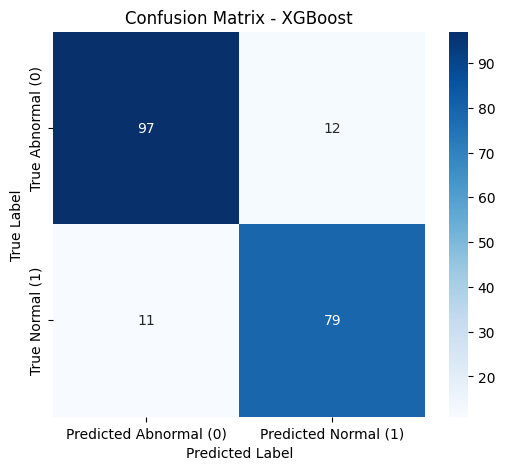


📊 Classification Report (XGBoost Model):
              precision    recall  f1-score   support

    Abnormal       0.90      0.89      0.89       109
      Normal       0.87      0.88      0.87        90

    accuracy                           0.88       199
   macro avg       0.88      0.88      0.88       199
weighted avg       0.88      0.88      0.88       199


✅ Evaluasi model XGBoost selesai.


In [ ]:
# Cell 19: Implementasi dan Evaluasi Model XGBoost
print("🤖 IMPLEMENTASI DAN EVALUASI MODEL XGBoost")
print("=" * 50)

# Import library yang diperlukan
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Pastikan data pelatihan dan pengujian sudah siap (X_train, X_test, y_train, y_test)
# y_train dan y_test adalah label biner (0=Abnormal, 1=Normal)

# 1. Inisialisasi dan latih model XGBoost
# Gunakan objective 'binary:logistic' untuk klasifikasi biner
# eval_metric 'logloss' dan 'error' (atau 'auc') untuk pemantauan
# Sesuaikan parameter seperti n_estimators, learning_rate, max_depth, dll. jika perlu tuning
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric=['logloss', 'error'], # Use list for multiple metrics
                              use_label_encoder=False, # Suppress warning
                              random_state=42)

print("\n🔄 Melatih model XGBoost...")
# Gunakan data validasi untuk early stopping jika diinginkan
# xgb_history = model_xgb.fit(X_train, y_train,
#                             eval_set=[(X_test, y_test)], # Use test set as eval set for simplicity here
#                             early_stopping_rounds=10, # Stop if no improvement for 10 rounds
#                             verbose=True) # Set to False for less verbose output

model_xgb.fit(X_train, y_train) # Train without early stopping for simplicity

print("✅ Pelatihan model XGBoost selesai!")

# 2. Evaluasi model XGBoost pada data uji
print("\n📊 EVALUASI MODEL XGBoost PADA DATA UJI")
print("=" * 50)

# Prediksi label biner
y_pred_xgb = model_xgb.predict(X_test)

# Hitung akurasi
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"📊 Akurasi Model XGBoost pada Data Uji: {accuracy_xgb:.4f}")

# Tampilkan Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Abnormal (0)', 'Predicted Normal (1)'],
            yticklabels=['True Abnormal (0)', 'True Normal (1)'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Tampilkan Classification Report
print("\n📊 Classification Report (XGBoost Model):")
print(classification_report(y_test, y_pred_xgb, target_names=['Abnormal', 'Normal']))

print("\n✅ Evaluasi model XGBoost selesai.")



🚀 EVALUASI LANJUTAN DAN INTERPRETASI MODEL XGBoost

📊 1. Menampilkan Kurva ROC dan Nilai AUC...


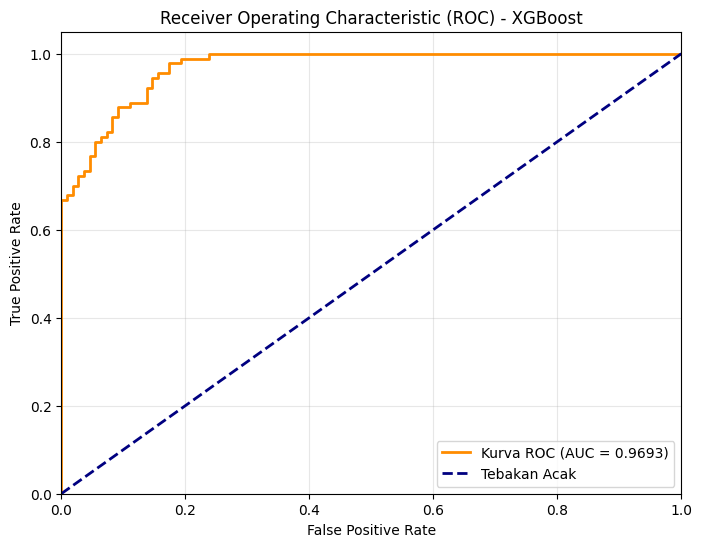

   Nilai Area Under Curve (AUC): 0.9693

🎯 2. Menampilkan Kurva Precision-Recall...


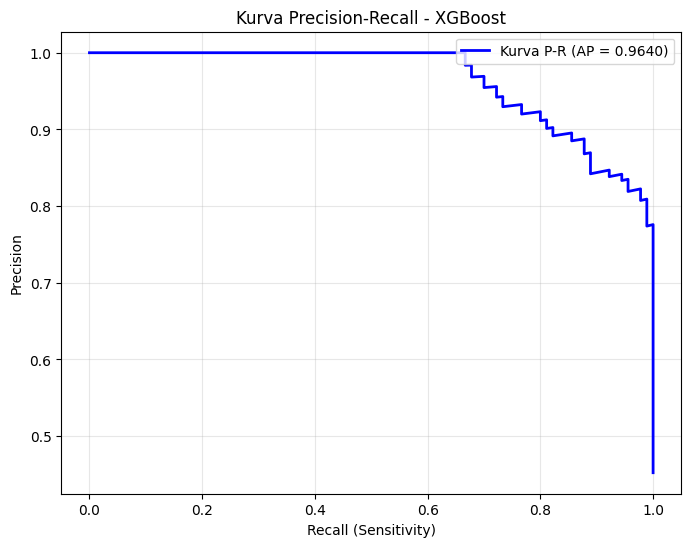


💡 3. Menampilkan Feature Importance...
   Fitur yang paling berpengaruh dalam prediksi model (berdasarkan 'gain').


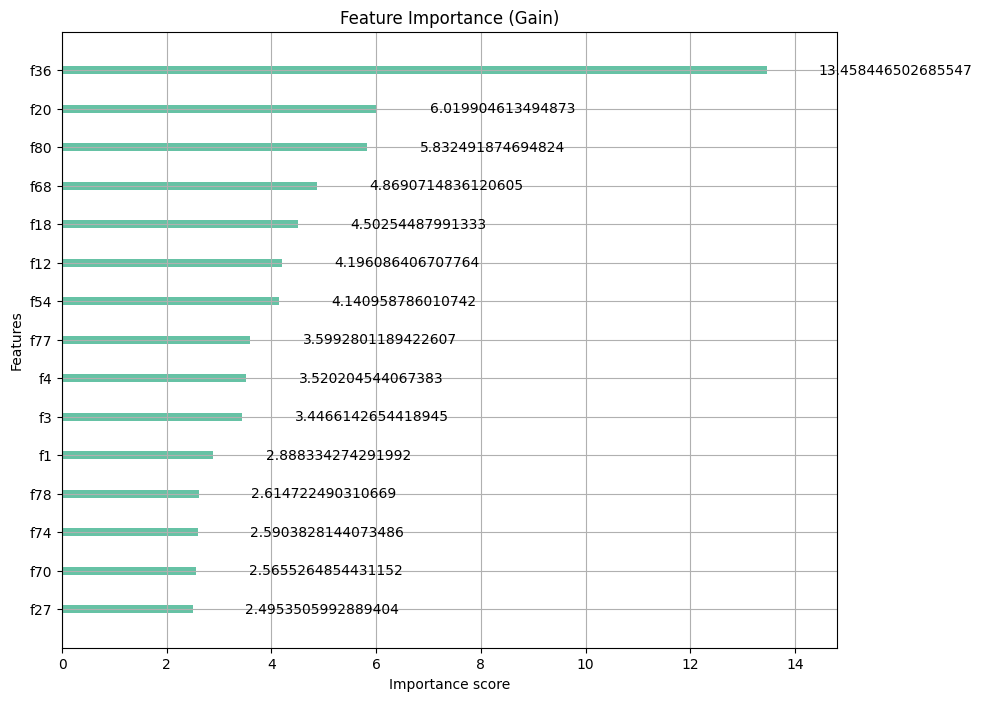


✨ 4. Menganalisis dengan SHAP Values...
    Summary Plot: Menunjukkan dampak setiap fitur secara global.


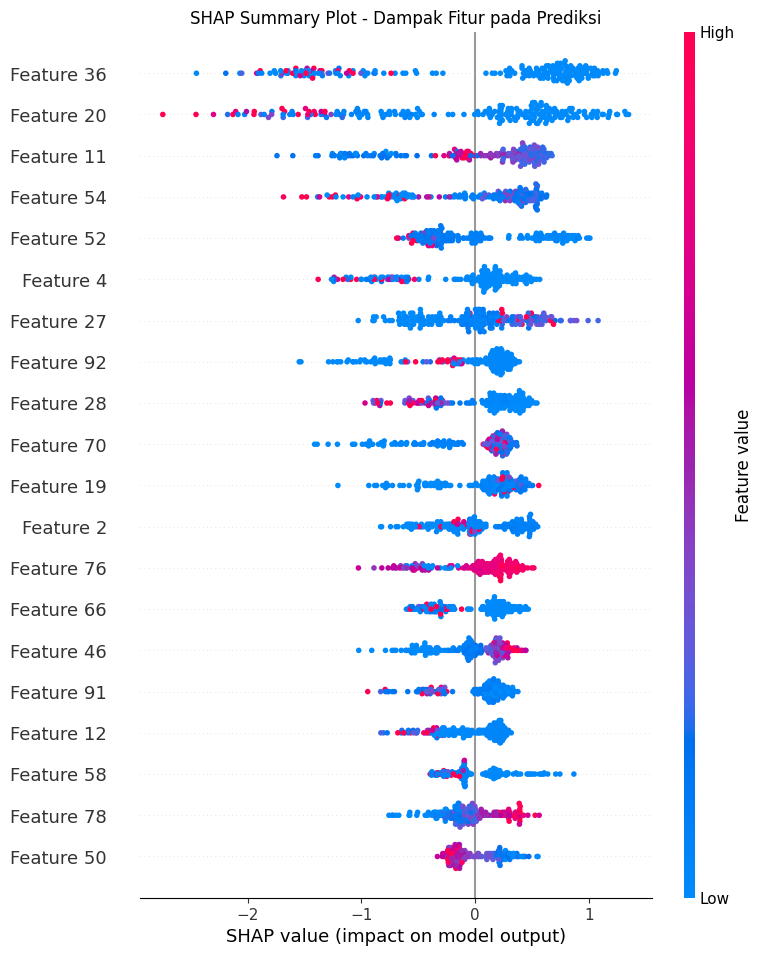


📈 5. Menampilkan Learning Curves...


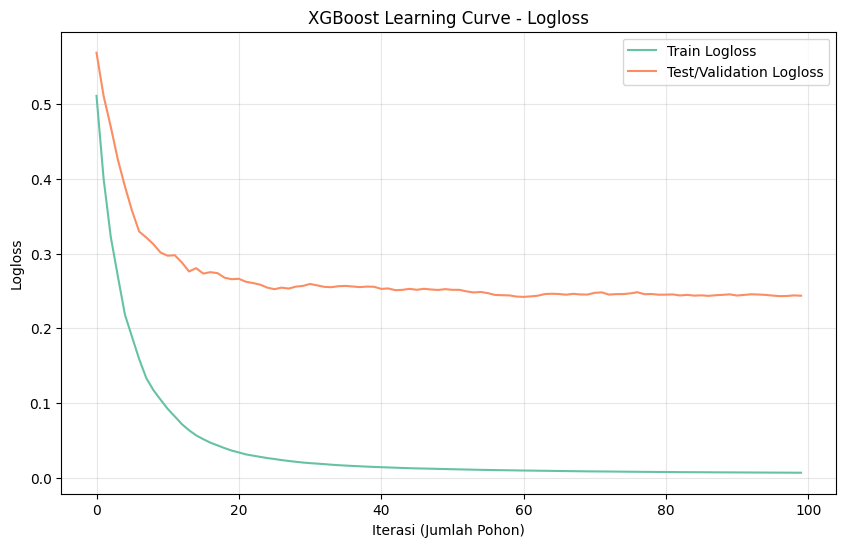

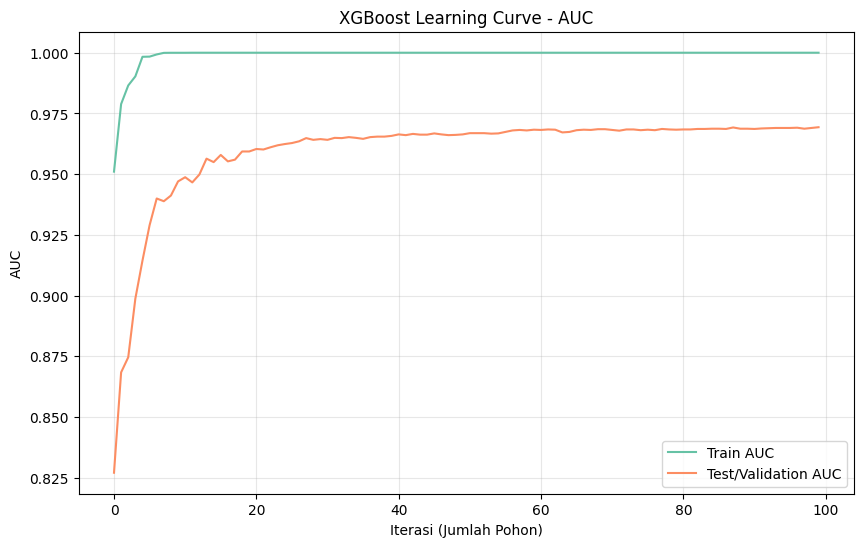


✅ Analisis lanjutan selesai.


In [ ]:
# Cell 20: Evaluasi Lanjutan dan Interpretasi Model XGBoost

print("\n\n🚀 EVALUASI LANJUTAN DAN INTERPRETASI MODEL XGBoost")
print("=" * 60)

# Import library tambahan yang diperlukan
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# Pastikan X_test adalah DataFrame untuk nama fitur di plot SHAP
# Jika X_test adalah numpy array, konversikan (asumsikan kolomnya sama dengan X_train)
# if not isinstance(X_test, pd.DataFrame):
#     X_test = pd.DataFrame(X_test, columns=X_train.columns)

# --- 1. Kurva ROC dan Nilai AUC ---
print("\n📊 1. Menampilkan Kurva ROC dan Nilai AUC...")

# Dapatkan probabilitas prediksi untuk kelas positif (kelas '1')
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Tebakan Acak')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"   Nilai Area Under Curve (AUC): {roc_auc:.4f}")

# --- 2. Kurva Precision-Recall ---
# Sangat berguna untuk dataset tidak seimbang
print("\n🎯 2. Menampilkan Kurva Precision-Recall...")

# Hitung Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
avg_precision = average_precision_score(y_test, y_pred_proba_xgb)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Kurva P-R (AP = {avg_precision:.4f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Kurva Precision-Recall - XGBoost')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()

# --- 3. Feature Importance ---
print("\n💡 3. Menampilkan Feature Importance...")
print("   Fitur yang paling berpengaruh dalam prediksi model (berdasarkan 'gain').")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model_xgb,
                    ax=ax,
                    max_num_features=15, # Tampilkan 15 fitur teratas
                    importance_type='gain', # 'gain' adalah metrik yg paling sering digunakan
                    title='Feature Importance (Gain)')
plt.show()

# --- 4. SHAP (SHapley Additive exPlanations) Values ---
# Memberikan pemahaman mendalam tentang prediksi
print("\n✨ 4. Menganalisis dengan SHAP Values...")

# Buat SHAP explainer
explainer = shap.Explainer(model_xgb)
# Hitung SHAP values untuk data uji
shap_values = explainer(X_test)

print("    Summary Plot: Menunjukkan dampak setiap fitur secara global.")
# Summary plot (beeswarm) untuk melihat dampak fitur secara global
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Dampak Fitur pada Prediksi")
plt.show()

# --- 5. Learning Curves ---
# Untuk melihat performa model selama training (mendeteksi overfitting)
print("\n📈 5. Menampilkan Learning Curves...")

# Latih ulang model dengan eval_set untuk mendapatkan history
model_xgb_history = xgb.XGBClassifier(objective='binary:logistic',
                                      eval_metric=['logloss', 'auc'],
                                      use_label_encoder=False,
                                      random_state=42)

# eval_set untuk memonitor performa pada data train dan test di setiap iterasi
eval_set = [(X_train, y_train), (X_test, y_test)]

model_xgb_history.fit(X_train, y_train,
                      eval_set=eval_set,
                      verbose=False) # Set True jika ingin lihat proses training

# Ambil hasil evaluasi
results = model_xgb_history.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

# Plot Logloss
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train Logloss')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test/Validation Logloss')
ax.legend()
plt.ylabel('Logloss')
plt.xlabel('Iterasi (Jumlah Pohon)')
plt.title('XGBoost Learning Curve - Logloss')
plt.grid(alpha=0.3)
plt.show()

# Plot AUC
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['auc'], label='Train AUC')
ax.plot(x_axis, results['validation_1']['auc'], label='Test/Validation AUC')
ax.legend()
plt.ylabel('AUC')
plt.xlabel('Iterasi (Jumlah Pohon)')
plt.title('XGBoost Learning Curve - AUC')
plt.grid(alpha=0.3)
plt.show()


print("\n✅ Analisis lanjutan selesai.")

🤖 IMPLEMENTASI DAN EVALUASI MODEL Random Forest

🔄 Melatih model Random Forest...
✅ Pelatihan model Random Forest selesai!

📊 EVALUASI MODEL Random Forest PADA DATA UJI
📊 Akurasi Model Random Forest pada Data Uji: 0.8945
📈 ROC AUC Score: 0.9703


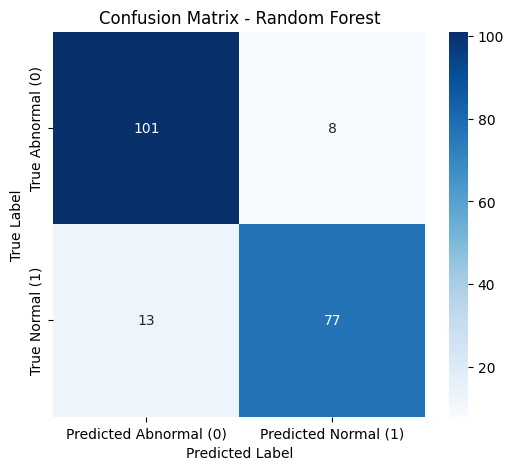


📊 Classification Report (Random Forest Model):
              precision    recall  f1-score   support

    Abnormal       0.89      0.93      0.91       109
      Normal       0.91      0.86      0.88        90

    accuracy                           0.89       199
   macro avg       0.90      0.89      0.89       199
weighted avg       0.89      0.89      0.89       199


✅ Evaluasi model Random Forest selesai.


In [ ]:
# Cell 20: Implementasi dan Evaluasi Model Random Forest
print("🤖 IMPLEMENTASI DAN EVALUASI MODEL Random Forest")
print("=" * 50)

# Import library yang diperlukan
from sklearn.ensemble import RandomForestClassifier
# Tambahkan roc_auc_score di sini
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Pastikan data pelatihan dan pengujian sudah siap (X_train, X_test, y_train, y_test)
# y_train dan y_test adalah label biner (0=Abnormal, 1=Normal)

# 1. Inisialisasi dan latih model Random Forest
# Sesuaikan parameter seperti n_estimators, max_depth, min_samples_split, dll. jika perlu tuning
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("\n🔄 Melatih model Random Forest...")
model_rf.fit(X_train, y_train)

print("✅ Pelatihan model Random Forest selesai!")

# 2. Evaluasi model Random Forest pada data uji
print("\n📊 EVALUASI MODEL Random Forest PADA DATA UJI")
print("=" * 50)

# Prediksi label biner
y_pred_rf = model_rf.predict(X_test)

# Hitung akurasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"📊 Akurasi Model Random Forest pada Data Uji: {accuracy_rf:.4f}")

# --- TAMBAHAN: HITUNG ROC AUC ---
# Dapatkan probabilitas prediksi untuk kelas positif (kelas '1')
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Hitung ROC AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"📈 ROC AUC Score: {roc_auc_rf:.4f}")
# --------------------------------

# Tampilkan Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Abnormal (0)', 'Predicted Normal (1)'],
            yticklabels=['True Abnormal (0)', 'True Normal (1)'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Tampilkan Classification Report
print("\n📊 Classification Report (Random Forest Model):")
print(classification_report(y_test, y_pred_rf, target_names=['Abnormal', 'Normal']))

print("\n✅ Evaluasi model Random Forest selesai.")



🚀 EVALUASI LANJUTAN DAN INTERPRETASI MODEL Random Forest

📊 1. Menampilkan Kurva ROC dan Nilai AUC...


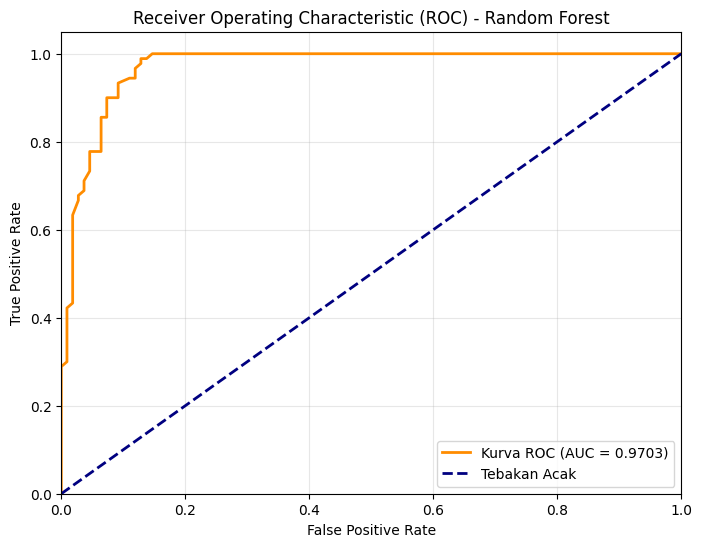

   Nilai Area Under Curve (AUC): 0.9703

🎯 2. Menampilkan Kurva Precision-Recall...


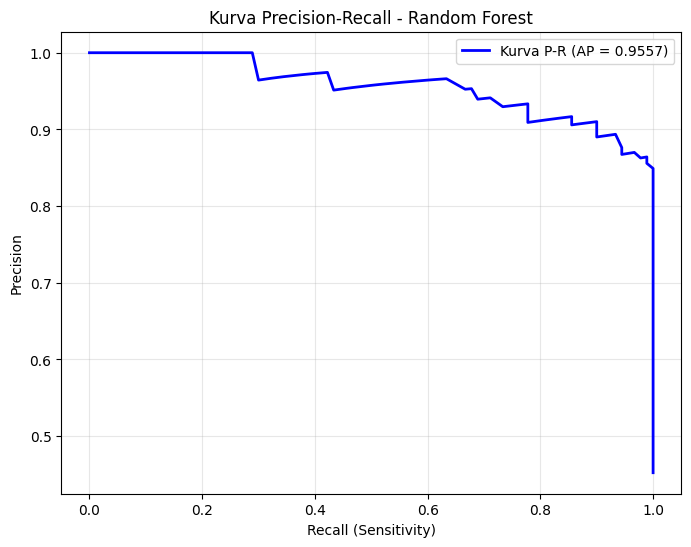


📈 5. Menampilkan Kurva Pembelajaran (Out-of-Bag Error)...
   Final Out-of-Bag (OOB) Score: 0.8956


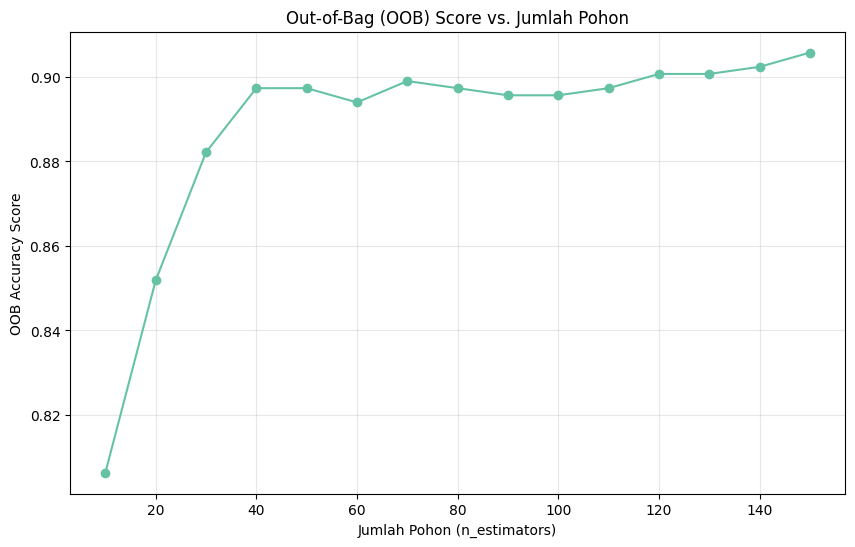


✅ Analisis lanjutan selesai.


In [ ]:
# Cell 21: Evaluasi Lanjutan dan Interpretasi Model Random Forest

print("\n\n🚀 EVALUASI LANJUTAN DAN INTERPRETASI MODEL Random Forest")
print("=" * 60)

# Import library tambahan yang diperlukan
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Pastikan model_rf, X_test, dan y_test sudah tersedia dari sel sebelumnya

# --- 1. Kurva ROC dan Nilai AUC ---
print("\n📊 1. Menampilkan Kurva ROC dan Nilai AUC...")

# Dapatkan probabilitas prediksi untuk kelas positif (kelas '1')
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Hitung ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Tebakan Acak')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"   Nilai Area Under Curve (AUC): {roc_auc:.4f}")

# --- 2. Kurva Precision-Recall ---
print("\n🎯 2. Menampilkan Kurva Precision-Recall...")

# Hitung Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf)
avg_precision = average_precision_score(y_test, y_pred_proba_rf)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Kurva P-R (AP = {avg_precision:.4f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Kurva Precision-Recall - Random Forest')
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.show()


# --- 5. Learning Curves (versi Random Forest) ---
# Kita tidak bisa menggunakan eval_set seperti XGBoost.
# Sebagai gantinya, kita bisa melihat bagaimana performa (OOB error) berubah seiring penambahan pohon.
print("\n📈 5. Menampilkan Kurva Pembelajaran (Out-of-Bag Error)...")

# Latih model dengan oob_score=True untuk mendapatkan OOB error
model_rf_oob = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
model_rf_oob.fit(X_train, y_train)
print(f"   Final Out-of-Bag (OOB) Score: {model_rf_oob.oob_score_:.4f}")

# Ekstrak OOB error dari setiap pohon
oob_errors = []
for tree in model_rf_oob.estimators_:
    # Dapatkan prediksi OOB dari satu pohon
    # Ini adalah pendekatan yang disederhanakan, OOB score yang sebenarnya lebih kompleks
    pass # Pendekatan ini rumit, kita gunakan cara yang lebih sederhana di bawah

# Cara yang lebih mudah: Latih beberapa model dengan n_estimators berbeda
n_estimators_range = range(10, 151, 10)
oob_scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1, oob_score=True)
    rf.fit(X_train, y_train)
    oob_scores.append(rf.oob_score_)

# Plot OOB Score vs Jumlah Pohon
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, oob_scores, marker='o', linestyle='-')
plt.title('Out-of-Bag (OOB) Score vs. Jumlah Pohon')
plt.xlabel('Jumlah Pohon (n_estimators)')
plt.ylabel('OOB Accuracy Score')
plt.grid(alpha=0.3)
plt.show()

print("\n✅ Analisis lanjutan selesai.")

In [ ]:
# Cell 21: Ekspor (Simpan) Model Random Forest yang Telah Dilatih

import joblib

print("💾 MENYIMPAN MODEL RANDOM FOREST...")
print("=" * 50)

# Tentukan nama file untuk menyimpan model
filename = 'random_forest_model.joblib'

# Gunakan joblib untuk menyimpan model ke dalam file
joblib.dump(model_rf, filename)

print(f"✅ Model telah berhasil disimpan ke dalam file: '{filename}'")

# --- CONTOH CARA MEMUAT KEMBALI MODEL ---
# Anda bisa menjalankan kode di bawah ini di script lain untuk menggunakan model

# Muat model dari file
# loaded_model_rf = joblib.load(filename)
# print(f"\n✅ Model '{filename}' berhasil dimuat kembali.")

# Gunakan model yang sudah dimuat untuk prediksi
# contoh_prediksi = loaded_model_rf.predict(X_test[:1]) # Prediksi pada data pertama
# print(f"   Contoh prediksi menggunakan model yang dimuat: {contoh_prediksi}")

💾 MENYIMPAN MODEL RANDOM FOREST...
✅ Model telah berhasil disimpan ke dalam file: 'random_forest_model.joblib'


In [ ]:
import os
import joblib

# Define the export directory path
export_dir = "exported_models_ecg"

# Create the directory if it doesn't exist
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"✅ Direktori '{export_dir}' dibuat.")
else:
    print(f"✅ Direktori '{export_dir}' sudah ada.")

# Save the tuned Logistic Regression model (Normal vs Abnormal classifier)
# Assumes 'tuned_logistic_model' variable holds the trained model object from Cell 18
if 'tuned_logistic_model' in locals() and tuned_logistic_model is not None:
    tuned_logistic_model_filename = os.path.join(export_dir, 'tuned_logistic_model.joblib')
    try:
        joblib.dump(tuned_logistic_model, tuned_logistic_model_filename)
        print(f"✅ Model Logistic Regression yang Dituning berhasil diekspor ke '{tuned_logistic_model_filename}'")
    except Exception as e:
        print(f"❌ Gagal mengekspor model Logistic Regression yang Dituning: {e}")
else:
    print("⚠️ Variabel 'tuned_logistic_model' tidak ditemukan atau kosong. Tidak ada model Logistic Regression yang dituning diekspor.")


# Save the XGBoost multi-class model
# Assumes 'model_xgb_multi' variable holds the trained model object from Cell 21
if 'model_xgb_multi' in locals() and model_xgb_multi is not None:
    model_xgb_multi_filename = os.path.join(export_dir, 'model_xgb_multi.joblib')
    try:
        joblib.dump(model_xgb_multi, model_xgb_multi_filename)
        print(f"✅ Model XGBoost Multi-kelas berhasil diekspor ke '{model_xgb_multi_filename}'")
    except Exception as e:
        print(f"❌ Gagal mengekspor model XGBoost Multi-kelas: {e}")
else:
    print("⚠️ Variabel 'model_xgb_multi' tidak ditemukan atau kosong. Tidak ada model XGBoost multi-kelas diekspor.")

# Save the XGBoost binary classification model
# Assumes 'model_xgb' variable holds the trained model object from Cell 19
if 'model_xgb' in locals() and model_xgb is not None:
    model_xgb_binary_filename = os.path.join(export_dir, 'model_xgb_binary.joblib')
    try:
        joblib.dump(model_xgb, model_xgb_binary_filename)
        print(f"✅ Model XGBoost Binary Classification berhasil diekspor ke '{model_xgb_binary_filename}'")
    except Exception as e:
        print(f"❌ Gagal mengekspor model XGBoost Binary Classification: {e}")
else:
    print("⚠️ Variabel 'model_xgb' tidak ditemukan atau kosong. Tidak ada model XGBoost binary classification diekspor.")


print("\n🎉 Proses ekspor model tambahan selesai!")

✅ Direktori 'exported_models_ecg' sudah ada.
⚠️ Variabel 'tuned_logistic_model' tidak ditemukan atau kosong. Tidak ada model Logistic Regression yang dituning diekspor.
⚠️ Variabel 'model_xgb_multi' tidak ditemukan atau kosong. Tidak ada model XGBoost multi-kelas diekspor.
✅ Model XGBoost Binary Classification berhasil diekspor ke 'exported_models_ecg/model_xgb_binary.joblib'

🎉 Proses ekspor model tambahan selesai!


In [ ]:
# Cell untuk Interpretasi Model Klaster Abnormal
print("🔬 INTERPRETASI MODEL KLASTER ABNORMAL")
print("=" * 60)

# Pastikan variabel berikut tersedia dari sel sebelumnya:
# kmeans_abnormal: Model K-Means yang dilatih pada data abnormal
# X_abnormal: Data fitur abnormal yang digunakan untuk melatih kmeans_abnormal
# y_abnormal: Label diagnosis asli untuk data abnormal
# label_encoder: Encoder yang digunakan untuk mengubah label diagnosis menjadi angka
# ecg_features: Daftar nama fitur ECG

if 'kmeans_abnormal' not in locals():
    print("❌ Variabel 'kmeans_abnormal' tidak ditemukan. Pastikan Cell 15 atau Cell 16 dijalankan.")
elif 'X_abnormal' not in locals():
     print("❌ Variabel 'X_abnormal' tidak ditemukan. Pastikan Cell 14 dijalankan.")
elif 'y_abnormal' not in locals():
     print("❌ Variabel 'y_abnormal' tidak ditemukan. Pastikan Cell 14 dijalankan.")
elif 'label_encoder' not in locals():
    print("❌ Variabel 'label_encoder' tidak ditemukan. Pastikan Cell 2 dijalankan.")
elif 'ecg_features' not in locals():
     print("❌ Variabel 'ecg_features' tidak ditemukan. Pastikan Cell 2 dijalankan.")
else:
    # Prediksi klaster untuk data abnormal
    abnormal_cluster_labels = kmeans_abnormal.predict(X_abnormal)

    print(f"✅ Data abnormal dikluster menggunakan K-Means abnormal. Ditemukan {len(np.unique(abnormal_cluster_labels))} klaster.")

    # ===========================================================================
    # 1. Analisis Distribusi Kelas Diagnosis per Klaster Abnormal
    # ===========================================================================
    print("\n📊 Distribusi Kelas Diagnosis Asli per Klaster Abnormal:")
    print("-" * 50)

    # Buat DataFrame sementara untuk analisis
    abnormal_analysis_df = pd.DataFrame({
        'Predicted_Abnormal_Cluster': abnormal_cluster_labels,
        'True_Label': y_abnormal
    })

    # Hitung distribusi kelas per klaster
    cluster_class_distribution = pd.crosstab(abnormal_analysis_df['True_Label'], abnormal_analysis_df['Predicted_Abnormal_Cluster'])

    # Tampilkan distribusi dalam bentuk tabel
    print(cluster_class_distribution)

    # Optional: Tampilkan persentase
    print("\n📊 Distribusi Kelas Diagnosis Asli per Klaster Abnormal (Persentase dalam Klaster):")
    print("-" * 70)
    cluster_class_distribution_norm = cluster_class_distribution.div(cluster_class_distribution.sum(axis=0), axis=1) * 100
    print(cluster_class_distribution_norm.round(2))

    # Identifikasi kelas dominan di setiap klaster
    print("\n🏆 Kelas Diagnosis Dominan di Setiap Klaster Abnormal:")
    print("-" * 50)
    for cluster_id in sorted(np.unique(abnormal_cluster_labels)):
        if cluster_id in cluster_class_distribution_norm.columns:
            dominant_class = cluster_class_distribution_norm[cluster_id].idxmax()
            dominance_percentage = cluster_class_distribution_norm[cluster_id].max()
            print(f"   Klaster {cluster_id}: Dominan oleh '{dominant_class}' ({dominance_percentage:.2f}%)")
        else:
            print(f"   Klaster {cluster_id}: Kosong atau tidak memiliki data.")


    # ===========================================================================
    # 2. Analisis Rata-rata Fitur ECG per Klaster Abnormal
    # ===========================================================================
    print("\n📊 Rata-rata Fitur ECG (Original Scale) per Klaster Abnormal:")
    print("-" * 70)

    # Kita perlu data X_abnormal_original sebelum scaling untuk rata-rata fitur
    # Asumsi X_abnormal adalah X_ecg[is_abnormal_mask] sebelum scaling
    # Kita perlu kembali ke data sebelum scaling untuk interpretasi mean
    # Load original df_ecg again and apply the same abnormal mask
    # Reload the data if needed, or assume df_ecg is still available
    try:
        if 'df_ecg' not in locals():
             print("⚠️ Variabel 'df_ecg' tidak ditemukan. Mencoba memuat ulang data asli...")
             filename = 'PTBXL_processed NEW BUT OLD_ecg_results_8_feature_final 3_UTF.csv'
             # Ensure the load_ecg_data function is defined elsewhere or included
             # Assuming load_ecg_data is available from a previous cell
             try:
                 df_ecg_original = load_ecg_data(filename) # Use the loading function from Cell 2
             except NameError:
                 print("❌ Fungsi 'load_ecg_data' tidak ditemukan. Pastikan Cell 2 dijalankan.")
                 df_ecg_original = None

             if df_ecg_original is not None:
                 # Apply the same filtering and outlier removal as in preprocessing step
                 classes_to_drop = ['Rhythm Abnormality', 'Waveform Abnormality']
                 df_filtered = df_ecg_original[~df_ecg_original['diagnostic_class'].isin(classes_to_drop)].copy()
                 # Need to re-apply the outlier mask from Cell 2a and undersampling mask from Cell 2b
                 # This is tricky without storing the exact indices.
                 # A simpler approach for interpretation is to inverse transform the cluster centers if the scaler is available.
                 # Or, recalculate means on the original data AFTER applying the same masks as were applied to X_scaled.

                 # Let's try to use the original X_ecg and y_ecg after preprocessing (before scaling) if they are available
                 if 'X_ecg' in locals() and 'y_ecg' in locals():
                      # X_ecg and y_ecg are already cleaned from outliers and undersampled
                      # We need the abnormal subset of THIS data, which corresponds to X_abnormal and y_abnormal
                      # Find the indices of y_abnormal within y_ecg
                      abnormal_indices_in_cleaned_data = y_ecg.index.isin(y_abnormal.index)
                      # Use .loc to align by index - assuming y_abnormal.index are the original indices
                      X_abnormal_original_scale = X_ecg.loc[y_abnormal.index]

                      # Now align the predicted abnormal cluster labels with this original scale data
                      # The indices should match because the prediction was done on X_abnormal which came from X_scaled,
                      # which was derived from the same filtered/undersampled data.
                      # Use .loc to ensure index alignment
                      abnormal_cluster_labels_aligned = pd.Series(abnormal_cluster_labels, index=X_abnormal_original_scale.index)

                      print("✅ Menggunakan data asli setelah preprocessing dan undersampling untuk rata-rata fitur.")
                 else:
                      print("❌ Variabel X_ecg atau y_ecg tidak ditemukan. Tidak dapat menghitung rata-rata fitur pada skala asli.")
                      X_abnormal_original_scale = None


             else:
                 print("❌ Gagal memuat ulang data asli.")
                 X_abnormal_original_scale = None
        else:
            # Assume df_ecg is available, apply the same filtering and masks to get original abnormal data
            classes_to_drop = ['Rhythm Abnormality', 'Waveform Abnormality']
            df_filtered = df_ecg[~df_ecg['diagnostic_class'].isin(classes_to_drop)].copy()

            # Need to find the indices that were kept after outlier removal and undersampling
            # This requires knowing the exact indices kept in X_ecg and y_ecg after those steps
            # A robust way is to get the index from the current X_abnormal and y_abnormal DataFrames
            abnormal_indices_in_original = y_abnormal.index

            X_abnormal_original_scale = df_ecg.loc[abnormal_indices_in_original, ecg_features] # Select features
            abnormal_cluster_labels_aligned = pd.Series(abnormal_cluster_labels, index=X_abnormal_original_scale.index)

            print("✅ Menggunakan data asli (sebelum scaling, setelah filter/undersample) untuk rata-rata fitur.")


    except Exception as e:
        print(f"❌ Terjadi error saat menyiapkan data asli untuk rata-rata fitur: {e}")
        X_abnormal_original_scale = None


    if X_abnormal_original_scale is not None:
        # Filter to include only the relevant features
        relevant_features_keywords = ['pr_', 'rr_', 'qs_', 'qtc_', 'st_', 'rs_ratio_', 'heartrate_']
        relevant_ecg_features = [f for f in ecg_features if any(keyword in f for keyword in relevant_features_keywords)]

        # Ensure these features exist in the original scale data
        relevant_ecg_features = [f for f in relevant_ecg_features if f in X_abnormal_original_scale.columns]


        cluster_feature_means = {}
        for cluster_id in sorted(np.unique(abnormal_cluster_labels_aligned)):
            # Select data belonging to this cluster
            cluster_mask = (abnormal_cluster_labels_aligned == cluster_id)
            cluster_data = X_abnormal_original_scale.loc[cluster_mask, relevant_ecg_features]

            # Calculate mean for relevant features
            if not cluster_data.empty:
                cluster_means = cluster_data.mean().to_dict()
                cluster_feature_means[f'Klaster {cluster_id}'] = cluster_means
            else:
                 cluster_feature_means[f'Klaster {cluster_id}'] = {f: np.nan for f in relevant_ecg_features} # Add NaNs if cluster is empty


        # Buat DataFrame dari hasil rata-rata fitur
        if cluster_feature_means:
             df_feature_means = pd.DataFrame.from_dict(cluster_feature_means, orient='index')

             # Sort columns alphabetically or group by feature type for better readability
             df_feature_means = df_feature_means.reindex(sorted(df_feature_means.columns, key=lambda x: (x.split('_')[-1], x.split('_')[0])), axis=1)


             print(df_feature_means.round(3).to_string())

        else:
             print("⚠️ Tidak dapat menghitung rata-rata fitur karena tidak ada data klaster yang valid.")


    print("\n✅ Interpretasi model klaster abnormal selesai!")

🔬 INTERPRETASI MODEL KLASTER ABNORMAL
✅ Data abnormal dikluster menggunakan K-Means abnormal. Ditemukan 2 klaster.

📊 Distribusi Kelas Diagnosis Asli per Klaster Abnormal:
--------------------------------------------------
Predicted_Abnormal_Cluster    0    1
True_Label                          
BUNDLE_BRANCH_BLOCK           5   10
CARDIOMYOPATHY                6   10
DYSRHYTHMIA                   2   12
HEART_FAILURE_NYHA_2          0    1
HEART_FAILURE_NYHA_3          1    0
HEART_FAILURE_NYHA_4          0    1
HYPERTROPHY                   3    4
MYOCARDIAL_INFARCTION       181  158
MYOCARDITIS                   0    4
PALPITATION                   0    1
STABLE_ANGINA                 0    2
UNSTABLE_ANGINA               0    1
VALVULAR_HEART_DISEASE        5    1

📊 Distribusi Kelas Diagnosis Asli per Klaster Abnormal (Persentase dalam Klaster):
----------------------------------------------------------------------
Predicted_Abnormal_Cluster      0      1
True_Label                


Rata-rata Fitur ECG Global per Klaster Abnormal
Berikut adalah rata-rata fitur ECG di semua sadapan untuk setiap klaster:

Fitur ECG Global	Klaster 0	Klaster 1
heartrate	86.87	64.44

pr	1040.67	1528.27

qs	451.98	243.64

qtc	4381.18	2056.23

rr	694.02	943.91

rr_std	42.17	85.95

rs_ratio	5.86	5.89

st	227.03	246.70


## Interpretasi Klaster Abnormal ECG (Rata-rata Global)
Setelah merata-ratakan nilai fitur di seluruh sadapan, gambaran kedua klaster abnormal ini menjadi lebih jelas dan menegaskan perbedaan mendasar di antara keduanya. Keduanya didominasi oleh diagnosis Infark Miokard (Serangan Jantung), namun representasi fisiologisnya berbeda.

## Klaster 0: Serangan Jantung dengan Respons Jantung Cepat dan Aritmia Potensial (Potential fast arhytmia)
Deskripsi Umum: Klaster ini merepresentasikan pasien dengan serangan jantung akut yang ditandai dengan jantung berdetak lebih cepat (takikardia) dan risiko aritmia yang lebih tinggi. Ini menunjukkan bahwa sistem kardiovaskular pasien merespons serangan jantung dengan upaya kompensasi yang cepat atau adanya gangguan listrik tambahan.

### Ciri-ciri Utama (Rata-rata Global ECG):

Denyut Jantung (heartrate) Rata-rata Lebih Tinggi (86.87 bpm): Jantung berdetak lebih cepat secara keseluruhan. Ini bisa disebabkan oleh respons stres, nyeri, atau adanya disritmia cepat.

Interval QTc Rata-rata Sangat Memanjang (4381.18 ms): Ini adalah indikator kuat adanya masalah serius pada proses repolarisasi ventrikel, yang secara signifikan meningkatkan risiko aritmia ventrikel yang mengancam jiwa, seperti Torsades de Pointes. Perpanjangan QTc yang ekstrem ini seringkali menjadi perhatian utama dalam manajemen serangan jantung.

Durasi QRS (qs) Rata-rata Lebih Panjang (451.98 ms): Durasi QRS yang lebih panjang ini mungkin menunjukkan adanya masalah konduksi intraventrikular, seperti blok cabang berkas atau hipertrofi ventrikel, yang bisa mempersulit penanganan dan prognosis.

Dominasi MYOCARDIAL_INFARCTION (88.99%): Konfirmasi utama bahwa ini adalah kelompok pasien dengan serangan jantung.

Implikasi Klinis: Pasien di Klaster 0 mungkin memerlukan pemantauan irama jantung yang intensif dan intervensi cepat untuk mengelola takikardia dan mencegah aritmia ventrikel yang fatal.

Takikardia pada Infark Miokard: "Acute Myocardial Infarction: Complications and Management" by O'Gara PT, et al. (2013). Circulation, 128(25), e578-e625. Link: https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.113.003633

Interval QTc dan Risiko Aritmia: "QTc Interval Prolongation and Risk of Sudden Cardiac Death" by Straus SM, et al. (2006). JAMA, 295(9), 1014-1021. Link: https://jamanetwork.com/journals/jama/fullarticle/202685

## Klaster 1: Serangan Jantung dengan Respons Jantung Lambat dan Gangguan Konduksi Utama (Potential Heart block)
Deskripsi Umum: Klaster ini mencerminkan pasien dengan serangan jantung, namun dengan gambaran jantung berdetak lebih lambat (bradikardia) dan masalah serius pada sistem konduksi listrik jantung. Ini sangat khas untuk serangan jantung yang melibatkan area yang menyuplai nodus AV, seperti infark miokard inferior.

## Ciri-ciri Utama (Rata-rata Global ECG):

Denyut Jantung (heartrate) Rata-rata Lebih Rendah (64.44 bpm): Jantung berdetak lebih lambat secara keseluruhan.

Interval PR Rata-rata Jauh Lebih Memanjang (1528.27 ms): Ini adalah penanda yang sangat kuat untuk blok jantung, di mana impuls listrik dari serambi ke bilik tertunda atau terblokir. Ini sering dikaitkan dengan iskemia pada nodus AV, yang umum pada serangan jantung inferior.

Variabilitas Interval RR (rr_std) Rata-rata Lebih Tinggi (85.95 ms): Peningkatan variabilitas ini dapat mengindikasikan adanya disritmia atau variasi irama yang signifikan, yang sering menyertai blok jantung.

Elevasi Segmen ST (st) Rata-rata Sedikit Lebih Tinggi (246.70 vs 227.03): Meskipun tidak drastis, sedikit elevasi yang lebih tinggi bisa menunjukkan iskemia yang lebih parah atau area infark yang berbeda.

Dominasi MYOCARDIAL_INFARCTION (77.83%): Menegaskan bahwa ini adalah kelompok pasien dengan serangan jantung.

Implikasi Klinis: Pasien di Klaster 1 mungkin memerlukan fokus pada manajemen bradikardia dan blok jantung, yang bisa mencakup pemberian obat atau pemasangan alat pacu jantung sementara, terutama jika detak jantung sangat rendah dan menyebabkan gejala.

Bradikardia dan Blok Jantung pada Infark Miokard Inferior: "Myocardial Infarction: The Electrocardiogram" by Surawicz B, Knilans TK. (2008). Ch. 9, pages 183-210. In Chou's Electrocardiography in Clinical Practice: Adult and Pediatric (6th ed.). Elsevier Saunders. (Buku, tidak ada tautan langsung, tetapi konsepnya standar dalam kardiologi)

Komplikasi Infark Miokard Inferior: "Acute Inferior Myocardial Infarction: A Review" by Reindl J, et al. (2018). J Clin Med, 7(12), 522. Link: https://www.mdpi.com/2077-0383/7/12/522

# INFERENCE CODE

In [ ]:
# Cell 24: Fungsi Prediksi Cluster Gabungan (XGBoost Binary + KMeans Abnormal)
def predict_clusters_xgb_integrated(new_data, xgb_binary_model, kmeans_abnormal, normal_cluster_label=0, abnormal_label_offset=1):
    """
    Memprediksi label cluster untuk data baru menggunakan model klasifikasi biner XGBoost
    untuk mendeteksi Normal vs Abnormal, dan model clustering abnormal untuk
    mengklaster data yang diprediksi Abnormal.

    Args:
        new_data (pd.DataFrame or np.ndarray): Data baru yang belum berlabel (sudah diskalakan).
        xgb_binary_model: Model klasifikasi biner XGBoost (Normal vs Abnormal).
        kmeans_abnormal: Model K-Means yang dilatih pada data Abnormal.
        normal_cluster_label (int): Label yang akan diberikan untuk data yang diprediksi Normal.
                                     Default: 0.
        abnormal_label_offset (int): Offset untuk label cluster Abnormal
                                     agar tidak tumpang tindih dengan label Normal.
                                     Default: 1.

    Returns:
        np.ndarray: Array of predicted cluster labels for new_data.
    """
    print("🔄 Memprediksi cluster untuk data baru menggunakan XGBoost Binary + K-Means Abnormal...")

    # Asumsi: new_data sudah diskalakan menggunakan scaler yang sama seperti data pelatihan.
    new_data_processed = new_data # Gunakan data input yang diasumsikan sudah diproses/skalakan

    # 1. Prediksi Normal vs Abnormal menggunakan model klasifikasi biner XGBoost
    # Model predict() mengembalikan 1 untuk Normal dan 0 untuk Abnormal
    is_normal_prediction_xgb = xgb_binary_model.predict(new_data_processed)

    print(f"📊 Prediksi Normal vs Abnormal selesai. Normal: {np.sum(is_normal_prediction_xgb == 1)}, Abnormal: {np.sum(is_normal_prediction_xgb == 0)}")

    # 2. Buat array untuk label cluster akhir
    predicted_cluster_labels = np.full(len(new_data_processed), -999, dtype=int) # Initialize with a placeholder

    # 3. Beri label cluster Normal untuk data yang diprediksi sebagai Normal (label 1 dari XGBoost)
    normal_indices = np.where(is_normal_prediction_xgb == 1)[0]
    predicted_cluster_labels[normal_indices] = normal_cluster_label
    print(f"✅ Data diprediksi Normal diberi label cluster {normal_cluster_label}.")


    # 4. Klaster data yang diprediksi Abnormal (label 0 dari XGBoost)
    abnormal_indices = np.where(is_normal_prediction_xgb == 0)[0]
    if len(abnormal_indices) > 0:
        abnormal_data_for_clustering = new_data_processed[abnormal_indices]

        # Gunakan model K-Means data Abnormal yang telah dilatih
        abnormal_cluster_predictions = kmeans_abnormal.predict(abnormal_data_for_clustering)

        # Sesuaikan label cluster Abnormal dengan offset
        adjusted_abnormal_labels = abnormal_cluster_predictions + abnormal_label_offset

        # Tempatkan label yang disesuaikan pada posisi yang benar
        predicted_cluster_labels[abnormal_indices] = adjusted_abnormal_labels

        print(f"✅ Data diprediksi Abnormal dikluster menggunakan K-Means Abnormal dan diberi label dengan offset {abnormal_label_offset}.")
        print(f"   Label cluster abnormal berkisar dari {adjusted_abnormal_labels.min()} hingga {adjusted_abnormal_labels.max()}.")

    else:
        print("⚠️ Tidak ada data yang diprediksi Abnormal untuk dikluster.")

    # Cek apakah semua data diberi label
    if np.any(predicted_cluster_labels == -999):
        print("❌ Peringatan: Beberapa sampel tidak diberi label cluster!")

    print("✅ Prediksi cluster untuk data baru selesai!")

    return predicted_cluster_labels

print("✅ Fungsi `predict_clusters_xgb_integrated` telah dibuat dan siap digunakan.")

✅ Fungsi `predict_clusters_xgb_integrated` telah dibuat dan siap digunakan.


📊 EVALUASI KINERJA FUNGSI PREDIKSI KLASTER GABUNGAN (XGBoost + KMeans) PADA DATA UJI
📊 Menggunakan data uji berlabel baru (dari split) dengan ukuran: (199, 96)
📊 Distribusi True Label pada data uji:
diagnostic_class
HEALTHY_CONTROL           90
MYOCARDIAL_INFARCTION     85
HYPERTROPHY                6
BUNDLE_BRANCH_BLOCK        4
DYSRHYTHMIA                3
VALVULAR_HEART_DISEASE     2
CARDIOMYOPATHY             2
MYOCARDITIS                1
UNSTABLE_ANGINA            1
PALPITATION                1
Name: count, dtype: int64
🔄 Memprediksi cluster untuk data baru menggunakan XGBoost Binary + K-Means Abnormal...
📊 Prediksi Normal vs Abnormal selesai. Normal: 91, Abnormal: 108
✅ Data diprediksi Normal diberi label cluster 0.
✅ Data diprediksi Abnormal dikluster menggunakan K-Means Abnormal dan diberi label dengan offset 1.
   Label cluster abnormal berkisar dari 1 hingga 2.
✅ Prediksi cluster untuk data baru selesai!

📊 Hasil prediksi cluster pada data uji (XGBoost + KMeans Integrated):


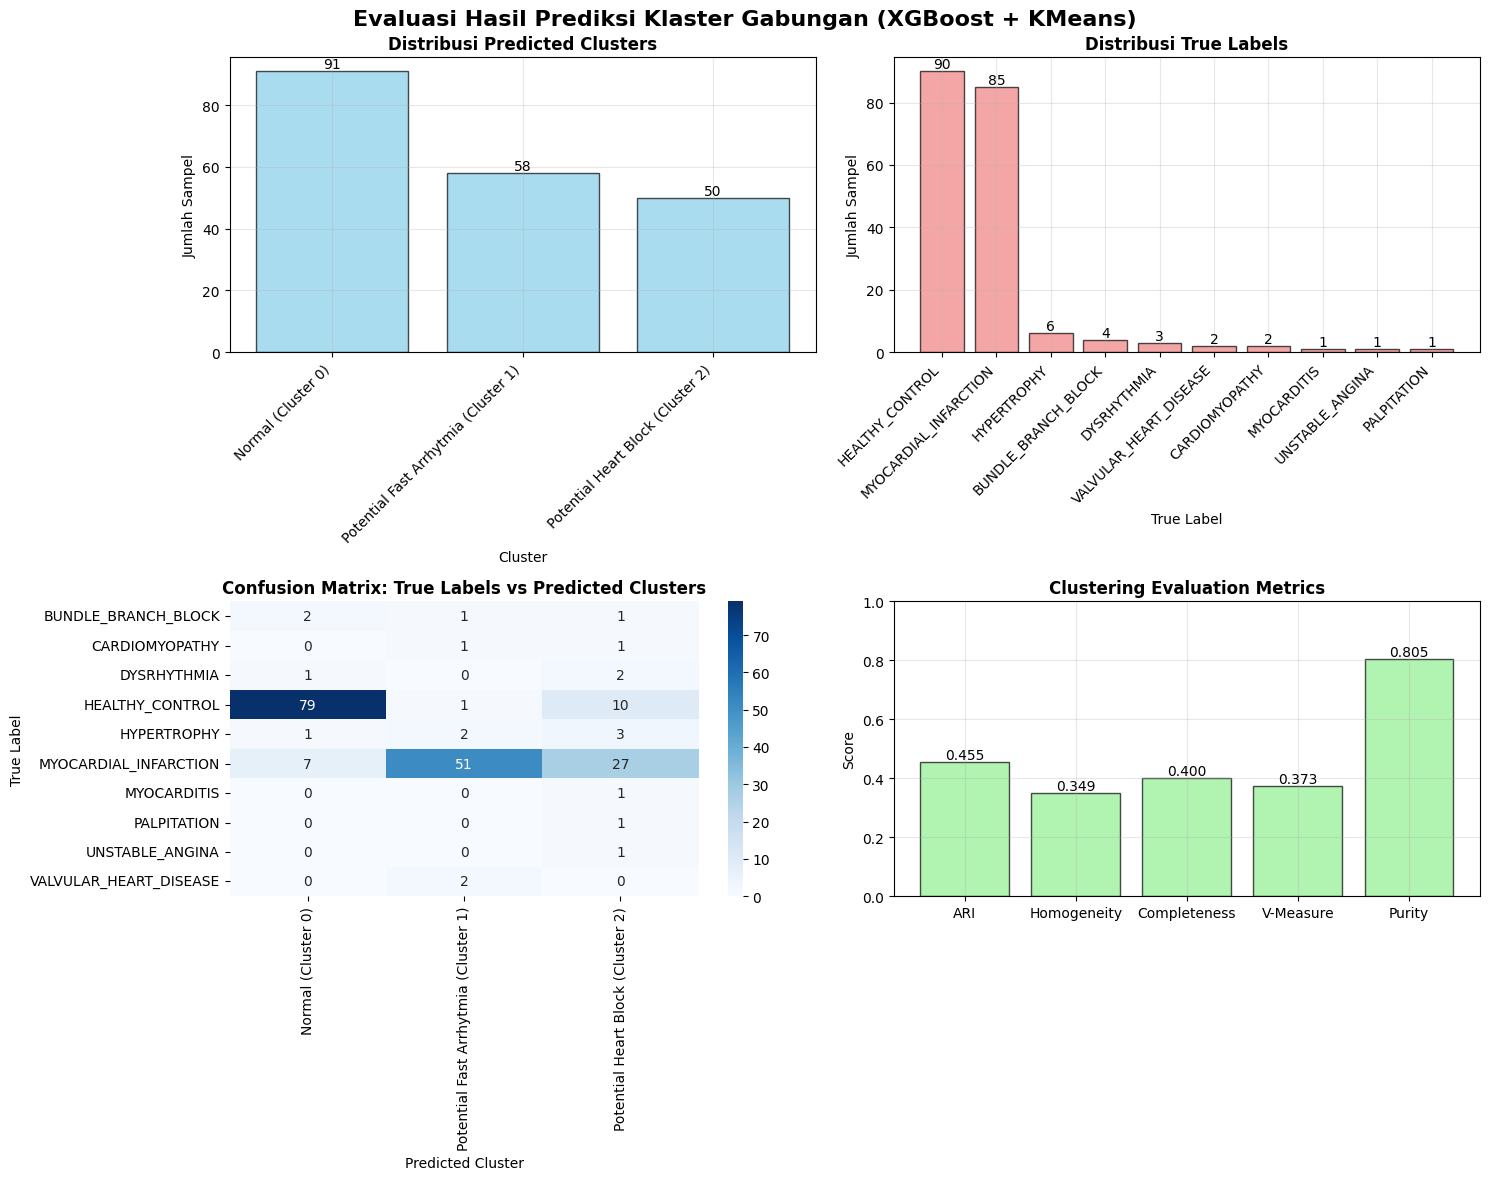


📊 Membuat visualisasi dimensionality reduction...
   Menjalankan t-SNE (ini mungkin memakan waktu beberapa detik)...


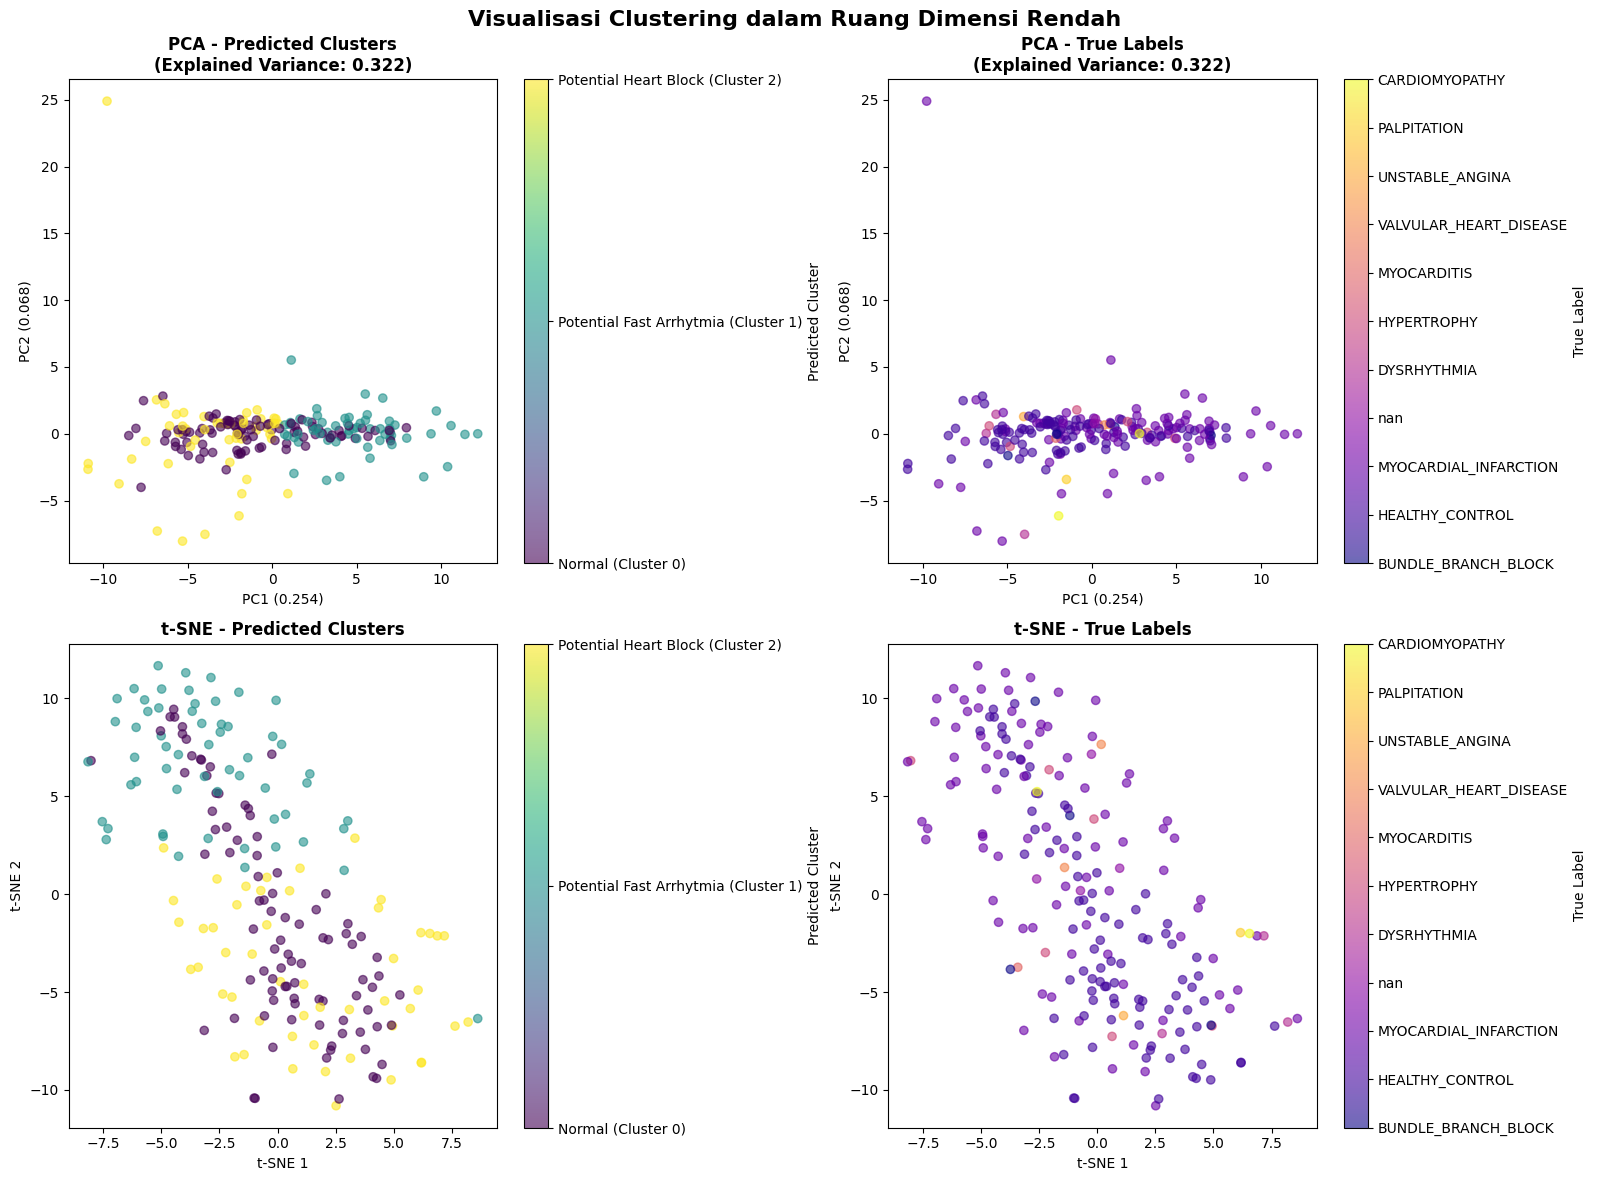


📊 Membuat visualisasi analisis cluster detail...


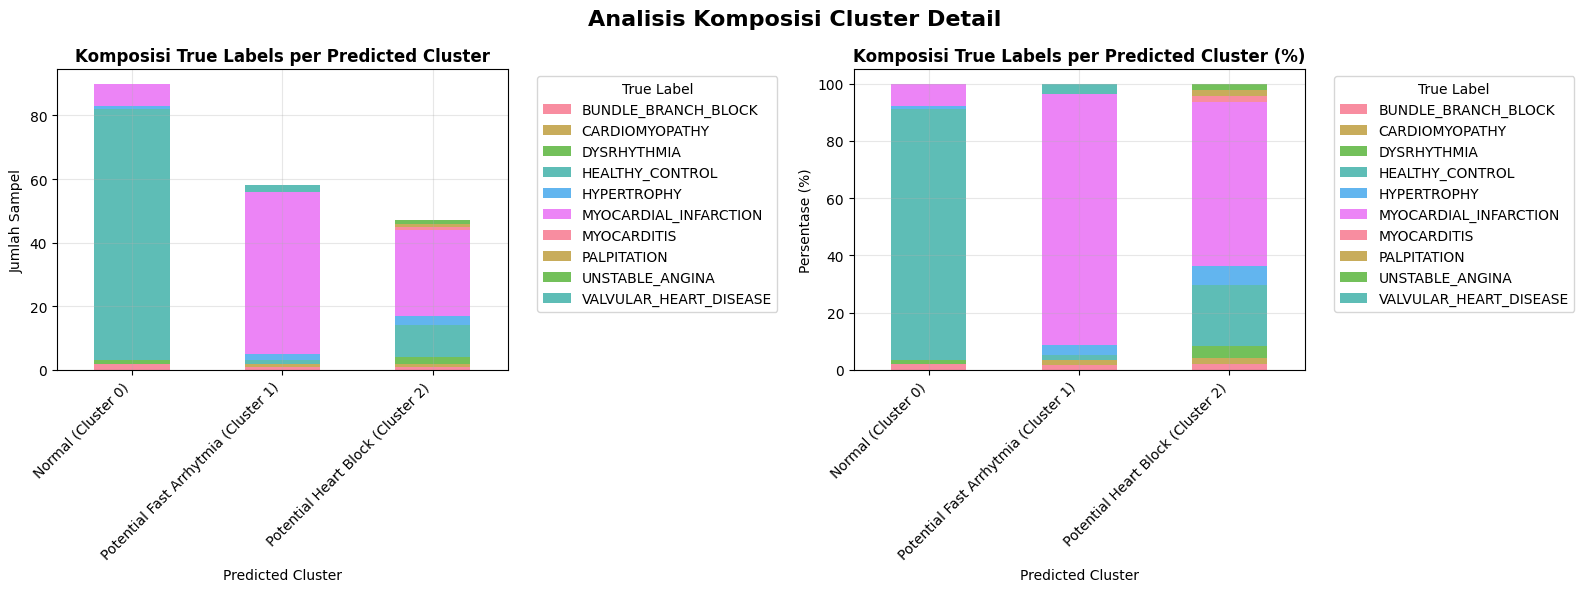


📊 Membuat tabel ringkasan statistik cluster...

📊 TABEL RINGKASAN STATISTIK CLUSTER:
                        Cluster_Name  Size     Most_Common_Label  Most_Common_Count  Purity_Score  Unique_Labels
                  Normal (Cluster 0)    91       HEALTHY_CONTROL                 79     86.813187              6
Potential Fast Arrhytmia (Cluster 1)    58 MYOCARDIAL_INFARCTION                 51     87.931034              6
   Potential Heart Block (Cluster 2)    50 MYOCARDIAL_INFARCTION                 27     54.000000             10

📊 Membuat visualisasi ringkasan performa...


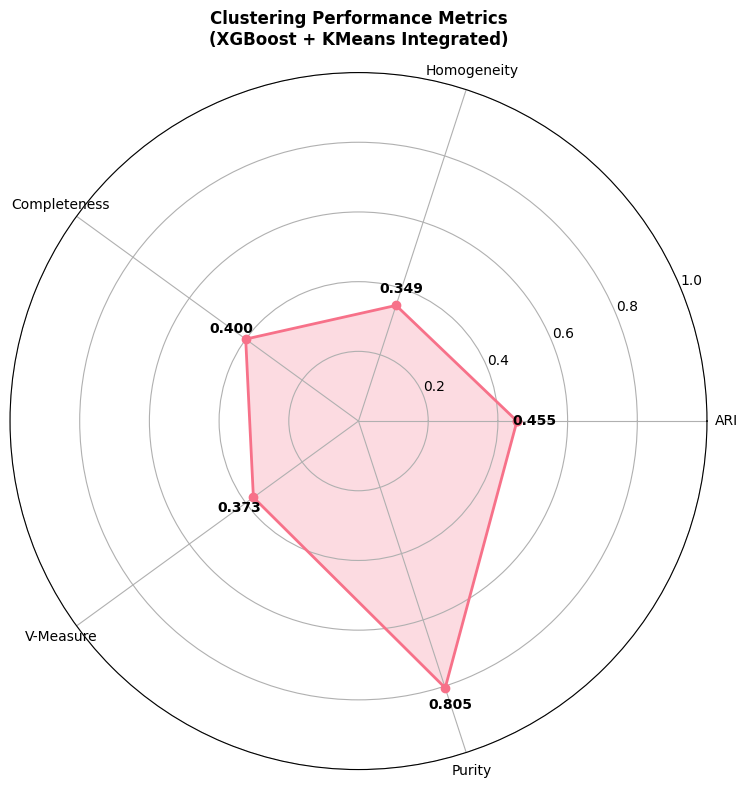


✅ Evaluasi dengan visualisasi selesai.


In [ ]:
# Cell 25: Evaluasi Fungsi predict_clusters_xgb_integrated pada Data Uji dengan Visualisasi

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score # Import clustering metrics
import warnings
warnings.filterwarnings('ignore')

print("📊 EVALUASI KINERJA FUNGSI PREDIKSI KLASTER GABUNGAN (XGBoost + KMeans) PADA DATA UJI")
print("=" * 90)

# Assume X_test and y_test_orig are available from previous steps (Cell 18 prep)
# X_test is already scaled. y_test_orig are the original class names.

print(f"📊 Menggunakan data uji berlabel baru (dari split) dengan ukuran: {X_test.shape}")
print(f"📊 Distribusi True Label pada data uji:\n{y_test_orig.value_counts()}")

# Use the integrated prediction function
# Assumes model_xgb (binary) and kmeans_abnormal are available from previous steps
# Assumes normal_cluster_label=0 and abnormal_label_offset=1 as used in the function definition
if 'model_xgb' not in locals():
    print("❌ Variabel 'model_xgb' (model XGBoost binary) tidak ditemukan. Pastikan Cell 19 dijalankan.")
elif 'kmeans_abnormal' not in locals():
     print("❌ Variabel 'kmeans_abnormal' (model K-Means abnormal) tidak ditemukan. Pastikan Cell 15 atau Cell 16 dijalankan.")
elif 'X_test' not in locals() or 'y_test_orig' not in locals():
    print("❌ Variabel 'X_test' atau 'y_test_orig' tidak ditemukan. Pastikan data split sudah dilakukan (misal Cell 18 prep).")
else:
    predicted_test_labels_xgb_integrated = predict_clusters_xgb_integrated(
        X_test,
        model_xgb, # Use the trained binary XGBoost model
        kmeans_abnormal,
        normal_cluster_label=0,
        abnormal_label_offset=1
    )

    # --- Mapping integer cluster labels to custom names ---
    cluster_name_mapping = {
        0: 'Normal (Cluster 0)',
        1: 'Potential Fast Arrhytmia (Cluster 1)',
        2: 'Potential Heart Block (Cluster 2)'
        # Add other abnormal cluster names if more than 2 are predicted by KMeans
    }

    # Apply mapping to the predicted labels for display
    predicted_test_labels_named = pd.Series(predicted_test_labels_xgb_integrated).map(cluster_name_mapping).fillna('Unknown Cluster').values
    # --- End of Mapping ---


    print("\n📊 Hasil prediksi cluster pada data uji (XGBoost + KMeans Integrated):")
    # Use named labels for counting and display
    unique_pred_labels_test, counts_test = np.unique(predicted_test_labels_named, return_counts=True)
    print("   Distribusi cluster hasil prediksi:")
    for label, count in zip(unique_pred_labels_test, counts_test):
        print(f"     {label}: {count} sampel")

    # Evaluate predicted clusters against true labels
    # Need to use the *original integer labels* for clustering metrics (ARI, Homogeneity, etc.)
    # But use the *named labels* for cross-tabulation and visualization axes/labels
    non_placeholder_mask_test = predicted_test_labels_xgb_integrated != -999 # Assuming -999 is the placeholder
    predicted_test_labels_clean_int = predicted_test_labels_xgb_integrated[non_placeholder_mask_test] # Use integer labels for metrics
    predicted_test_labels_clean_named = predicted_test_labels_named[non_placeholder_mask_test] # Use named labels for display
    y_test_orig_clean = y_test_orig[non_placeholder_mask_test] # Align true labels
    X_test_clean = X_test[non_placeholder_mask_test] # Align test features for visualization

    # Check if we have enough clusters and samples after filtering
    if len(np.unique(predicted_test_labels_clean_int)) < 2 or len(predicted_test_labels_clean_int) < 2:
        print("⚠️ Insufficient clusters or samples in predicted results for comprehensive evaluation.")
    else:
        print("\n📊 METRIK EVALUASI CLUSTERING PADA DATA UJI (XGBoost + KMeans Integrated):")
        print("=" * 80)

        # Supervised clustering metrics - Use integer labels for these
        if 'label_encoder' not in locals():
             print("❌ Variabel 'label_encoder' tidak ditemukan. Tidak dapat menghitung supervised metrics.")
        else:
            y_test_orig_clean_encoded = label_encoder.transform(y_test_orig_clean)

            ari_test = adjusted_rand_score(y_test_orig_clean_encoded, predicted_test_labels_clean_int)
            homogeneity_test = homogeneity_score(y_test_orig_clean_encoded, predicted_test_labels_clean_int)
            completeness_test = completeness_score(y_test_orig_clean_encoded, predicted_test_labels_clean_int)
            v_measure_test = v_measure_score(y_test_orig_clean_encoded, predicted_test_labels_clean_int)

            # Purity calculation - Use named labels for cross-tabulation with true labels
            def calculate_purity(y_true, y_pred):
                contingency_matrix = pd.crosstab(y_true, y_pred)
                return np.sum(np.amax(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

            purity_test = calculate_purity(y_test_orig_clean, predicted_test_labels_clean_named) # Use named labels for purity table

            print(f"   Adjusted Rand Index (ARI): {ari_test:.4f}")
            print(f"   Homogeneity: {homogeneity_test:.4f}")
            print(f"   Completeness: {completeness_test:.4f}")
            print(f"   V-Measure: {v_measure_test:.4f}")
            print(f"   Purity: {purity_test:.4f}")

        # Analyze distribution of true labels within predicted clusters - Use named labels here
        print("\n📊 DISTRIBUSI TRUE LABEL PER PREDICTED CLUSTER:")
        print("=" * 50)

        # Create a DataFrame for easier cross-tabulation - Use named labels
        test_results_df = pd.DataFrame({'Predicted_Cluster': predicted_test_labels_clean_named, 'True_Label': y_test_orig_clean})

        # Cross-tabulate true labels vs predicted clusters
        contingency_table_test = pd.crosstab(test_results_df['True_Label'], test_results_df['Predicted_Cluster'])
        print(contingency_table_test)

        # Optional: Analyze the composition of each named cluster
        print("\n🔬 Analisis Komposisi Klaster:")
        for cluster_name in sorted(np.unique(predicted_test_labels_clean_named)):
            print(f"\n   Komposisi True Label dalam Predicted {cluster_name}:")
            if cluster_name in contingency_table_test.columns:
                 cluster_composition = contingency_table_test[cluster_name]
                 total_in_cluster = cluster_composition.sum()
                 if total_in_cluster > 0:
                     for true_label, count in cluster_composition.items():
                         percentage = (count / total_in_cluster) * 100
                         print(f"   - {true_label}: {count} ({percentage:.2f}%)")
                 else:
                      print(f"   - {cluster_name} kosong.")


        # ============================================================================
        # VISUALISASI DAN PLOT
        # ============================================================================
        print("\n📊 MEMBUAT VISUALISASI DAN PLOT...")
        print("=" * 50)

        # Set style untuk plotting
        plt.style.use('default')
        sns.set_palette("husl")

        # 1. Bar Chart - Distribusi Cluster Prediksi - Use named labels
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Evaluasi Hasil Prediksi Klaster Gabungan (XGBoost + KMeans)', fontsize=16, fontweight='bold')

        # Subplot 1: Distribusi Predicted Clusters
        ax1 = axes[0, 0]
        unique_pred, counts_pred = np.unique(predicted_test_labels_clean_named, return_counts=True)
        bars1 = ax1.bar(unique_pred, counts_pred, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_title('Distribusi Predicted Clusters', fontweight='bold')
        ax1.set_xlabel('Cluster')
        ax1.set_ylabel('Jumlah Sampel')
        ax1.set_xticklabels(unique_pred, rotation=45, ha='right') # Set named labels
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

        # Subplot 2: Distribusi True Labels (stays the same)
        ax2 = axes[0, 1]
        true_counts = y_test_orig_clean.value_counts()
        bars2 = ax2.bar(range(len(true_counts)), true_counts.values, alpha=0.7, color='lightcoral', edgecolor='black')
        ax2.set_title('Distribusi True Labels', fontweight='bold')
        ax2.set_xlabel('True Label')
        ax2.set_ylabel('Jumlah Sampel')
        ax2.set_xticks(range(len(true_counts)))
        ax2.set_xticklabels(true_counts.index, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')

        # Subplot 3: Heatmap Contingency Table - Use named labels
        ax3 = axes[1, 0]
        sns.heatmap(contingency_table_test, annot=True, fmt='d', cmap='Blues', ax=ax3)
        ax3.set_title('Confusion Matrix: True Labels vs Predicted Clusters', fontweight='bold')
        ax3.set_xlabel('Predicted Cluster')
        ax3.set_ylabel('True Label')
        # xticklabels and yticklabels are automatically set by seaborn from contingency_table_test columns/index


        # Subplot 4: Metrics Bar Chart (stays the same, metrics are based on integer labels vs true labels)
        ax4 = axes[1, 1]
        if 'label_encoder' in locals():
            metrics_names = ['ARI', 'Homogeneity', 'Completeness', 'V-Measure', 'Purity']
            metrics_values = [ari_test, homogeneity_test, completeness_test, v_measure_test, purity_test]
            bars4 = ax4.bar(metrics_names, metrics_values, alpha=0.7, color='lightgreen', edgecolor='black')
            ax4.set_title('Clustering Evaluation Metrics', fontweight='bold')
            ax4.set_ylabel('Score')
            ax4.set_ylim(0, 1)
            ax4.grid(True, alpha=0.3)

            # Add value labels on bars
            for bar, value in zip(bars4, metrics_values):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{value:.3f}', ha='center', va='bottom')
        else:
            ax4.text(0.5, 0.5, 'Label Encoder\nNot Available', ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Clustering Evaluation Metrics', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 2. Dimensionality Reduction Visualization - Use named labels for coloring and legend
        print("\n📊 Membuat visualisasi dimensionality reduction...")

        # PCA Visualization
        if X_test_clean.shape[1] >= 2:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Visualisasi Clustering dalam Ruang Dimensi Rendah', fontsize=16, fontweight='bold')

            # PCA for Predicted Clusters - Use named labels for legend/coloring
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_test_clean)

            # Need to map named labels to numerical values for scatter plot coloring
            unique_named_labels = np.unique(predicted_test_labels_clean_named)
            named_label_mapping = {label: i for i, label in enumerate(unique_named_labels)}
            named_labels_numeric = pd.Series(predicted_test_labels_clean_named).map(named_label_mapping).values


            ax1 = axes[0, 0]
            scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=named_labels_numeric, cmap='viridis', alpha=0.6)
            ax1.set_title(f'PCA - Predicted Clusters\n(Explained Variance: {pca.explained_variance_ratio_.sum():.3f})', fontweight='bold')
            ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
            ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
            cbar1 = plt.colorbar(scatter1, ax=ax1, label='Predicted Cluster')
            cbar1.set_ticks(range(len(unique_named_labels)))
            cbar1.set_ticklabels(unique_named_labels) # Set named labels for colorbar

            # PCA for True Labels (stays the same)
            ax2 = axes[0, 1]
            # Create numerical mapping for true labels for coloring
            unique_true_labels = y_test_orig_clean.unique()
            true_label_mapping = {label: i for i, label in enumerate(unique_true_labels)}
            true_labels_numeric = [true_label_mapping[label] for label in y_test_orig_clean]

            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels_numeric, cmap='plasma', alpha=0.6)
            ax2.set_title(f'PCA - True Labels\n(Explained Variance: {pca.explained_variance_ratio_.sum():.3f})', fontweight='bold')
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
            cbar2 = plt.colorbar(scatter2, ax=ax2, label='True Label')
            cbar2.set_ticks(range(len(unique_true_labels)))
            cbar2.set_ticklabels(unique_true_labels)

            # t-SNE Visualization (only if dataset is not too large) - Use named labels
            if len(X_test_clean) <= 1000:  # Limit t-SNE to avoid long computation
                print("   Menjalankan t-SNE (ini mungkin memakan waktu beberapa detik)...")
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_test_clean)-1))
                X_tsne = tsne.fit_transform(X_test_clean)

                # t-SNE for Predicted Clusters - Use named labels
                ax3 = axes[1, 0]
                scatter3 = ax3.scatter(X_tsne[:, 0], X_tsne[:, 1], c=named_labels_numeric, cmap='viridis', alpha=0.6)
                ax3.set_title('t-SNE - Predicted Clusters', fontweight='bold')
                ax3.set_xlabel('t-SNE 1')
                ax3.set_ylabel('t-SNE 2')
                cbar3 = plt.colorbar(scatter3, ax=ax3, label='Predicted Cluster')
                cbar3.set_ticks(range(len(unique_named_labels)))
                cbar3.set_ticklabels(unique_named_labels) # Set named labels


                # t-SNE for True Labels (stays the same)
                ax4 = axes[1, 1]
                scatter4 = ax4.scatter(X_tsne[:, 0], X_tsne[:, 1], c=true_labels_numeric, cmap='plasma', alpha=0.6)
                ax4.set_title('t-SNE - True Labels', fontweight='bold')
                ax4.set_xlabel('t-SNE 1')
                ax4.set_ylabel('t-SNE 2')
                cbar4 = plt.colorbar(scatter4, ax=ax4, label='True Label')
                cbar4.set_ticks(range(len(unique_true_labels)))
                cbar4.set_ticklabels(unique_true_labels)
            else:
                # Skip t-SNE for large datasets
                ax3 = axes[1, 0]
                ax3.text(0.5, 0.5, f'Dataset terlalu besar untuk t-SNE\n(n={len(X_test_clean)} > 1000)',
                        ha='center', va='center', transform=ax3.transAxes, fontsize=12)
                ax3.set_title('t-SNE - Predicted Clusters', fontweight='bold')

                ax4 = axes[1, 1]
                ax4.text(0.5, 0.5, f'Dataset terlalu besar untuk t-SNE\n(n={len(X_test_clean)} > 1000)',
                        ha='center', va='center', transform=ax4.transAxes, fontsize=12)
                ax4.set_title('t-SNE - True Labels', fontweight='bold')


            plt.tight_layout()
            plt.show()


        # 3. Detailed Cluster Analysis Visualization - Use named labels
        print("\n📊 Membuat visualisasi analisis cluster detail...")

        # Create a more detailed cluster composition plot - Use named labels
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Analisis Komposisi Cluster Detail', fontsize=16, fontweight='bold')

        # Stacked bar chart for cluster composition
        ax1 = axes[0]
        cluster_composition = pd.crosstab(predicted_test_labels_clean_named, y_test_orig_clean) # Use named labels for index
        cluster_composition.plot(kind='bar', stacked=True, ax=ax1, alpha=0.8)
        ax1.set_title('Komposisi True Labels per Predicted Cluster', fontweight='bold')
        ax1.set_xlabel('Predicted Cluster')
        ax1.set_ylabel('Jumlah Sampel')
        ax1.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right') # Rotate x-axis labels


        # Percentage stacked bar chart
        ax2 = axes[1]
        cluster_composition_pct = cluster_composition.div(cluster_composition.sum(axis=1), axis=0) * 100
        cluster_composition_pct.plot(kind='bar', stacked=True, ax=ax2, alpha=0.8)
        ax2.set_title('Komposisi True Labels per Predicted Cluster (%)', fontweight='bold')
        ax2.set_xlabel('Predicted Cluster')
        ax2.set_ylabel('Persentase (%)')
        ax2.legend(title='True Label', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right') # Rotate x-axis labels


        plt.tight_layout()
        plt.show()


        # 4. Create a summary table with cluster statistics - Use named labels
        print("\n📊 Membuat tabel ringkasan statistik cluster...")

        cluster_stats = []
        # Use named labels for iterating and the table
        for cluster_name in sorted(np.unique(predicted_test_labels_clean_named)):
            cluster_mask = predicted_test_labels_clean_named == cluster_name # Use named labels for mask
            cluster_size = np.sum(cluster_mask)
            cluster_true_labels = y_test_orig_clean[cluster_mask]

            # Most common true label in this cluster
            most_common_label = cluster_true_labels.mode().iloc[0] if len(cluster_true_labels) > 0 else "N/A"
            most_common_count = np.sum(cluster_true_labels == most_common_label)
            purity_score = (most_common_count / cluster_size) * 100 if cluster_size > 0 else 0

            cluster_stats.append({
                'Cluster_Name': cluster_name, # Use named label
                'Size': cluster_size,
                'Most_Common_Label': most_common_label,
                'Most_Common_Count': most_common_count,
                'Purity_Score': purity_score,
                'Unique_Labels': len(cluster_true_labels.unique())
            })

        cluster_stats_df = pd.DataFrame(cluster_stats)
        print("\n📊 TABEL RINGKASAN STATISTIK CLUSTER:")
        print("=" * 80)
        print(cluster_stats_df.to_string(index=False))


        # 5. Performance metrics summary visualization (Radar Chart) - Metrics use integer labels, but title can use named concept
        if 'label_encoder' in locals():
            print("\n📊 Membuat visualisasi ringkasan performa...")

            # Create a radar chart for metrics
            fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw=dict(projection='polar'))

            metrics_names = ['ARI', 'Homogeneity', 'Completeness', 'V-Measure', 'Purity']
            metrics_values = [ari_test, homogeneity_test, completeness_test, v_measure_test, purity_test]

            # Add the first value at the end to close the circle
            metrics_values += [metrics_values[0]]
            angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
            angles += [angles[0]]

            ax.plot(angles, metrics_values, 'o-', linewidth=2, label='Clustering Performance')
            ax.fill(angles, metrics_values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(metrics_names)
            ax.set_ylim(0, 1)
            ax.set_title('Clustering Performance Metrics\n(XGBoost + KMeans Integrated)',
                        fontweight='bold', pad=20)
            ax.grid(True)

            # Add value labels
            for angle, value, name in zip(angles[:-1], metrics_values[:-1], metrics_names):
                ax.text(angle, value + 0.05, f'{value:.3f}', ha='center', va='center', fontweight='bold')

            plt.tight_layout()
            plt.show()


print("\n✅ Evaluasi dengan visualisasi selesai.")

In [ ]:
import joblib
import os
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# Define the export directory path
export_dir = "exported_models_ecg"

# Create the directory if it doesn't exist (should already exist from previous export)
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"✅ Direktori '{export_dir}' dibuat.")
else:
    print(f"✅ Direktori '{export_dir}' sudah ada.")

# --- Ensure scaler is created and fitted before export ---
# Assuming X_train is available from previous data preprocessing steps
if 'X_train' in locals() and X_train is not None:
    print("\n🔄 Membuat dan melatih ulang scaler pada X_train sebelum ekspor...")
    scaler = StandardScaler()
    scaler.fit(X_train)
    print("✅ Scaler berhasil dilatih.")

    scaler_filename = os.path.join(export_dir, 'scaler.pkl')
    try:
        joblib.dump(scaler, scaler_filename)
        print(f"✅ Scaler berhasil diekspor ke '{scaler_filename}'")
    except Exception as e:
        print(f"❌ Gagal mengekspor scaler: {e}")
else:
    print("⚠️ Variabel 'X_train' tidak ditemukan atau kosong. Tidak dapat membuat dan mengekspor scaler.")

print("\n🎉 Proses ekspor scaler selesai!")

✅ Direktori 'exported_models_ecg' sudah ada.

🔄 Membuat dan melatih ulang scaler pada X_train sebelum ekspor...
✅ Scaler berhasil dilatih.
✅ Scaler berhasil diekspor ke 'exported_models_ecg/scaler.pkl'

🎉 Proses ekspor scaler selesai!
